In [133]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import os
import sys
import pandas as pd
import numpy as np
import quandl
import cvxpy as cvx

In [135]:
sys.path.insert(0, os.path.abspath('..'))
import helium

In [136]:
%matplotlib inline

In [137]:
quandl.ApiConfig.api_key = '8wnB7EcvJm1xEvJjzWBR'

In [138]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["_CASH"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,NKE,TSLA,_CASH
Date,,,,,
2016-12-23,-0.007503,-0.002322,-0.004411,0.023459,0.000020
2016-12-27,0.014213,0.002637,-0.011944,0.029015,0.000020
2016-12-28,0.000946,-0.006618,-0.005264,0.000957,0.000021
2016-12-29,-0.009040,-0.002101,0.000784,-0.023027,0.000018
2016-12-30,-0.019970,-0.012991,-0.004505,-0.004612,0.000020


In [139]:
rets = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
sigmas = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack()

rets.tail()

,AMZN,GOOGL,NKE,TSLA,_CASH
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000660,-0.000074,0.000012
2016-12-27,0.000542,0.000150,-0.000706,-0.000124,0.000013
2016-12-28,0.000627,0.000179,-0.000691,-0.000023,0.000013
2016-12-29,0.000707,0.000215,-0.000664,-0.000052,0.000013
2016-12-30,0.000901,0.000302,-0.000598,0.000133,0.000013


In [140]:
cash_ticker = "_CASH"

In [141]:
price_sigma = rets.copy()
price_sigma[:] = 0.

In [143]:
volumes = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Volume'])
                for ticker in tickers]))
volumes[cash_ticker] = np.finfo(np.float).max

In [144]:
tcost_model=helium.TransactionCost(gamma = 1., 
                                   half_spread=10E-4,
                                   nonlin_coef = 0.,  #1.,
                                   sigmas = price_sigma, 
                                   nonlin_power = 1.5,
                                   volumes = volumes,
                                   asym_coef = 0.)

In [180]:
borrow_costs = rets.copy()
borrow_costs[:] = 1E-4
borrow_costs["_CASH"] = 0.

dividends = rets.copy()
dividends[:] = 0.


hcost_model=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)

In [181]:
risk_model = helium.BasicRiskCost(5.0, sigmas)

In [182]:
leverage_limit = helium.LeverageLimitConstraint(3.)

In [183]:
holding_init = pd.Series(index=rets.columns, data=0.)
holding_init[cash_ticker] = 100.
holding_init

AMZN       0.0
GOOGL      0.0
NKE        0.0
TSLA       0.0
_CASH    100.0
dtype: float64

In [184]:
deltas = rets.copy()
deltas[:]  = 0.

In [185]:
r = helium.DefaultRet(rets=rets, deltas = deltas, gamma_decay=None)

In [186]:
spo_policy = helium.SinglePeriodOpt(rets=r,
                                   costs=[hcost_model],
                                   constraints=[leverage_limit]
                                   )

In [187]:
simulator = helium.MarketSimulator(returns, volumes, costs=[], cash_ticker='_CASH')

In [188]:
result = simulator.run(holding_init, policy=spo_policy, start_date='2013-01-03', end_date='2016-12-31')

INFO:root:Backtest started, from 2013-01-03 00:00:00 to 2016-12-30 00:00:00
INFO:root:Getting trades at date: 2013-01-03 00:00:00
INFO:root:Propagating portfolio at time 2013-01-03 00:00:00
INFO:root:Getting trades at date: 2013-01-04 00:00:00
INFO:root:Propagating portfolio at time 2013-01-04 00:00:00
INFO:root:Getting trades at date: 2013-01-07 00:00:00
INFO:root:Propagating portfolio at time 2013-01-07 00:00:00
INFO:root:Getting trades at date: 2013-01-08 00:00:00
INFO:root:Propagating portfolio at time 2013-01-08 00:00:00
INFO:root:Getting trades at date: 2013-01-09 00:00:00
INFO:root:Propagating portfolio at time 2013-01-09 00:00:00
INFO:root:Getting trades at date: 2013-01-10 00:00:00
INFO:root:Propagating portfolio at time 2013-01-10 00:00:00
INFO:root:Getting trades at date: 2013-01-11 00:00:00


0.0001
0.0
******
QQQ: AMZN       0.0
GOOGL      0.0
NKE        0.0
TSLA       0.0
_CASH    100.0
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.64589414e-03]
 [  4.37894343e-04]
 [  4.39123014e-04]
 [  1.49116371e-03]
 [  3.51200000e-06]], [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0])[1, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0])[2, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var73011[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.]
 [ 0.]
 [ 0.]


INFO:root:Propagating portfolio at time 2013-01-11 00:00:00
INFO:root:Getting trades at date: 2013-01-14 00:00:00
INFO:root:Propagating portfolio at time 2013-01-14 00:00:00
INFO:root:Getting trades at date: 2013-01-15 00:00:00
INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at date: 2013-01-17 00:00:00
INFO:root:Propagating portfolio at time 2013-01-17 00:00:00
INFO:root:Getting trades at date: 2013-01-18 00:00:00
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00
INFO:root:Getting trades at date: 2013-01-22 00:00:00
INFO:root:Propagating portfolio at time 2013-01-22 00:00:00
INFO:root:Getting trades at date: 2013-01-23 00:00:00
INFO:root:Propagating portfolio at time 2013-01-23 00:00:00



0.0
******
QQQ: AMZN     2.132089e+02
GOOGL    3.957258e-08
NKE     -1.404001e-06
TSLA     7.478765e-07
_CASH   -1.070105e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.77169600e-03]
 [  7.78335175e-04]
 [  4.39111851e-04]
 [  1.25582619e-03]
 [  3.56000000e-06]], [[  2.00764680e+00]
 [  3.72628817e-10]
 [ -1.32205440e-08]
 [  7.04225797e-09]
 [ -1.00764679e+00]] + var73089)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00764680e+00]
 [  3.72628817e-10]
 [ -1.32205440e-08]
 [  7.04225797e-09]
 [ -1.00764679e+00]] + var73089[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00764680e+00]
 [  3.72628817e-10]
 [ -1.32205440e-08]
 [  7.04225797e-09]
 [ -1.00764679e+00]] + var73089[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00764680e+00]
 [  3.72628817e-10]
 [ -1.32205440e-08]
 [  7.04225797e-09]
 [ -1.00764679e+00]] + var73089[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00764680e+00]
 [  3.72628817e-10]
 [ -1.32205440e-08]
 [  7.04225797e-09]
 [ -1.00764679e+00

INFO:root:Getting trades at date: 2013-01-24 00:00:00
INFO:root:Propagating portfolio at time 2013-01-24 00:00:00
INFO:root:Getting trades at date: 2013-01-25 00:00:00
INFO:root:Propagating portfolio at time 2013-01-25 00:00:00
INFO:root:Getting trades at date: 2013-01-28 00:00:00
INFO:root:Propagating portfolio at time 2013-01-28 00:00:00
INFO:root:Getting trades at date: 2013-01-29 00:00:00
INFO:root:Propagating portfolio at time 2013-01-29 00:00:00
INFO:root:Getting trades at date: 2013-01-30 00:00:00
INFO:root:Propagating portfolio at time 2013-01-30 00:00:00
INFO:root:Getting trades at date: 2013-01-31 00:00:00
INFO:root:Propagating portfolio at time 2013-01-31 00:00:00
INFO:root:Getting trades at date: 2013-02-01 00:00:00



u = AMZN    -1.655152e+00
GOOGL    1.207692e-07
NKE      2.727739e-07
TSLA    -1.027020e-07
_CASH    1.655152e+00
dtype: float64
h_plus: AMZN     2.281827e+02
GOOGL    4.328348e-07
NKE     -2.181694e-06
TSLA     1.930076e-06
_CASH   -1.149769e+02
dtype: float64
u: AMZN    -1.655152e+00
GOOGL    1.207692e-07
NKE      2.727739e-07
TSLA    -1.027020e-07
_CASH    1.655152e+00
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2.281827e+02
GOOGL    4.328348e-07
NKE     -2.181694e-06
TSLA     1.930076e-06
_CASH   -1.149769e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.62898595e-03]
 [  1.06901635e-03]
 [  3.16812965e-04]
 [  1.52247070e-03]
 [  3.61280000e-06]], [[  2.01564382e+00]
 [  3.82343023e-09]
 [ -1.92719154e-08]
 [  1.70492581e-08]
 [ -1.01564383e+00]] + var73193)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.01564382e+00]
 [  3.82343023e-09]
 [ -1.92719154e-08]
 [  1.70492581e-08]
 [ -1.01564383e+00]] + var73193[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01564382

INFO:root:Propagating portfolio at time 2013-02-01 00:00:00
INFO:root:Getting trades at date: 2013-02-04 00:00:00
INFO:root:Propagating portfolio at time 2013-02-04 00:00:00
INFO:root:Getting trades at date: 2013-02-05 00:00:00
INFO:root:Propagating portfolio at time 2013-02-05 00:00:00
INFO:root:Getting trades at date: 2013-02-06 00:00:00
INFO:root:Propagating portfolio at time 2013-02-06 00:00:00
INFO:root:Getting trades at date: 2013-02-07 00:00:00
INFO:root:Propagating portfolio at time 2013-02-07 00:00:00
INFO:root:Getting trades at date: 2013-02-08 00:00:00
INFO:root:Propagating portfolio at time 2013-02-08 00:00:00
INFO:root:Getting trades at date: 2013-02-11 00:00:00
INFO:root:Propagating portfolio at time 2013-02-11 00:00:00
INFO:root:Getting trades at date: 2013-02-12 00:00:00
INFO:root:Propagating portfolio at time 2013-02-12 00:00:00



0.0
******
QQQ: AMZN     2.018403e+02
GOOGL    2.809297e-07
NKE     -4.035434e-06
TSLA     4.082962e-06
_CASH   -1.036816e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.75698034e-03]
 [  1.14442006e-03]
 [  3.31433028e-04]
 [  1.38203252e-03]
 [  3.63200000e-06]], [[  2.05626464e+00]
 [  2.86199369e-09]
 [ -4.11113039e-08]
 [  4.15954973e-08]
 [ -1.05626464e+00]] + var73271)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.05626464e+00]
 [  2.86199369e-09]
 [ -4.11113039e-08]
 [  4.15954973e-08]
 [ -1.05626464e+00]] + var73271[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05626464e+00]
 [  2.86199369e-09]
 [ -4.11113039e-08]
 [  4.15954973e-08]
 [ -1.05626464e+00]] + var73271[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.05626464e+00]
 [  2.86199369e-09]
 [ -4.11113039e-08]
 [  4.15954973e-08]
 [ -1.05626464e+00]] + var73271[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05626464e+00]
 [  2.86199369e-09]
 [ -4.11113039e-08]
 [  4.15954973e-08]
 [ -1.05626464e+00

INFO:root:Getting trades at date: 2013-02-13 00:00:00
INFO:root:Propagating portfolio at time 2013-02-13 00:00:00
INFO:root:Getting trades at date: 2013-02-14 00:00:00
INFO:root:Propagating portfolio at time 2013-02-14 00:00:00
INFO:root:Getting trades at date: 2013-02-15 00:00:00
INFO:root:Propagating portfolio at time 2013-02-15 00:00:00
INFO:root:Getting trades at date: 2013-02-19 00:00:00
INFO:root:Propagating portfolio at time 2013-02-19 00:00:00
INFO:root:Getting trades at date: 2013-02-20 00:00:00
INFO:root:Propagating portfolio at time 2013-02-20 00:00:00
INFO:root:Getting trades at date: 2013-02-21 00:00:00
INFO:root:Propagating portfolio at time 2013-02-21 00:00:00
INFO:root:Getting trades at date: 2013-02-22 00:00:00



u = AMZN    -3.453582e+00
GOOGL    8.462686e-07
NKE      2.306041e-06
TSLA     2.589540e-07
_CASH    3.453579e+00
dtype: float64
h_plus: AMZN     1.849785e+02
GOOGL    1.198252e-06
NKE     -5.306988e-07
TSLA     7.493541e-07
_CASH   -9.195689e+01
dtype: float64
u: AMZN    -3.453582e+00
GOOGL    8.462686e-07
NKE      2.306041e-06
TSLA     2.589540e-07
_CASH    3.453579e+00
dtype: float64
0.0001
0.0
******
QQQ: AMZN     1.849785e+02
GOOGL    1.198252e-06
NKE     -5.306988e-07
TSLA     7.493541e-07
_CASH   -9.195689e+01
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.38936350e-03]
 [  1.06507531e-03]
 [  3.51107589e-04]
 [  1.16722562e-03]
 [  3.61440000e-06]], [[  1.98855385e+00]
 [  1.28814302e-08]
 [ -5.70511165e-09]
 [  8.05569749e-09]
 [ -9.88553861e-01]] + var73375)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98855385e+00]
 [  1.28814302e-08]
 [ -5.70511165e-09]
 [  8.05569749e-09]
 [ -9.88553861e-01]] + var73375[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98855385

INFO:root:Propagating portfolio at time 2013-02-22 00:00:00
INFO:root:Getting trades at date: 2013-02-25 00:00:00
INFO:root:Propagating portfolio at time 2013-02-25 00:00:00
INFO:root:Getting trades at date: 2013-02-26 00:00:00
INFO:root:Propagating portfolio at time 2013-02-26 00:00:00
INFO:root:Getting trades at date: 2013-02-27 00:00:00
INFO:root:Propagating portfolio at time 2013-02-27 00:00:00
INFO:root:Getting trades at date: 2013-02-28 00:00:00
INFO:root:Propagating portfolio at time 2013-02-28 00:00:00
INFO:root:Getting trades at date: 2013-03-01 00:00:00
INFO:root:Propagating portfolio at time 2013-03-01 00:00:00
INFO:root:Getting trades at date: 2013-03-04 00:00:00
INFO:root:Propagating portfolio at time 2013-03-04 00:00:00



QQQ: AMZN     1.964929e+02
GOOGL    5.111086e-07
NKE      2.404913e-07
TSLA     4.567713e-07
_CASH   -9.842059e+01
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.73685938e-03]
 [  1.16891937e-03]
 [  2.91287705e-04]
 [  5.54356247e-04]
 [  3.62880000e-06]], [[  2.00355132e+00]
 [  5.21154863e-09]
 [  2.45218332e-09]
 [  4.65749547e-09]
 [ -1.00355133e+00]] + var73453)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00355132e+00]
 [  5.21154863e-09]
 [  2.45218332e-09]
 [  4.65749547e-09]
 [ -1.00355133e+00]] + var73453[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00355132e+00]
 [  5.21154863e-09]
 [  2.45218332e-09]
 [  4.65749547e-09]
 [ -1.00355133e+00]] + var73453[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00355132e+00]
 [  5.21154863e-09]
 [  2.45218332e-09]
 [  4.65749547e-09]
 [ -1.00355133e+00]] + var73453[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00355132e+00]
 [  5.21154863e-09]
 [  2.45218332e-09]
 [  4.65749547e-09]
 [ -1.00355133e+00]] + var734

INFO:root:Getting trades at date: 2013-03-05 00:00:00
INFO:root:Propagating portfolio at time 2013-03-05 00:00:00
INFO:root:Getting trades at date: 2013-03-06 00:00:00
INFO:root:Propagating portfolio at time 2013-03-06 00:00:00
INFO:root:Getting trades at date: 2013-03-07 00:00:00
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at date: 2013-03-11 00:00:00
INFO:root:Propagating portfolio at time 2013-03-11 00:00:00
INFO:root:Getting trades at date: 2013-03-12 00:00:00
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at date: 2013-03-13 00:00:00
INFO:root:Propagating portfolio at time 2013-03-13 00:00:00
INFO:root:Getting trades at date: 2013-03-14 00:00:00


0.0001
0.0
******
QQQ: AMZN     2.011291e+02
GOOGL    1.298582e-06
NKE      3.696713e-07
TSLA     5.592182e-07
_CASH   -9.785121e+01
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.87171069e-03]
 [  1.21156876e-03]
 [  1.95003168e-04]
 [  6.27902918e-04]
 [  3.65920000e-06]], [[  1.94745531e+00]
 [  1.25736701e-08]
 [  3.57938403e-09]
 [  5.41469346e-09]
 [ -9.47455328e-01]] + var73544)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.94745531e+00]
 [  1.25736701e-08]
 [  3.57938403e-09]
 [  5.41469346e-09]
 [ -9.47455328e-01]] + var73544[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.94745531e+00]
 [  1.25736701e-08]
 [  3.57938403e-09]
 [  5.41469346e-09]
 [ -9.47455328e-01]] + var73544[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.94745531e+00]
 [  1.25736701e-08]
 [  3.57938403e-09]
 [  5.41469346e-09]
 [ -9.47455328e-01]] + var73544[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.94745531e+00]
 [  1.25736701e-08]
 [  3.57938403e-09]
 [  5.41469346e-09]
 [ -9.474553

INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at date: 2013-03-15 00:00:00
INFO:root:Propagating portfolio at time 2013-03-15 00:00:00
INFO:root:Getting trades at date: 2013-03-18 00:00:00
INFO:root:Propagating portfolio at time 2013-03-18 00:00:00
INFO:root:Getting trades at date: 2013-03-19 00:00:00
INFO:root:Propagating portfolio at time 2013-03-19 00:00:00
INFO:root:Getting trades at date: 2013-03-20 00:00:00
INFO:root:Propagating portfolio at time 2013-03-20 00:00:00
INFO:root:Getting trades at date: 2013-03-21 00:00:00
INFO:root:Propagating portfolio at time 2013-03-21 00:00:00
INFO:root:Getting trades at date: 2013-03-22 00:00:00
INFO:root:Propagating portfolio at time 2013-03-22 00:00:00
INFO:root:Getting trades at date: 2013-03-25 00:00:00



0.0
******
QQQ: AMZN     208.758955
GOOGL      0.000003
NKE       -0.000006
TSLA       0.000001
_CASH   -104.011806
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.78300190e-03]
 [  1.25168264e-03]
 [  1.30733319e-04]
 [  7.54981364e-04]
 [  3.67360000e-06]], [[  1.99297987e+00]
 [  2.43459440e-08]
 [ -5.54063309e-08]
 [  9.69461267e-09]
 [ -9.92979845e-01]] + var73635)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99297987e+00]
 [  2.43459440e-08]
 [ -5.54063309e-08]
 [  9.69461267e-09]
 [ -9.92979845e-01]] + var73635[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99297987e+00]
 [  2.43459440e-08]
 [ -5.54063309e-08]
 [  9.69461267e-09]
 [ -9.92979845e-01]] + var73635[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99297987e+00]
 [  2.43459440e-08]
 [ -5.54063309e-08]
 [  9.69461267e-09]
 [ -9.92979845e-01]] + var73635[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99297987e+00]
 [  2.43459440e-08]
 [ -5.54063309e-08]
 [  9.69461267e-09]
 [ -9.92979845e-01]] + var73

INFO:root:Propagating portfolio at time 2013-03-25 00:00:00
INFO:root:Getting trades at date: 2013-03-26 00:00:00
INFO:root:Propagating portfolio at time 2013-03-26 00:00:00
INFO:root:Getting trades at date: 2013-03-27 00:00:00
INFO:root:Propagating portfolio at time 2013-03-27 00:00:00
INFO:root:Getting trades at date: 2013-03-28 00:00:00
INFO:root:Propagating portfolio at time 2013-03-28 00:00:00
INFO:root:Getting trades at date: 2013-04-01 00:00:00
INFO:root:Propagating portfolio at time 2013-04-01 00:00:00


0.0001
0.0
******
QQQ: AMZN     1.804312e+02
GOOGL    2.709863e-06
NKE     -5.251602e-07
TSLA     8.058873e-07
_CASH   -8.868981e+01
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.35775319e-03]
 [  9.98746081e-04]
 [  4.74235611e-04]
 [  7.06242722e-04]
 [  3.65920000e-06]], [[  1.96673679e+00]
 [  2.95380546e-08]
 [ -5.72435196e-09]
 [  8.78433488e-09]
 [ -9.66736820e-01]] + var73726)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.96673679e+00]
 [  2.95380546e-08]
 [ -5.72435196e-09]
 [  8.78433488e-09]
 [ -9.66736820e-01]] + var73726[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96673679e+00]
 [  2.95380546e-08]
 [ -5.72435196e-09]
 [  8.78433488e-09]
 [ -9.66736820e-01]] + var73726[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.96673679e+00]
 [  2.95380546e-08]
 [ -5.72435196e-09]
 [  8.78433488e-09]
 [ -9.66736820e-01]] + var73726[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96673679e+00]
 [  2.95380546e-08]
 [ -5.72435196e-09]
 [  8.78433488e-09]
 [ -9.667368

INFO:root:Getting trades at date: 2013-04-02 00:00:00
INFO:root:Propagating portfolio at time 2013-04-02 00:00:00
INFO:root:Getting trades at date: 2013-04-03 00:00:00
INFO:root:Propagating portfolio at time 2013-04-03 00:00:00
INFO:root:Getting trades at date: 2013-04-04 00:00:00
INFO:root:Propagating portfolio at time 2013-04-04 00:00:00
INFO:root:Getting trades at date: 2013-04-05 00:00:00
INFO:root:Propagating portfolio at time 2013-04-05 00:00:00
INFO:root:Getting trades at date: 2013-04-08 00:00:00
INFO:root:Propagating portfolio at time 2013-04-08 00:00:00
INFO:root:Getting trades at date: 2013-04-09 00:00:00
INFO:root:Propagating portfolio at time 2013-04-09 00:00:00
INFO:root:Getting trades at date: 2013-04-10 00:00:00
INFO:root:Propagating portfolio at time 2013-04-10 00:00:00
INFO:root:Getting trades at date: 2013-04-11 00:00:00


0.0001
0.0
******
QQQ: AMZN     192.410121
GOOGL      0.000002
NKE        0.000001
TSLA       0.000001
_CASH    -97.999957
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.16789300e-03]
 [  9.38664305e-04]
 [  5.01330063e-04]
 [  1.13606928e-03]
 [  3.65440000e-06]], [[  2.03802327e+00]
 [  2.61939216e-08]
 [  1.36478890e-08]
 [  1.34586521e-08]
 [ -1.03802333e+00]] + var73791)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.03802327e+00]
 [  2.61939216e-08]
 [  1.36478890e-08]
 [  1.34586521e-08]
 [ -1.03802333e+00]] + var73791[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03802327e+00]
 [  2.61939216e-08]
 [  1.36478890e-08]
 [  1.34586521e-08]
 [ -1.03802333e+00]] + var73791[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.03802327e+00]
 [  2.61939216e-08]
 [  1.36478890e-08]
 [  1.34586521e-08]
 [ -1.03802333e+00]] + var73791[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03802327e+00]
 [  2.61939216e-08]
 [  1.36478890e-08]
 [  1.34586521e-08]
 [ -1.03802333e+00]] +

INFO:root:Propagating portfolio at time 2013-04-11 00:00:00
INFO:root:Getting trades at date: 2013-04-12 00:00:00
INFO:root:Propagating portfolio at time 2013-04-12 00:00:00
INFO:root:Getting trades at date: 2013-04-15 00:00:00
INFO:root:Propagating portfolio at time 2013-04-15 00:00:00
INFO:root:Getting trades at date: 2013-04-16 00:00:00
INFO:root:Propagating portfolio at time 2013-04-16 00:00:00
INFO:root:Getting trades at date: 2013-04-17 00:00:00
INFO:root:Propagating portfolio at time 2013-04-17 00:00:00
INFO:root:Getting trades at date: 2013-04-18 00:00:00
INFO:root:Propagating portfolio at time 2013-04-18 00:00:00
INFO:root:Getting trades at date: 2013-04-19 00:00:00
INFO:root:Propagating portfolio at time 2013-04-19 00:00:00
INFO:root:Getting trades at date: 2013-04-22 00:00:00



0.0
******
QQQ: AMZN     1.906088e+02
GOOGL    8.460540e-07
NKE      3.425128e-07
TSLA     1.718727e-06
_CASH   -9.399803e+01
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.57359773e-03]
 [  1.01980339e-03]
 [  6.87873087e-04]
 [  1.49826055e-03]
 [  3.63840000e-06]], [[  1.97295613e+00]
 [  8.75734805e-09]
 [  3.54528672e-09]
 [  1.77902221e-08]
 [ -9.72956162e-01]] + var73882)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.97295613e+00]
 [  8.75734805e-09]
 [  3.54528672e-09]
 [  1.77902221e-08]
 [ -9.72956162e-01]] + var73882[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97295613e+00]
 [  8.75734805e-09]
 [  3.54528672e-09]
 [  1.77902221e-08]
 [ -9.72956162e-01]] + var73882[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.97295613e+00]
 [  8.75734805e-09]
 [  3.54528672e-09]
 [  1.77902221e-08]
 [ -9.72956162e-01]] + var73882[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97295613e+00]
 [  8.75734805e-09]
 [  3.54528672e-09]
 [  1.77902221e-08]
 [ -9.72956162e-01

INFO:root:Propagating portfolio at time 2013-04-22 00:00:00
INFO:root:Getting trades at date: 2013-04-23 00:00:00
INFO:root:Propagating portfolio at time 2013-04-23 00:00:00
INFO:root:Getting trades at date: 2013-04-24 00:00:00
INFO:root:Propagating portfolio at time 2013-04-24 00:00:00
INFO:root:Getting trades at date: 2013-04-25 00:00:00
INFO:root:Propagating portfolio at time 2013-04-25 00:00:00
INFO:root:Getting trades at date: 2013-04-26 00:00:00
INFO:root:Propagating portfolio at time 2013-04-26 00:00:00
INFO:root:Getting trades at date: 2013-04-29 00:00:00
INFO:root:Propagating portfolio at time 2013-04-29 00:00:00
INFO:root:Getting trades at date: 2013-04-30 00:00:00
INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00


AMZN    -1.660774e-09
GOOGL    1.495144e-09
NKE      1.176870e-08
TSLA     3.532174e-02
_CASH   -3.532175e-02
dtype: float64
******
h = AMZN     2.873253e-07
GOOGL   -1.770385e-07
NKE     -2.098696e-06
TSLA     2.204775e+02
_CASH   -1.082568e+02
dtype: float64
u = AMZN    -1.863732e-07
GOOGL    1.677860e-07
NKE      1.320691e-06
TSLA     3.963829e+00
_CASH   -3.963831e+00
dtype: float64
h_plus: AMZN     1.022047e-07
GOOGL   -9.255224e-09
NKE     -7.836238e-07
TSLA     2.355156e+02
_CASH   -1.122209e+02
dtype: float64
u: AMZN    -1.863732e-07
GOOGL    1.677860e-07
NKE      1.320691e-06
TSLA     3.963829e+00
_CASH   -3.963831e+00
dtype: float64
0.0001
0.0
******
QQQ: AMZN     1.022047e-07
GOOGL   -9.255224e-09
NKE     -7.836238e-07
TSLA     2.355156e+02
_CASH   -1.122209e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.49435903e-03]
 [  1.26984146e-03]
 [  6.00623203e-04]
 [  2.15033413e-03]
 [  3.60800000e-06]], [[  8.28946144e-10]
 [ -7.50658643e-11]
 [ -6.35569672e-09]
 [  1.910

INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at date: 2013-05-02 00:00:00
INFO:root:Propagating portfolio at time 2013-05-02 00:00:00
INFO:root:Getting trades at date: 2013-05-03 00:00:00
INFO:root:Propagating portfolio at time 2013-05-03 00:00:00
INFO:root:Getting trades at date: 2013-05-06 00:00:00
INFO:root:Propagating portfolio at time 2013-05-06 00:00:00
INFO:root:Getting trades at date: 2013-05-07 00:00:00
INFO:root:Propagating portfolio at time 2013-05-07 00:00:00
INFO:root:Getting trades at date: 2013-05-08 00:00:00



0.0
******
QQQ: AMZN    -2.426564e-07
GOOGL    6.505466e-07
NKE      9.013567e-08
TSLA     2.885683e+02
_CASH   -1.468232e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.12942015e-04]
 [  1.33207578e-03]
 [  7.02370661e-04]
 [  2.45400441e-03]
 [  3.57120000e-06]], [[ -1.71192170e-09]
 [  4.58955462e-09]
 [  6.35899942e-10]
 [  2.03582622e+00]
 [ -1.03582622e+00]] + var74064)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.71192170e-09]
 [  4.58955462e-09]
 [  6.35899942e-10]
 [  2.03582622e+00]
 [ -1.03582622e+00]] + var74064[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.71192170e-09]
 [  4.58955462e-09]
 [  6.35899942e-10]
 [  2.03582622e+00]
 [ -1.03582622e+00]] + var74064[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.71192170e-09]
 [  4.58955462e-09]
 [  6.35899942e-10]
 [  2.03582622e+00]
 [ -1.03582622e+00]] + var74064[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.71192170e-09]
 [  4.58955462e-09]
 [  6.35899942e-10]
 [  2.03582622e+00]
 [ -1.03582622e+00

INFO:root:Propagating portfolio at time 2013-05-08 00:00:00
INFO:root:Getting trades at date: 2013-05-09 00:00:00
INFO:root:Propagating portfolio at time 2013-05-09 00:00:00
INFO:root:Getting trades at date: 2013-05-10 00:00:00
INFO:root:Propagating portfolio at time 2013-05-10 00:00:00
INFO:root:Getting trades at date: 2013-05-13 00:00:00
INFO:root:Propagating portfolio at time 2013-05-13 00:00:00
INFO:root:Getting trades at date: 2013-05-14 00:00:00
INFO:root:Propagating portfolio at time 2013-05-14 00:00:00
INFO:root:Getting trades at date: 2013-05-15 00:00:00
INFO:root:Propagating portfolio at time 2013-05-15 00:00:00
INFO:root:Getting trades at date: 2013-05-16 00:00:00
INFO:root:Propagating portfolio at time 2013-05-16 00:00:00


0.0
******
QQQ: AMZN    -2.337118e-06
GOOGL    3.528595e-07
NKE     -2.025153e-06
TSLA     3.188396e+02
_CASH   -1.708790e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.93669685e-04]
 [  1.46960708e-03]
 [  7.36358214e-04]
 [  2.66518254e-03]
 [  3.54080000e-06]], [[ -1.57955438e-08]
 [  2.38482048e-09]
 [ -1.36871077e-08]
 [  2.15489527e+00]
 [ -1.15489524e+00]] + var74129)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.57955438e-08]
 [  2.38482048e-09]
 [ -1.36871077e-08]
 [  2.15489527e+00]
 [ -1.15489524e+00]] + var74129[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.57955438e-08]
 [  2.38482048e-09]
 [ -1.36871077e-08]
 [  2.15489527e+00]
 [ -1.15489524e+00]] + var74129[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.57955438e-08]
 [  2.38482048e-09]
 [ -1.36871077e-08]
 [  2.15489527e+00]
 [ -1.15489524e+00]] + var74129[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.57955438e-08]
 [  2.38482048e-09]
 [ -1.36871077e-08]
 [  2.15489527e+00]
 [ -1.15489524e+00]

INFO:root:Getting trades at date: 2013-05-17 00:00:00
INFO:root:Propagating portfolio at time 2013-05-17 00:00:00
INFO:root:Getting trades at date: 2013-05-20 00:00:00
INFO:root:Propagating portfolio at time 2013-05-20 00:00:00
INFO:root:Getting trades at date: 2013-05-21 00:00:00
INFO:root:Propagating portfolio at time 2013-05-21 00:00:00
INFO:root:Getting trades at date: 2013-05-22 00:00:00
INFO:root:Propagating portfolio at time 2013-05-22 00:00:00
INFO:root:Getting trades at date: 2013-05-23 00:00:00
INFO:root:Propagating portfolio at time 2013-05-23 00:00:00
INFO:root:Getting trades at date: 2013-05-24 00:00:00
INFO:root:Propagating portfolio at time 2013-05-24 00:00:00
INFO:root:Getting trades at date: 2013-05-28 00:00:00
INFO:root:Propagating portfolio at time 2013-05-28 00:00:00
INFO:root:Getting trades at date: 2013-05-29 00:00:00


0.0001
0.0
******
QQQ: AMZN     1.353012e-07
GOOGL    7.493772e-07
NKE      2.744194e-07
TSLA     7.023508e+02
_CASH   -3.229822e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.10704825e-04]
 [  1.54412176e-03]
 [  9.31975253e-04]
 [  5.26693271e-03]
 [  3.48000000e-06]], [[  3.56648266e-10]
 [  1.97532724e-09]
 [  7.23358252e-10]
 [  1.85136760e+00]
 [ -8.51367606e-01]] + var74220)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.56648266e-10]
 [  1.97532724e-09]
 [  7.23358252e-10]
 [  1.85136760e+00]
 [ -8.51367606e-01]] + var74220[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.56648266e-10]
 [  1.97532724e-09]
 [  7.23358252e-10]
 [  1.85136760e+00]
 [ -8.51367606e-01]] + var74220[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  3.56648266e-10]
 [  1.97532724e-09]
 [  7.23358252e-10]
 [  1.85136760e+00]
 [ -8.51367606e-01]] + var74220[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.56648266e-10]
 [  1.97532724e-09]
 [  7.23358252e-10]
 [  1.85136760e+00]
 [ -8.513676

INFO:root:Propagating portfolio at time 2013-05-29 00:00:00
INFO:root:Getting trades at date: 2013-05-30 00:00:00
INFO:root:Propagating portfolio at time 2013-05-30 00:00:00
INFO:root:Getting trades at date: 2013-05-31 00:00:00
INFO:root:Propagating portfolio at time 2013-05-31 00:00:00
INFO:root:Getting trades at date: 2013-06-03 00:00:00
INFO:root:Propagating portfolio at time 2013-06-03 00:00:00
INFO:root:Getting trades at date: 2013-06-04 00:00:00
INFO:root:Propagating portfolio at time 2013-06-04 00:00:00
INFO:root:Getting trades at date: 2013-06-05 00:00:00
INFO:root:Propagating portfolio at time 2013-06-05 00:00:00
INFO:root:Getting trades at date: 2013-06-06 00:00:00
INFO:root:Propagating portfolio at time 2013-06-06 00:00:00
INFO:root:Getting trades at date: 2013-06-07 00:00:00



0.0
******
QQQ: AMZN     4.215325e-07
GOOGL    8.484621e-07
NKE      2.139905e-07
TSLA     9.487132e+02
_CASH   -4.173748e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.06213895e-03]
 [  1.68313075e-03]
 [  7.91745633e-04]
 [  5.92749912e-03]
 [  3.42720000e-06]], [[  7.93340826e-10]
 [  1.59683930e-09]
 [  4.02738688e-10]
 [  1.78551594e+00]
 [ -7.85515946e-01]] + var74311)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  7.93340826e-10]
 [  1.59683930e-09]
 [  4.02738688e-10]
 [  1.78551594e+00]
 [ -7.85515946e-01]] + var74311[:-1, 0], -0)) + -mul_elemwise(0.0, [[  7.93340826e-10]
 [  1.59683930e-09]
 [  4.02738688e-10]
 [  1.78551594e+00]
 [ -7.85515946e-01]] + var74311[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  7.93340826e-10]
 [  1.59683930e-09]
 [  4.02738688e-10]
 [  1.78551594e+00]
 [ -7.85515946e-01]] + var74311[:-1, 0], -0)) + -mul_elemwise(0.0, [[  7.93340826e-10]
 [  1.59683930e-09]
 [  4.02738688e-10]
 [  1.78551594e+00]
 [ -7.85515946e-01

INFO:root:Propagating portfolio at time 2013-06-07 00:00:00
INFO:root:Getting trades at date: 2013-06-10 00:00:00
INFO:root:Propagating portfolio at time 2013-06-10 00:00:00
INFO:root:Getting trades at date: 2013-06-11 00:00:00
INFO:root:Propagating portfolio at time 2013-06-11 00:00:00
INFO:root:Getting trades at date: 2013-06-12 00:00:00
INFO:root:Propagating portfolio at time 2013-06-12 00:00:00
INFO:root:Getting trades at date: 2013-06-13 00:00:00
INFO:root:Propagating portfolio at time 2013-06-13 00:00:00
INFO:root:Getting trades at date: 2013-06-14 00:00:00
INFO:root:Propagating portfolio at time 2013-06-14 00:00:00
INFO:root:Getting trades at date: 2013-06-17 00:00:00
INFO:root:Propagating portfolio at time 2013-06-17 00:00:00



0.0
******
QQQ: AMZN     2.906676e-07
GOOGL    6.838763e-07
NKE     -5.453777e-08
TSLA     8.006790e+02
_CASH   -3.921978e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.76650312e-04]
 [  1.67994172e-03]
 [  7.81816106e-04]
 [  5.50833648e-03]
 [  3.39040000e-06]], [[  7.11581258e-10]
 [  1.67419291e-09]
 [ -1.33513535e-10]
 [  1.96013663e+00]
 [ -9.60136632e-01]] + var74402)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  7.11581258e-10]
 [  1.67419291e-09]
 [ -1.33513535e-10]
 [  1.96013663e+00]
 [ -9.60136632e-01]] + var74402[:-1, 0], -0)) + -mul_elemwise(0.0, [[  7.11581258e-10]
 [  1.67419291e-09]
 [ -1.33513535e-10]
 [  1.96013663e+00]
 [ -9.60136632e-01]] + var74402[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  7.11581258e-10]
 [  1.67419291e-09]
 [ -1.33513535e-10]
 [  1.96013663e+00]
 [ -9.60136632e-01]] + var74402[:-1, 0], -0)) + -mul_elemwise(0.0, [[  7.11581258e-10]
 [  1.67419291e-09]
 [ -1.33513535e-10]
 [  1.96013663e+00]
 [ -9.60136632e-01

INFO:root:Getting trades at date: 2013-06-18 00:00:00
INFO:root:Propagating portfolio at time 2013-06-18 00:00:00
INFO:root:Getting trades at date: 2013-06-19 00:00:00
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at date: 2013-06-21 00:00:00
INFO:root:Propagating portfolio at time 2013-06-21 00:00:00
INFO:root:Getting trades at date: 2013-06-24 00:00:00
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00
INFO:root:Getting trades at date: 2013-06-25 00:00:00
INFO:root:Propagating portfolio at time 2013-06-25 00:00:00
INFO:root:Getting trades at date: 2013-06-26 00:00:00



h_plus: AMZN     4.148281e-08
GOOGL    6.169497e-07
NKE     -4.579261e-08
TSLA     8.769648e+02
_CASH   -4.303314e+02
dtype: float64
u: AMZN    -2.005635e-07
GOOGL   -1.453681e-07
NKE     -5.043408e-08
TSLA     1.781328e+01
_CASH   -1.781328e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN     4.148281e-08
GOOGL    6.169497e-07
NKE     -4.579261e-08
TSLA     8.769648e+02
_CASH   -4.303314e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.11749140e-03]
 [  1.89130447e-03]
 [  9.65232348e-04]
 [  5.61817115e-03]
 [  3.33760000e-06]], [[  9.28788946e-11]
 [  1.38133361e-09]
 [ -1.02528404e-10]
 [  1.96350041e+00]
 [ -9.63500411e-01]] + var74493)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  9.28788946e-11]
 [  1.38133361e-09]
 [ -1.02528404e-10]
 [  1.96350041e+00]
 [ -9.63500411e-01]] + var74493[:-1, 0], -0)) + -mul_elemwise(0.0, [[  9.28788946e-11]
 [  1.38133361e-09]
 [ -1.02528404e-10]
 [  1.96350041e+00]
 [ -9.63500411e-01]] + var74493[:-1, 0])[0, 0] + mul_elemwise(0

INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at date: 2013-06-27 00:00:00
INFO:root:Propagating portfolio at time 2013-06-27 00:00:00
INFO:root:Getting trades at date: 2013-06-28 00:00:00
INFO:root:Propagating portfolio at time 2013-06-28 00:00:00
INFO:root:Getting trades at date: 2013-07-01 00:00:00
INFO:root:Propagating portfolio at time 2013-07-01 00:00:00
INFO:root:Getting trades at date: 2013-07-02 00:00:00
INFO:root:Propagating portfolio at time 2013-07-02 00:00:00
INFO:root:Getting trades at date: 2013-07-03 00:00:00
INFO:root:Propagating portfolio at time 2013-07-03 00:00:00
INFO:root:Getting trades at date: 2013-07-05 00:00:00
INFO:root:Propagating portfolio at time 2013-07-05 00:00:00
INFO:root:Getting trades at date: 2013-07-08 00:00:00



0.0
******
QQQ: AMZN     1.596961e-07
GOOGL    8.938353e-07
NKE      1.482206e-07
TSLA     8.866781e+02
_CASH   -4.394003e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.99378102e-04]
 [  1.82548466e-03]
 [  1.03490069e-03]
 [  5.20058581e-03]
 [  3.29920000e-06]], [[  3.57040028e-10]
 [  1.99838937e-09]
 [  3.31383833e-10]
 [  1.98238778e+00]
 [ -9.82387781e-01]] + var74571)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.57040028e-10]
 [  1.99838937e-09]
 [  3.31383833e-10]
 [  1.98238778e+00]
 [ -9.82387781e-01]] + var74571[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.57040028e-10]
 [  1.99838937e-09]
 [  3.31383833e-10]
 [  1.98238778e+00]
 [ -9.82387781e-01]] + var74571[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  3.57040028e-10]
 [  1.99838937e-09]
 [  3.31383833e-10]
 [  1.98238778e+00]
 [ -9.82387781e-01]] + var74571[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.57040028e-10]
 [  1.99838937e-09]
 [  3.31383833e-10]
 [  1.98238778e+00]
 [ -9.82387781e-01

INFO:root:Propagating portfolio at time 2013-07-08 00:00:00
INFO:root:Getting trades at date: 2013-07-09 00:00:00
INFO:root:Propagating portfolio at time 2013-07-09 00:00:00
INFO:root:Getting trades at date: 2013-07-10 00:00:00
INFO:root:Propagating portfolio at time 2013-07-10 00:00:00
INFO:root:Getting trades at date: 2013-07-11 00:00:00
INFO:root:Propagating portfolio at time 2013-07-11 00:00:00
INFO:root:Getting trades at date: 2013-07-12 00:00:00
INFO:root:Propagating portfolio at time 2013-07-12 00:00:00
INFO:root:Getting trades at date: 2013-07-15 00:00:00
INFO:root:Propagating portfolio at time 2013-07-15 00:00:00
INFO:root:Getting trades at date: 2013-07-16 00:00:00
INFO:root:Propagating portfolio at time 2013-07-16 00:00:00
INFO:root:Getting trades at date: 2013-07-17 00:00:00



0.0
******
QQQ: AMZN    -1.952077e-07
GOOGL    5.506941e-07
NKE      3.757531e-07
TSLA     1.168975e+03
_CASH   -5.608832e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.06930534e-03]
 [  1.70386489e-03]
 [  1.44890875e-03]
 [  6.08934530e-03]
 [  3.24800000e-06]], [[ -3.21016744e-10]
 [  9.05609768e-10]
 [  6.17921367e-10]
 [  1.92236556e+00]
 [ -9.22365557e-01]] + var74662)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -3.21016744e-10]
 [  9.05609768e-10]
 [  6.17921367e-10]
 [  1.92236556e+00]
 [ -9.22365557e-01]] + var74662[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -3.21016744e-10]
 [  9.05609768e-10]
 [  6.17921367e-10]
 [  1.92236556e+00]
 [ -9.22365557e-01]] + var74662[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -3.21016744e-10]
 [  9.05609768e-10]
 [  6.17921367e-10]
 [  1.92236556e+00]
 [ -9.22365557e-01]] + var74662[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -3.21016744e-10]
 [  9.05609768e-10]
 [  6.17921367e-10]
 [  1.92236556e+00]
 [ -9.22365557e-01

INFO:root:Propagating portfolio at time 2013-07-17 00:00:00
INFO:root:Getting trades at date: 2013-07-18 00:00:00
INFO:root:Propagating portfolio at time 2013-07-18 00:00:00
INFO:root:Getting trades at date: 2013-07-19 00:00:00
INFO:root:Propagating portfolio at time 2013-07-19 00:00:00
INFO:root:Getting trades at date: 2013-07-22 00:00:00
INFO:root:Propagating portfolio at time 2013-07-22 00:00:00
INFO:root:Getting trades at date: 2013-07-23 00:00:00
INFO:root:Propagating portfolio at time 2013-07-23 00:00:00
INFO:root:Getting trades at date: 2013-07-24 00:00:00
INFO:root:Propagating portfolio at time 2013-07-24 00:00:00
INFO:root:Getting trades at date: 2013-07-25 00:00:00
INFO:root:Propagating portfolio at time 2013-07-25 00:00:00
INFO:root:Getting trades at date: 2013-07-26 00:00:00



0.0
******
QQQ: AMZN       -0.000007
GOOGL      -0.000003
NKE        -0.000009
TSLA     1167.148531
_CASH    -681.024738
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.55300404e-03]
 [  1.96195354e-03]
 [  1.35206236e-03]
 [  5.17755023e-03]
 [  3.18720000e-06]], [[ -1.36230445e-08]
 [ -5.25634204e-09]
 [ -1.82667243e-08]
 [  2.40092872e+00]
 [ -1.40092868e+00]] + var74753)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.36230445e-08]
 [ -5.25634204e-09]
 [ -1.82667243e-08]
 [  2.40092872e+00]
 [ -1.40092868e+00]] + var74753[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.36230445e-08]
 [ -5.25634204e-09]
 [ -1.82667243e-08]
 [  2.40092872e+00]
 [ -1.40092868e+00]] + var74753[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.36230445e-08]
 [ -5.25634204e-09]
 [ -1.82667243e-08]
 [  2.40092872e+00]
 [ -1.40092868e+00]] + var74753[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.36230445e-08]
 [ -5.25634204e-09]
 [ -1.82667243e-08]
 [  2.40092872e+00]
 [ -1.40092868e+00]] + 

INFO:root:Propagating portfolio at time 2013-07-26 00:00:00
INFO:root:Getting trades at date: 2013-07-29 00:00:00
INFO:root:Propagating portfolio at time 2013-07-29 00:00:00
INFO:root:Getting trades at date: 2013-07-30 00:00:00
INFO:root:Propagating portfolio at time 2013-07-30 00:00:00
INFO:root:Getting trades at date: 2013-07-31 00:00:00
INFO:root:Propagating portfolio at time 2013-07-31 00:00:00
INFO:root:Getting trades at date: 2013-08-01 00:00:00
INFO:root:Propagating portfolio at time 2013-08-01 00:00:00
INFO:root:Getting trades at date: 2013-08-02 00:00:00
INFO:root:Propagating portfolio at time 2013-08-02 00:00:00
INFO:root:Getting trades at date: 2013-08-05 00:00:00
INFO:root:Propagating portfolio at time 2013-08-05 00:00:00
INFO:root:Getting trades at date: 2013-08-06 00:00:00


AMZN     3.051318e-10
GOOGL   -4.577942e-11
NKE     -1.047836e-10
TSLA     3.748662e-02
_CASH   -3.748663e-02
dtype: float64
******
h = AMZN    -1.468316e-07
GOOGL    1.903757e-07
NKE     -1.113687e-07
TSLA     1.222880e+03
_CASH   -5.997607e+02
dtype: float64
u = AMZN     1.901335e-07
GOOGL   -2.852604e-08
NKE     -6.529268e-08
TSLA     2.335864e+01
_CASH   -2.335864e+01
dtype: float64
h_plus: AMZN     4.453073e-08
GOOGL    1.614212e-07
NKE     -1.767744e-07
TSLA     1.299676e+03
_CASH   -6.231201e+02
dtype: float64
u: AMZN     1.901335e-07
GOOGL   -2.852604e-08
NKE     -6.529268e-08
TSLA     2.335864e+01
_CASH   -2.335864e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN     4.453073e-08
GOOGL    1.614212e-07
NKE     -1.767744e-07
TSLA     1.299676e+03
_CASH   -6.231201e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.54318399e-03]
 [  1.54966977e-03]
 [  1.18718633e-03]
 [  6.84777502e-03]
 [  3.09920000e-06]], [[  6.58197196e-11]
 [  2.38592539e-10]
 [ -2.61285684e-10]
 [  1.921

INFO:root:Propagating portfolio at time 2013-08-06 00:00:00
INFO:root:Getting trades at date: 2013-08-07 00:00:00
INFO:root:Propagating portfolio at time 2013-08-07 00:00:00
INFO:root:Getting trades at date: 2013-08-08 00:00:00
INFO:root:Propagating portfolio at time 2013-08-08 00:00:00
INFO:root:Getting trades at date: 2013-08-09 00:00:00
INFO:root:Propagating portfolio at time 2013-08-09 00:00:00
INFO:root:Getting trades at date: 2013-08-12 00:00:00
INFO:root:Propagating portfolio at time 2013-08-12 00:00:00
INFO:root:Getting trades at date: 2013-08-13 00:00:00
INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at date: 2013-08-14 00:00:00
INFO:root:Propagating portfolio at time 2013-08-14 00:00:00



0.0
******
QQQ: AMZN    -8.934293e-07
GOOGL   -3.108074e-07
NKE     -2.492375e-07
TSLA     1.609247e+03
_CASH   -7.674748e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.12508149e-03]
 [  1.45672001e-03]
 [  1.51339860e-03]
 [  7.40529458e-03]
 [  3.04000000e-06]], [[ -1.06136724e-09]
 [ -3.69229843e-10]
 [ -2.96086671e-10]
 [  1.91173709e+00]
 [ -9.11737088e-01]] + var74935)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.06136724e-09]
 [ -3.69229843e-10]
 [ -2.96086671e-10]
 [  1.91173709e+00]
 [ -9.11737088e-01]] + var74935[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.06136724e-09]
 [ -3.69229843e-10]
 [ -2.96086671e-10]
 [  1.91173709e+00]
 [ -9.11737088e-01]] + var74935[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.06136724e-09]
 [ -3.69229843e-10]
 [ -2.96086671e-10]
 [  1.91173709e+00]
 [ -9.11737088e-01]] + var74935[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.06136724e-09]
 [ -3.69229843e-10]
 [ -2.96086671e-10]
 [  1.91173709e+00]
 [ -9.11737088e-01

INFO:root:Getting trades at date: 2013-08-15 00:00:00
INFO:root:Propagating portfolio at time 2013-08-15 00:00:00
INFO:root:Getting trades at date: 2013-08-16 00:00:00
INFO:root:Propagating portfolio at time 2013-08-16 00:00:00
INFO:root:Getting trades at date: 2013-08-19 00:00:00
INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at date: 2013-08-20 00:00:00
INFO:root:Propagating portfolio at time 2013-08-20 00:00:00
INFO:root:Getting trades at date: 2013-08-21 00:00:00
INFO:root:Propagating portfolio at time 2013-08-21 00:00:00
INFO:root:Getting trades at date: 2013-08-22 00:00:00
INFO:root:Propagating portfolio at time 2013-08-22 00:00:00
INFO:root:Getting trades at date: 2013-08-23 00:00:00
INFO:root:Propagating portfolio at time 2013-08-23 00:00:00
INFO:root:Getting trades at date: 2013-08-26 00:00:00


0.0001
0.0
******
QQQ: AMZN    -3.186469e-09
GOOGL    6.164859e-09
NKE      1.309412e-08
TSLA     1.595664e+03
_CASH   -8.325843e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.02536950e-03]
 [  1.12994926e-03]
 [  1.37421187e-03]
 [  6.97752274e-03]
 [  2.97760000e-06]], [[ -4.17580070e-12]
 [  8.07891814e-12]
 [  1.71595654e-11]
 [  2.09108416e+00]
 [ -1.09108416e+00]] + var75026)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -4.17580070e-12]
 [  8.07891814e-12]
 [  1.71595654e-11]
 [  2.09108416e+00]
 [ -1.09108416e+00]] + var75026[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.17580070e-12]
 [  8.07891814e-12]
 [  1.71595654e-11]
 [  2.09108416e+00]
 [ -1.09108416e+00]] + var75026[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -4.17580070e-12]
 [  8.07891814e-12]
 [  1.71595654e-11]
 [  2.09108416e+00]
 [ -1.09108416e+00]] + var75026[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.17580070e-12]
 [  8.07891814e-12]
 [  1.71595654e-11]
 [  2.09108416e+00]
 [ -1.091084

INFO:root:Propagating portfolio at time 2013-08-26 00:00:00
INFO:root:Getting trades at date: 2013-08-27 00:00:00
INFO:root:Propagating portfolio at time 2013-08-27 00:00:00
INFO:root:Getting trades at date: 2013-08-28 00:00:00
INFO:root:Propagating portfolio at time 2013-08-28 00:00:00
INFO:root:Getting trades at date: 2013-08-29 00:00:00
INFO:root:Propagating portfolio at time 2013-08-29 00:00:00
INFO:root:Getting trades at date: 2013-08-30 00:00:00
INFO:root:Propagating portfolio at time 2013-08-30 00:00:00
INFO:root:Getting trades at date: 2013-09-03 00:00:00
INFO:root:Propagating portfolio at time 2013-09-03 00:00:00
INFO:root:Getting trades at date: 2013-09-04 00:00:00
INFO:root:Propagating portfolio at time 2013-09-04 00:00:00
INFO:root:Getting trades at date: 2013-09-05 00:00:00



0.0
******
QQQ: AMZN    -1.484058e-08
GOOGL    1.887339e-08
NKE      3.792963e-08
TSLA     1.987451e+03
_CASH   -9.646281e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.71629641e-04]
 [  1.08336805e-03]
 [  1.34357418e-03]
 [  7.40848426e-03]
 [  2.91200000e-06]], [[ -1.45094407e-11]
 [  1.84522632e-11]
 [  3.70832937e-11]
 [  1.94310393e+00]
 [ -9.43103929e-01]] + var75117)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.45094407e-11]
 [  1.84522632e-11]
 [  3.70832937e-11]
 [  1.94310393e+00]
 [ -9.43103929e-01]] + var75117[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.45094407e-11]
 [  1.84522632e-11]
 [  3.70832937e-11]
 [  1.94310393e+00]
 [ -9.43103929e-01]] + var75117[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.45094407e-11]
 [  1.84522632e-11]
 [  3.70832937e-11]
 [  1.94310393e+00]
 [ -9.43103929e-01]] + var75117[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.45094407e-11]
 [  1.84522632e-11]
 [  3.70832937e-11]
 [  1.94310393e+00]
 [ -9.43103929e-01

INFO:root:Propagating portfolio at time 2013-09-05 00:00:00
INFO:root:Getting trades at date: 2013-09-06 00:00:00
INFO:root:Propagating portfolio at time 2013-09-06 00:00:00
INFO:root:Getting trades at date: 2013-09-09 00:00:00
INFO:root:Propagating portfolio at time 2013-09-09 00:00:00
INFO:root:Getting trades at date: 2013-09-10 00:00:00
INFO:root:Propagating portfolio at time 2013-09-10 00:00:00
INFO:root:Getting trades at date: 2013-09-11 00:00:00
INFO:root:Propagating portfolio at time 2013-09-11 00:00:00
INFO:root:Getting trades at date: 2013-09-12 00:00:00
INFO:root:Propagating portfolio at time 2013-09-12 00:00:00


0.0
******
QQQ: AMZN    -8.537657e-08
GOOGL   -2.447200e-08
NKE      1.697026e-08
TSLA     2.249453e+03
_CASH   -1.113640e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.14397867e-04]
 [  1.06537790e-03]
 [  1.32449815e-03]
 [  7.96641905e-03]
 [  2.83040000e-06]], [[ -7.51677982e-11]
 [ -2.15458021e-11]
 [  1.49410656e-11]
 [  1.98047792e+00]
 [ -9.80477920e-01]] + var75208)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -7.51677982e-11]
 [ -2.15458021e-11]
 [  1.49410656e-11]
 [  1.98047792e+00]
 [ -9.80477920e-01]] + var75208[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.51677982e-11]
 [ -2.15458021e-11]
 [  1.49410656e-11]
 [  1.98047792e+00]
 [ -9.80477920e-01]] + var75208[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -7.51677982e-11]
 [ -2.15458021e-11]
 [  1.49410656e-11]
 [  1.98047792e+00]
 [ -9.80477920e-01]] + var75208[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.51677982e-11]
 [ -2.15458021e-11]
 [  1.49410656e-11]
 [  1.98047792e+00]
 [ -9.80477920e-01]

INFO:root:Getting trades at date: 2013-09-13 00:00:00
INFO:root:Propagating portfolio at time 2013-09-13 00:00:00
INFO:root:Getting trades at date: 2013-09-16 00:00:00
INFO:root:Propagating portfolio at time 2013-09-16 00:00:00
INFO:root:Getting trades at date: 2013-09-17 00:00:00
INFO:root:Propagating portfolio at time 2013-09-17 00:00:00
INFO:root:Getting trades at date: 2013-09-18 00:00:00
INFO:root:Propagating portfolio at time 2013-09-18 00:00:00
INFO:root:Getting trades at date: 2013-09-19 00:00:00
INFO:root:Propagating portfolio at time 2013-09-19 00:00:00
INFO:root:Getting trades at date: 2013-09-20 00:00:00
INFO:root:Propagating portfolio at time 2013-09-20 00:00:00
INFO:root:Getting trades at date: 2013-09-23 00:00:00
INFO:root:Propagating portfolio at time 2013-09-23 00:00:00


0.0001
0.0
******
QQQ: AMZN    -4.997647e-08
GOOGL    7.874064e-09
NKE      3.117443e-08
TSLA     2.097459e+03
_CASH   -1.039764e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.59170838e-04]
 [  1.10357785e-03]
 [  1.35724514e-03]
 [  7.80437008e-03]
 [  2.74720000e-06]], [[ -4.72503594e-11]
 [  7.44455093e-12]
 [  2.94739315e-11]
 [  1.98304755e+00]
 [ -9.83047551e-01]] + var75286)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -4.72503594e-11]
 [  7.44455093e-12]
 [  2.94739315e-11]
 [  1.98304755e+00]
 [ -9.83047551e-01]] + var75286[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.72503594e-11]
 [  7.44455093e-12]
 [  2.94739315e-11]
 [  1.98304755e+00]
 [ -9.83047551e-01]] + var75286[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -4.72503594e-11]
 [  7.44455093e-12]
 [  2.94739315e-11]
 [  1.98304755e+00]
 [ -9.83047551e-01]] + var75286[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.72503594e-11]
 [  7.44455093e-12]
 [  2.94739315e-11]
 [  1.98304755e+00]
 [ -9.830475

INFO:root:Getting trades at date: 2013-09-24 00:00:00
INFO:root:Propagating portfolio at time 2013-09-24 00:00:00
INFO:root:Getting trades at date: 2013-09-25 00:00:00
INFO:root:Propagating portfolio at time 2013-09-25 00:00:00
INFO:root:Getting trades at date: 2013-09-26 00:00:00
INFO:root:Propagating portfolio at time 2013-09-26 00:00:00
INFO:root:Getting trades at date: 2013-09-27 00:00:00
INFO:root:Propagating portfolio at time 2013-09-27 00:00:00
INFO:root:Getting trades at date: 2013-09-30 00:00:00
INFO:root:Propagating portfolio at time 2013-09-30 00:00:00
INFO:root:Getting trades at date: 2013-10-01 00:00:00
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00



u = AMZN     9.903228e-09
GOOGL   -5.325966e-10
NKE      4.894395e-11
TSLA     7.535100e+01
_CASH   -7.535100e+01
dtype: float64
h_plus: AMZN    -1.455282e-08
GOOGL   -9.088466e-09
NKE      5.092884e-08
TSLA     2.569295e+03
_CASH   -1.300821e+03
dtype: float64
u: AMZN     9.903228e-09
GOOGL   -5.325966e-10
NKE      4.894395e-11
TSLA     7.535100e+01
_CASH   -7.535100e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.455282e-08
GOOGL   -9.088466e-09
NKE      5.092884e-08
TSLA     2.569295e+03
_CASH   -1.300821e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.98170133e-04]
 [  8.31816980e-04]
 [  1.58313715e-03]
 [  7.93202466e-03]
 [  2.64160000e-06]], [[ -1.14726998e-11]
 [ -7.16488180e-12]
 [  4.01496925e-11]
 [  2.02550074e+00]
 [ -1.02550074e+00]] + var75377)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.14726998e-11]
 [ -7.16488180e-12]
 [  4.01496925e-11]
 [  2.02550074e+00]
 [ -1.02550074e+00]] + var75377[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.14726998

INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at date: 2013-10-03 00:00:00
INFO:root:Propagating portfolio at time 2013-10-03 00:00:00
INFO:root:Getting trades at date: 2013-10-04 00:00:00
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00
INFO:root:Getting trades at date: 2013-10-07 00:00:00
INFO:root:Propagating portfolio at time 2013-10-07 00:00:00
INFO:root:Getting trades at date: 2013-10-08 00:00:00
INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at date: 2013-10-09 00:00:00
INFO:root:Propagating portfolio at time 2013-10-09 00:00:00
INFO:root:Getting trades at date: 2013-10-10 00:00:00
INFO:root:Propagating portfolio at time 2013-10-10 00:00:00



0.0
******
QQQ: AMZN    -2.430270e-08
GOOGL   -1.027503e-07
NKE      3.920855e-08
TSLA     2.883847e+03
_CASH   -1.444689e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10361443e-03]
 [  6.84842522e-04]
 [  1.82312463e-03]
 [  8.27921411e-03]
 [  2.56000000e-06]], [[ -1.68867496e-11]
 [ -7.13961209e-11]
 [  2.72440882e-11]
 [  2.00384317e+00]
 [ -1.00384317e+00]] + var75455)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.68867496e-11]
 [ -7.13961209e-11]
 [  2.72440882e-11]
 [  2.00384317e+00]
 [ -1.00384317e+00]] + var75455[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.68867496e-11]
 [ -7.13961209e-11]
 [  2.72440882e-11]
 [  2.00384317e+00]
 [ -1.00384317e+00]] + var75455[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.68867496e-11]
 [ -7.13961209e-11]
 [  2.72440882e-11]
 [  2.00384317e+00]
 [ -1.00384317e+00]] + var75455[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.68867496e-11]
 [ -7.13961209e-11]
 [  2.72440882e-11]
 [  2.00384317e+00]
 [ -1.00384317e+00

INFO:root:Getting trades at date: 2013-10-11 00:00:00
INFO:root:Propagating portfolio at time 2013-10-11 00:00:00
INFO:root:Getting trades at date: 2013-10-14 00:00:00
INFO:root:Propagating portfolio at time 2013-10-14 00:00:00
INFO:root:Getting trades at date: 2013-10-15 00:00:00
INFO:root:Propagating portfolio at time 2013-10-15 00:00:00
INFO:root:Getting trades at date: 2013-10-16 00:00:00
INFO:root:Propagating portfolio at time 2013-10-16 00:00:00


0.0001
0.0
******
QQQ: AMZN    -3.819113e-08
GOOGL   -9.071742e-08
NKE      4.163700e-08
TSLA     2.228786e+03
_CASH   -1.087652e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.01540220e-03]
 [  6.90824028e-04]
 [  1.93720203e-03]
 [  7.96504718e-03]
 [  2.48960000e-06]], [[ -3.34676884e-11]
 [ -7.94975845e-11]
 [  3.64873817e-11]
 [  1.95313225e+00]
 [ -9.53132252e-01]] + var75546)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -3.34676884e-11]
 [ -7.94975845e-11]
 [  3.64873817e-11]
 [  1.95313225e+00]
 [ -9.53132252e-01]] + var75546[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -3.34676884e-11]
 [ -7.94975845e-11]
 [  3.64873817e-11]
 [  1.95313225e+00]
 [ -9.53132252e-01]] + var75546[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -3.34676884e-11]
 [ -7.94975845e-11]
 [  3.64873817e-11]
 [  1.95313225e+00]
 [ -9.53132252e-01]] + var75546[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -3.34676884e-11]
 [ -7.94975845e-11]
 [  3.64873817e-11]
 [  1.95313225e+00]
 [ -9.531322

INFO:root:Getting trades at date: 2013-10-17 00:00:00
INFO:root:Propagating portfolio at time 2013-10-17 00:00:00
INFO:root:Getting trades at date: 2013-10-18 00:00:00
INFO:root:Propagating portfolio at time 2013-10-18 00:00:00
INFO:root:Getting trades at date: 2013-10-21 00:00:00
INFO:root:Propagating portfolio at time 2013-10-21 00:00:00
INFO:root:Getting trades at date: 2013-10-22 00:00:00
INFO:root:Propagating portfolio at time 2013-10-22 00:00:00
INFO:root:Getting trades at date: 2013-10-23 00:00:00
INFO:root:Propagating portfolio at time 2013-10-23 00:00:00
INFO:root:Getting trades at date: 2013-10-24 00:00:00
INFO:root:Propagating portfolio at time 2013-10-24 00:00:00
INFO:root:Getting trades at date: 2013-10-25 00:00:00


h = AMZN    -4.216337e-09
GOOGL   -6.606960e-08
NKE      2.226448e-08
TSLA     2.520165e+03
_CASH   -1.231180e+03
dtype: float64
u = AMZN    -7.259675e-09
GOOGL    5.950530e-09
NKE      5.778518e-09
TSLA     5.780450e+01
_CASH   -5.780450e+01
dtype: float64
h_plus: AMZN    -1.162920e-08
GOOGL   -6.121095e-08
NKE      2.835116e-08
TSLA     2.572644e+03
_CASH   -1.288990e+03
dtype: float64
u: AMZN    -7.259675e-09
GOOGL    5.950530e-09
NKE      5.778518e-09
TSLA     5.780450e+01
_CASH   -5.780450e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.162920e-08
GOOGL   -6.121095e-08
NKE      2.835116e-08
TSLA     2.572644e+03
_CASH   -1.288990e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10284378e-03]
 [  8.25397832e-04]
 [  1.86877111e-03]
 [  8.25233649e-03]
 [  2.48800000e-06]], [[ -9.05945247e-12]
 [ -4.76849371e-11]
 [  2.20862964e-11]
 [  2.00415697e+00]
 [ -1.00415697e+00]] + var75598)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.05945247e-12]
 [ -4.7684937

INFO:root:Propagating portfolio at time 2013-10-25 00:00:00
INFO:root:Getting trades at date: 2013-10-28 00:00:00
INFO:root:Propagating portfolio at time 2013-10-28 00:00:00
INFO:root:Getting trades at date: 2013-10-29 00:00:00
INFO:root:Propagating portfolio at time 2013-10-29 00:00:00
INFO:root:Getting trades at date: 2013-10-30 00:00:00
INFO:root:Propagating portfolio at time 2013-10-30 00:00:00
INFO:root:Getting trades at date: 2013-10-31 00:00:00
INFO:root:Propagating portfolio at time 2013-10-31 00:00:00
INFO:root:Getting trades at date: 2013-11-01 00:00:00
INFO:root:Propagating portfolio at time 2013-11-01 00:00:00
INFO:root:Getting trades at date: 2013-11-04 00:00:00
INFO:root:Propagating portfolio at time 2013-11-04 00:00:00
INFO:root:Getting trades at date: 2013-11-05 00:00:00



0.0
******
QQQ: AMZN    -2.779644e-06
GOOGL   -1.247403e-06
NKE     -3.750952e-07
TSLA     2.157634e+03
_CASH   -1.024924e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.63949476e-03]
 [  1.75767016e-03]
 [  2.10362394e-03]
 [  8.12093170e-03]
 [  2.42560000e-06]], [[ -2.45397649e-09]
 [ -1.10125528e-09]
 [ -3.31148486e-10]
 [  1.90484254e+00]
 [ -9.04842539e-01]] + var75676)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -2.45397649e-09]
 [ -1.10125528e-09]
 [ -3.31148486e-10]
 [  1.90484254e+00]
 [ -9.04842539e-01]] + var75676[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -2.45397649e-09]
 [ -1.10125528e-09]
 [ -3.31148486e-10]
 [  1.90484254e+00]
 [ -9.04842539e-01]] + var75676[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -2.45397649e-09]
 [ -1.10125528e-09]
 [ -3.31148486e-10]
 [  1.90484254e+00]
 [ -9.04842539e-01]] + var75676[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -2.45397649e-09]
 [ -1.10125528e-09]
 [ -3.31148486e-10]
 [  1.90484254e+00]
 [ -9.04842539e-01

INFO:root:Propagating portfolio at time 2013-11-05 00:00:00
INFO:root:Getting trades at date: 2013-11-06 00:00:00
INFO:root:Propagating portfolio at time 2013-11-06 00:00:00
INFO:root:Getting trades at date: 2013-11-07 00:00:00
INFO:root:Propagating portfolio at time 2013-11-07 00:00:00
INFO:root:Getting trades at date: 2013-11-08 00:00:00
INFO:root:Propagating portfolio at time 2013-11-08 00:00:00
INFO:root:Getting trades at date: 2013-11-11 00:00:00
INFO:root:Propagating portfolio at time 2013-11-11 00:00:00
INFO:root:Getting trades at date: 2013-11-12 00:00:00
INFO:root:Propagating portfolio at time 2013-11-12 00:00:00
INFO:root:Getting trades at date: 2013-11-13 00:00:00
INFO:root:Propagating portfolio at time 2013-11-13 00:00:00



0.0
******
QQQ: AMZN       -0.000008
GOOGL      -0.000010
NKE        -0.000006
TSLA     2139.230209
_CASH    -990.067483
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.79718998e-03]
 [  1.73451956e-03]
 [  2.00729177e-03]
 [  7.65676485e-03]
 [  2.35520000e-06]], [[ -7.30923298e-09]
 [ -9.00960061e-09]
 [ -5.52680629e-09]
 [  1.86155555e+00]
 [ -8.61555533e-01]] + var75767)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -7.30923298e-09]
 [ -9.00960061e-09]
 [ -5.52680629e-09]
 [  1.86155555e+00]
 [ -8.61555533e-01]] + var75767[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.30923298e-09]
 [ -9.00960061e-09]
 [ -5.52680629e-09]
 [  1.86155555e+00]
 [ -8.61555533e-01]] + var75767[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -7.30923298e-09]
 [ -9.00960061e-09]
 [ -5.52680629e-09]
 [  1.86155555e+00]
 [ -8.61555533e-01]] + var75767[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.30923298e-09]
 [ -9.00960061e-09]
 [ -5.52680629e-09]
 [  1.86155555e+00]
 [ -8.61555533e-01]] + 

INFO:root:Getting trades at date: 2013-11-14 00:00:00
INFO:root:Propagating portfolio at time 2013-11-14 00:00:00
INFO:root:Getting trades at date: 2013-11-15 00:00:00
INFO:root:Propagating portfolio at time 2013-11-15 00:00:00
INFO:root:Getting trades at date: 2013-11-18 00:00:00
INFO:root:Propagating portfolio at time 2013-11-18 00:00:00
INFO:root:Getting trades at date: 2013-11-19 00:00:00
INFO:root:Propagating portfolio at time 2013-11-19 00:00:00
INFO:root:Getting trades at date: 2013-11-20 00:00:00
INFO:root:Propagating portfolio at time 2013-11-20 00:00:00
INFO:root:Getting trades at date: 2013-11-21 00:00:00


0.0001
0.0
******
QQQ: AMZN    -6.504014e-07
GOOGL   -8.279540e-07
NKE     -3.168403e-07
TSLA     1.373834e+03
_CASH   -6.824618e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.06738863e-03]
 [  1.96515005e-03]
 [  2.30999235e-03]
 [  6.82842586e-03]
 [  2.31680000e-06]], [[ -9.40740200e-10]
 [ -1.19755203e-09]
 [ -4.58277599e-10]
 [  1.98711228e+00]
 [ -9.87112282e-01]] + var75858)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.40740200e-10]
 [ -1.19755203e-09]
 [ -4.58277599e-10]
 [  1.98711228e+00]
 [ -9.87112282e-01]] + var75858[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.40740200e-10]
 [ -1.19755203e-09]
 [ -4.58277599e-10]
 [  1.98711228e+00]
 [ -9.87112282e-01]] + var75858[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -9.40740200e-10]
 [ -1.19755203e-09]
 [ -4.58277599e-10]
 [  1.98711228e+00]
 [ -9.87112282e-01]] + var75858[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.40740200e-10]
 [ -1.19755203e-09]
 [ -4.58277599e-10]
 [  1.98711228e+00]
 [ -9.871122

INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at date: 2013-11-25 00:00:00
INFO:root:Propagating portfolio at time 2013-11-25 00:00:00
INFO:root:Getting trades at date: 2013-11-26 00:00:00
INFO:root:Propagating portfolio at time 2013-11-26 00:00:00
INFO:root:Getting trades at date: 2013-11-27 00:00:00
INFO:root:Propagating portfolio at time 2013-11-27 00:00:00
INFO:root:Getting trades at date: 2013-11-29 00:00:00
INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at date: 2013-12-02 00:00:00



AMZN     1.240270e-10
GOOGL    1.313665e-10
NKE      1.169875e-10
TSLA    -8.577320e-02
_CASH    8.577320e-02
dtype: float64
******
h = AMZN    -5.521258e-07
GOOGL   -5.559342e-07
NKE     -5.471698e-07
TSLA     1.081586e+03
_CASH   -5.630319e+02
dtype: float64
u = AMZN     6.431466e-08
GOOGL    6.812060e-08
NKE      6.066433e-08
TSLA    -4.447803e+01
_CASH    4.447803e+01
dtype: float64
h_plus: AMZN    -4.963546e-07
GOOGL   -4.934251e-07
NKE     -4.880680e-07
TSLA     1.045586e+03
_CASH   -5.185554e+02
dtype: float64
u: AMZN     6.431466e-08
GOOGL    6.812060e-08
NKE      6.066433e-08
TSLA    -4.447803e+01
_CASH    4.447803e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -4.963546e-07
GOOGL   -4.934251e-07
NKE     -4.880680e-07
TSLA     1.045586e+03
_CASH   -5.185554e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.80975731e-03]
 [  1.88440897e-03]
 [  2.02847863e-03]
 [  6.15861744e-03]
 [  2.30880000e-06]], [[ -9.41795446e-10]
 [ -9.36236876e-10]
 [ -9.26072132e-10]
 [  1.98

INFO:root:Propagating portfolio at time 2013-12-02 00:00:00
INFO:root:Getting trades at date: 2013-12-03 00:00:00
INFO:root:Propagating portfolio at time 2013-12-03 00:00:00
INFO:root:Getting trades at date: 2013-12-04 00:00:00
INFO:root:Propagating portfolio at time 2013-12-04 00:00:00
INFO:root:Getting trades at date: 2013-12-05 00:00:00
INFO:root:Propagating portfolio at time 2013-12-05 00:00:00
INFO:root:Getting trades at date: 2013-12-06 00:00:00
INFO:root:Propagating portfolio at time 2013-12-06 00:00:00
INFO:root:Getting trades at date: 2013-12-09 00:00:00
INFO:root:Propagating portfolio at time 2013-12-09 00:00:00
INFO:root:Getting trades at date: 2013-12-10 00:00:00
INFO:root:Propagating portfolio at time 2013-12-10 00:00:00


0.0001
0.0
******
QQQ: AMZN    -5.898088e-07
GOOGL   -5.694289e-07
NKE     -5.862538e-07
TSLA     1.139308e+03
_CASH   -5.681338e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.96094875e-03]
 [  1.77983123e-03]
 [  2.08483210e-03]
 [  6.04554925e-03]
 [  2.28960000e-06]], [[ -1.03262466e-09]
 [ -9.96943872e-10]
 [ -1.02640065e-09]
 [  1.99467643e+00]
 [ -9.94676429e-01]] + var76001)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.03262466e-09]
 [ -9.96943872e-10]
 [ -1.02640065e-09]
 [  1.99467643e+00]
 [ -9.94676429e-01]] + var76001[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.03262466e-09]
 [ -9.96943872e-10]
 [ -1.02640065e-09]
 [  1.99467643e+00]
 [ -9.94676429e-01]] + var76001[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.03262466e-09]
 [ -9.96943872e-10]
 [ -1.02640065e-09]
 [  1.99467643e+00]
 [ -9.94676429e-01]] + var76001[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.03262466e-09]
 [ -9.96943872e-10]
 [ -1.02640065e-09]
 [  1.99467643e+00]
 [ -9.946764

INFO:root:Getting trades at date: 2013-12-11 00:00:00
INFO:root:Propagating portfolio at time 2013-12-11 00:00:00
INFO:root:Getting trades at date: 2013-12-12 00:00:00
INFO:root:Propagating portfolio at time 2013-12-12 00:00:00
INFO:root:Getting trades at date: 2013-12-13 00:00:00
INFO:root:Propagating portfolio at time 2013-12-13 00:00:00
INFO:root:Getting trades at date: 2013-12-16 00:00:00
INFO:root:Propagating portfolio at time 2013-12-16 00:00:00
INFO:root:Getting trades at date: 2013-12-17 00:00:00
INFO:root:Propagating portfolio at time 2013-12-17 00:00:00
INFO:root:Getting trades at date: 2013-12-18 00:00:00
INFO:root:Propagating portfolio at time 2013-12-18 00:00:00
INFO:root:Getting trades at date: 2013-12-19 00:00:00
INFO:root:Propagating portfolio at time 2013-12-19 00:00:00



u: AMZN    -5.295324e-07
GOOGL   -5.884332e-07
NKE     -2.024938e-07
TSLA     4.011772e+01
_CASH   -4.011772e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.189311e-06
GOOGL   -1.250712e-06
NKE     -8.604763e-07
TSLA     1.385770e+03
_CASH   -6.900118e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.87795678e-03]
 [  1.85973935e-03]
 [  2.00484512e-03]
 [  6.47005285e-03]
 [  2.25760000e-06]], [[ -1.70937471e-09]
 [ -1.79762455e-09]
 [ -1.23674657e-09]
 [  1.99174106e+00]
 [ -9.91741054e-01]] + var76092)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.70937471e-09]
 [ -1.79762455e-09]
 [ -1.23674657e-09]
 [  1.99174106e+00]
 [ -9.91741054e-01]] + var76092[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.70937471e-09]
 [ -1.79762455e-09]
 [ -1.23674657e-09]
 [  1.99174106e+00]
 [ -9.91741054e-01]] + var76092[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.70937471e-09]
 [ -1.79762455e-09]
 [ -1.23674657e-09]
 [  1.99174106e+00]
 [ -9.91741054e-01]] + var7609

INFO:root:Getting trades at date: 2013-12-20 00:00:00
INFO:root:Propagating portfolio at time 2013-12-20 00:00:00
INFO:root:Getting trades at date: 2013-12-23 00:00:00
INFO:root:Propagating portfolio at time 2013-12-23 00:00:00
INFO:root:Getting trades at date: 2013-12-24 00:00:00
INFO:root:Propagating portfolio at time 2013-12-24 00:00:00
INFO:root:Getting trades at date: 2013-12-26 00:00:00
INFO:root:Propagating portfolio at time 2013-12-26 00:00:00
INFO:root:Getting trades at date: 2013-12-27 00:00:00
INFO:root:Propagating portfolio at time 2013-12-27 00:00:00
INFO:root:Getting trades at date: 2013-12-30 00:00:00
INFO:root:Propagating portfolio at time 2013-12-30 00:00:00
INFO:root:Getting trades at date: 2013-12-31 00:00:00



u: AMZN     8.563024e-07
GOOGL    1.116953e-06
NKE      7.367818e-07
TSLA    -4.682402e+01
_CASH    4.682401e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN       -0.000006
GOOGL      -0.000007
NKE        -0.000005
TSLA     1426.108890
_CASH    -749.843994
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.87100610e-03]
 [  1.76246903e-03]
 [  1.73153135e-03]
 [  6.58368685e-03]
 [  2.27360000e-06]], [[ -9.13860545e-09]
 [ -1.06712978e-08]
 [ -6.67330190e-09]
 [  2.10880224e+00]
 [ -1.10880221e+00]] + var76183)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.13860545e-09]
 [ -1.06712978e-08]
 [ -6.67330190e-09]
 [  2.10880224e+00]
 [ -1.10880221e+00]] + var76183[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.13860545e-09]
 [ -1.06712978e-08]
 [ -6.67330190e-09]
 [  2.10880224e+00]
 [ -1.10880221e+00]] + var76183[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -9.13860545e-09]
 [ -1.06712978e-08]
 [ -6.67330190e-09]
 [  2.10880224e+00]
 [ -1.10880221e+00]] + var76183[:-1

INFO:root:Propagating portfolio at time 2013-12-31 00:00:00
INFO:root:Getting trades at date: 2014-01-02 00:00:00
INFO:root:Propagating portfolio at time 2014-01-02 00:00:00
INFO:root:Getting trades at date: 2014-01-03 00:00:00
INFO:root:Propagating portfolio at time 2014-01-03 00:00:00
INFO:root:Getting trades at date: 2014-01-06 00:00:00
INFO:root:Propagating portfolio at time 2014-01-06 00:00:00
INFO:root:Getting trades at date: 2014-01-07 00:00:00
INFO:root:Propagating portfolio at time 2014-01-07 00:00:00



0.0
******
QQQ: AMZN       -0.000005
GOOGL      -0.000005
NKE        -0.000007
TSLA     1566.304495
_CASH    -776.372971
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.84255387e-03]
 [  1.80412363e-03]
 [  1.80846391e-03]
 [  6.75054813e-03]
 [  2.28160000e-06]], [[ -5.98680641e-09]
 [ -6.72573809e-09]
 [ -8.49076636e-09]
 [  1.98283583e+00]
 [ -9.82835809e-01]] + var76261)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -5.98680641e-09]
 [ -6.72573809e-09]
 [ -8.49076636e-09]
 [  1.98283583e+00]
 [ -9.82835809e-01]] + var76261[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -5.98680641e-09]
 [ -6.72573809e-09]
 [ -8.49076636e-09]
 [  1.98283583e+00]
 [ -9.82835809e-01]] + var76261[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -5.98680641e-09]
 [ -6.72573809e-09]
 [ -8.49076636e-09]
 [  1.98283583e+00]
 [ -9.82835809e-01]] + var76261[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -5.98680641e-09]
 [ -6.72573809e-09]
 [ -8.49076636e-09]
 [  1.98283583e+00]
 [ -9.82835809e-01]] + 

INFO:root:Getting trades at date: 2014-01-08 00:00:00
INFO:root:Propagating portfolio at time 2014-01-08 00:00:00
INFO:root:Getting trades at date: 2014-01-09 00:00:00
INFO:root:Propagating portfolio at time 2014-01-09 00:00:00
INFO:root:Getting trades at date: 2014-01-10 00:00:00
INFO:root:Propagating portfolio at time 2014-01-10 00:00:00
INFO:root:Getting trades at date: 2014-01-13 00:00:00
INFO:root:Propagating portfolio at time 2014-01-13 00:00:00
INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Getting trades at date: 2014-01-15 00:00:00
INFO:root:Propagating portfolio at time 2014-01-15 00:00:00
INFO:root:Getting trades at date: 2014-01-16 00:00:00
INFO:root:Propagating portfolio at time 2014-01-16 00:00:00



u: AMZN    -1.678073e-07
GOOGL    4.730251e-07
NKE     -6.513134e-08
TSLA    -2.602787e+01
_CASH    2.602787e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN       -0.000007
GOOGL      -0.000006
NKE        -0.000007
TSLA     1491.940458
_CASH    -734.184492
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.74960969e-03]
 [  1.82782659e-03]
 [  1.69722318e-03]
 [  6.86830441e-03]
 [  2.27360000e-06]], [[ -8.66237512e-09]
 [ -7.67118596e-09]
 [ -8.67391139e-09]
 [  1.96889310e+00]
 [ -9.68893077e-01]] + var76326)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -8.66237512e-09]
 [ -7.67118596e-09]
 [ -8.67391139e-09]
 [  1.96889310e+00]
 [ -9.68893077e-01]] + var76326[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -8.66237512e-09]
 [ -7.67118596e-09]
 [ -8.67391139e-09]
 [  1.96889310e+00]
 [ -9.68893077e-01]] + var76326[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -8.66237512e-09]
 [ -7.67118596e-09]
 [ -8.67391139e-09]
 [  1.96889310e+00]
 [ -9.68893077e-01]] + var76326[:-1

INFO:root:Getting trades at date: 2014-01-17 00:00:00
INFO:root:Propagating portfolio at time 2014-01-17 00:00:00
INFO:root:Getting trades at date: 2014-01-21 00:00:00
INFO:root:Propagating portfolio at time 2014-01-21 00:00:00
INFO:root:Getting trades at date: 2014-01-22 00:00:00
INFO:root:Propagating portfolio at time 2014-01-22 00:00:00
INFO:root:Getting trades at date: 2014-01-23 00:00:00
INFO:root:Propagating portfolio at time 2014-01-23 00:00:00
INFO:root:Getting trades at date: 2014-01-24 00:00:00
INFO:root:Propagating portfolio at time 2014-01-24 00:00:00
INFO:root:Getting trades at date: 2014-01-27 00:00:00
INFO:root:Propagating portfolio at time 2014-01-27 00:00:00
INFO:root:Getting trades at date: 2014-01-28 00:00:00


0.0001
0.0
******
QQQ: AMZN    -1.619771e-06
GOOGL   -3.881459e-07
NKE     -2.563352e-06
TSLA     1.864780e+03
_CASH   -8.950891e+02
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.64166246e-03]
 [  2.07449239e-03]
 [  1.49263465e-03]
 [  7.35833976e-03]
 [  2.23520000e-06]], [[ -1.67040007e-09]
 [ -4.00278087e-10]
 [ -2.64347445e-09]
 [  1.92306677e+00]
 [ -9.23066769e-01]] + var76417)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.67040007e-09]
 [ -4.00278087e-10]
 [ -2.64347445e-09]
 [  1.92306677e+00]
 [ -9.23066769e-01]] + var76417[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.67040007e-09]
 [ -4.00278087e-10]
 [ -2.64347445e-09]
 [  1.92306677e+00]
 [ -9.23066769e-01]] + var76417[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.67040007e-09]
 [ -4.00278087e-10]
 [ -2.64347445e-09]
 [  1.92306677e+00]
 [ -9.23066769e-01]] + var76417[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.67040007e-09]
 [ -4.00278087e-10]
 [ -2.64347445e-09]
 [  1.92306677e+00]
 [ -9.230667

INFO:root:Propagating portfolio at time 2014-01-28 00:00:00
INFO:root:Getting trades at date: 2014-01-29 00:00:00
INFO:root:Propagating portfolio at time 2014-01-29 00:00:00
INFO:root:Getting trades at date: 2014-01-30 00:00:00
INFO:root:Propagating portfolio at time 2014-01-30 00:00:00
INFO:root:Getting trades at date: 2014-01-31 00:00:00
INFO:root:Propagating portfolio at time 2014-01-31 00:00:00
INFO:root:Getting trades at date: 2014-02-03 00:00:00
INFO:root:Propagating portfolio at time 2014-02-03 00:00:00
INFO:root:Getting trades at date: 2014-02-04 00:00:00
INFO:root:Propagating portfolio at time 2014-02-04 00:00:00
INFO:root:Getting trades at date: 2014-02-05 00:00:00
INFO:root:Propagating portfolio at time 2014-02-05 00:00:00
INFO:root:Getting trades at date: 2014-02-06 00:00:00



0.0
******
QQQ: AMZN    -4.414345e-07
GOOGL   -2.451251e-07
NKE     -9.007610e-07
TSLA     1.958244e+03
_CASH   -1.007871e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.71213095e-03]
 [  1.60643331e-03]
 [  1.28603370e-03]
 [  6.95129231e-03]
 [  2.20320000e-06]], [[ -4.64485373e-10]
 [ -2.57925067e-10]
 [ -9.47797095e-10]
 [  2.06049998e+00]
 [ -1.06049998e+00]] + var76495)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -4.64485373e-10]
 [ -2.57925067e-10]
 [ -9.47797095e-10]
 [  2.06049998e+00]
 [ -1.06049998e+00]] + var76495[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.64485373e-10]
 [ -2.57925067e-10]
 [ -9.47797095e-10]
 [  2.06049998e+00]
 [ -1.06049998e+00]] + var76495[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -4.64485373e-10]
 [ -2.57925067e-10]
 [ -9.47797095e-10]
 [  2.06049998e+00]
 [ -1.06049998e+00]] + var76495[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.64485373e-10]
 [ -2.57925067e-10]
 [ -9.47797095e-10]
 [  2.06049998e+00]
 [ -1.06049998e+00

INFO:root:Propagating portfolio at time 2014-02-06 00:00:00
INFO:root:Getting trades at date: 2014-02-07 00:00:00
INFO:root:Propagating portfolio at time 2014-02-07 00:00:00
INFO:root:Getting trades at date: 2014-02-10 00:00:00
INFO:root:Propagating portfolio at time 2014-02-10 00:00:00
INFO:root:Getting trades at date: 2014-02-11 00:00:00
INFO:root:Propagating portfolio at time 2014-02-11 00:00:00
INFO:root:Getting trades at date: 2014-02-12 00:00:00
INFO:root:Propagating portfolio at time 2014-02-12 00:00:00
INFO:root:Getting trades at date: 2014-02-13 00:00:00
INFO:root:Propagating portfolio at time 2014-02-13 00:00:00



0.0
******
QQQ: AMZN    -4.040057e-07
GOOGL    3.425072e-07
NKE     -7.654480e-07
TSLA     2.048797e+03
_CASH   -1.049715e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.30557559e-03]
 [  1.65634719e-03]
 [  1.16087526e-03]
 [  6.91352015e-03]
 [  2.17600000e-06]], [[ -4.04376772e-10]
 [  3.42821781e-10]
 [ -7.66151017e-10]
 [  2.05067911e+00]
 [ -1.05067911e+00]] + var76586)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -4.04376772e-10]
 [  3.42821781e-10]
 [ -7.66151017e-10]
 [  2.05067911e+00]
 [ -1.05067911e+00]] + var76586[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.04376772e-10]
 [  3.42821781e-10]
 [ -7.66151017e-10]
 [  2.05067911e+00]
 [ -1.05067911e+00]] + var76586[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -4.04376772e-10]
 [  3.42821781e-10]
 [ -7.66151017e-10]
 [  2.05067911e+00]
 [ -1.05067911e+00]] + var76586[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -4.04376772e-10]
 [  3.42821781e-10]
 [ -7.66151017e-10]
 [  2.05067911e+00]
 [ -1.05067911e+00

INFO:root:Getting trades at date: 2014-02-14 00:00:00
INFO:root:Propagating portfolio at time 2014-02-14 00:00:00
INFO:root:Getting trades at date: 2014-02-18 00:00:00
INFO:root:Propagating portfolio at time 2014-02-18 00:00:00
INFO:root:Getting trades at date: 2014-02-19 00:00:00
INFO:root:Propagating portfolio at time 2014-02-19 00:00:00
INFO:root:Getting trades at date: 2014-02-20 00:00:00
INFO:root:Propagating portfolio at time 2014-02-20 00:00:00
INFO:root:Getting trades at date: 2014-02-21 00:00:00
INFO:root:Propagating portfolio at time 2014-02-21 00:00:00
INFO:root:Getting trades at date: 2014-02-24 00:00:00
INFO:root:Propagating portfolio at time 2014-02-24 00:00:00
INFO:root:Getting trades at date: 2014-02-25 00:00:00
INFO:root:Propagating portfolio at time 2014-02-25 00:00:00



u = AMZN    -1.373566e-07
GOOGL    8.117177e-07
NKE      5.765485e-07
TSLA    -1.670939e+01
_CASH    1.670939e+01
dtype: float64
h_plus: AMZN    -1.356639e-06
GOOGL    2.665994e-07
NKE     -6.124611e-07
TSLA     2.548064e+03
_CASH   -1.246527e+03
dtype: float64
u: AMZN    -1.373566e-07
GOOGL    8.117177e-07
NKE      5.765485e-07
TSLA    -1.670939e+01
_CASH    1.670939e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.356639e-06
GOOGL    2.665994e-07
NKE     -6.124611e-07
TSLA     2.548064e+03
_CASH   -1.246527e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.35436278e-03]
 [  1.75421531e-03]
 [  1.37724836e-03]
 [  7.71637959e-03]
 [  2.14240000e-06]], [[ -1.04233578e-09]
 [  2.04834276e-10]
 [ -4.70567553e-10]
 [  1.95773490e+00]
 [ -9.57734899e-01]] + var76664)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.04233578e-09]
 [  2.04834276e-10]
 [ -4.70567553e-10]
 [  1.95773490e+00]
 [ -9.57734899e-01]] + var76664[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.04233578

INFO:root:Getting trades at date: 2014-02-26 00:00:00
INFO:root:Propagating portfolio at time 2014-02-26 00:00:00
INFO:root:Getting trades at date: 2014-02-27 00:00:00
INFO:root:Propagating portfolio at time 2014-02-27 00:00:00
INFO:root:Getting trades at date: 2014-02-28 00:00:00
INFO:root:Propagating portfolio at time 2014-02-28 00:00:00
INFO:root:Getting trades at date: 2014-03-03 00:00:00
INFO:root:Propagating portfolio at time 2014-03-03 00:00:00
INFO:root:Getting trades at date: 2014-03-04 00:00:00
INFO:root:Propagating portfolio at time 2014-03-04 00:00:00
INFO:root:Getting trades at date: 2014-03-05 00:00:00
INFO:root:Propagating portfolio at time 2014-03-05 00:00:00
INFO:root:Getting trades at date: 2014-03-06 00:00:00


h_plus: AMZN       -0.000002
GOOGL      -0.000002
NKE        -0.000002
TSLA     3487.394447
_CASH   -1530.308292
dtype: float64
u: AMZN     1.246951e-07
GOOGL   -7.313205e-07
NKE     -4.036131e-07
TSLA     1.091567e+02
_CASH   -1.091567e+02
dtype: float64
0.0001
0.0
******
QQQ: AMZN       -0.000002
GOOGL      -0.000002
NKE        -0.000002
TSLA     3487.394447
_CASH   -1530.308292
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.39467110e-03]
 [  1.78455285e-03]
 [  1.59192751e-03]
 [  8.82700269e-03]
 [  2.05600000e-06]], [[ -1.05833486e-09]
 [ -9.34357127e-10]
 [ -9.88440991e-10]
 [  1.78193201e+00]
 [ -7.81932002e-01]] + var76755)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.05833486e-09]
 [ -9.34357127e-10]
 [ -9.88440991e-10]
 [  1.78193201e+00]
 [ -7.81932002e-01]] + var76755[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.05833486e-09]
 [ -9.34357127e-10]
 [ -9.88440991e-10]
 [  1.78193201e+00]
 [ -7.81932002e-01]] + var76755[:-1, 0])[0, 0] + mul_elemwise(0.0001, --ma

INFO:root:Propagating portfolio at time 2014-03-06 00:00:00
INFO:root:Getting trades at date: 2014-03-07 00:00:00
INFO:root:Propagating portfolio at time 2014-03-07 00:00:00
INFO:root:Getting trades at date: 2014-03-10 00:00:00
INFO:root:Propagating portfolio at time 2014-03-10 00:00:00
INFO:root:Getting trades at date: 2014-03-11 00:00:00
INFO:root:Propagating portfolio at time 2014-03-11 00:00:00
INFO:root:Getting trades at date: 2014-03-12 00:00:00
INFO:root:Propagating portfolio at time 2014-03-12 00:00:00
INFO:root:Getting trades at date: 2014-03-13 00:00:00
INFO:root:Propagating portfolio at time 2014-03-13 00:00:00
INFO:root:Getting trades at date: 2014-03-14 00:00:00
INFO:root:Propagating portfolio at time 2014-03-14 00:00:00
INFO:root:Getting trades at date: 2014-03-17 00:00:00



0.0
******
QQQ: AMZN       -0.000004
GOOGL      -0.000001
NKE        -0.000002
TSLA     4088.659386
_CASH   -2061.973499
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.38982681e-03]
 [  1.61665958e-03]
 [  1.49008185e-03]
 [  8.55897258e-03]
 [  2.00640000e-06]], [[ -1.75111973e-09]
 [ -6.07745593e-10]
 [ -7.56769047e-10]
 [  2.01741149e+00]
 [ -1.01741149e+00]] + var76833)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.75111973e-09]
 [ -6.07745593e-10]
 [ -7.56769047e-10]
 [  2.01741149e+00]
 [ -1.01741149e+00]] + var76833[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.75111973e-09]
 [ -6.07745593e-10]
 [ -7.56769047e-10]
 [  2.01741149e+00]
 [ -1.01741149e+00]] + var76833[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.75111973e-09]
 [ -6.07745593e-10]
 [ -7.56769047e-10]
 [  2.01741149e+00]
 [ -1.01741149e+00]] + var76833[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.75111973e-09]
 [ -6.07745593e-10]
 [ -7.56769047e-10]
 [  2.01741149e+00]
 [ -1.01741149e+00]] + 

INFO:root:Propagating portfolio at time 2014-03-17 00:00:00
INFO:root:Getting trades at date: 2014-03-18 00:00:00
INFO:root:Propagating portfolio at time 2014-03-18 00:00:00
INFO:root:Getting trades at date: 2014-03-19 00:00:00
INFO:root:Propagating portfolio at time 2014-03-19 00:00:00
INFO:root:Getting trades at date: 2014-03-20 00:00:00
INFO:root:Propagating portfolio at time 2014-03-20 00:00:00
INFO:root:Getting trades at date: 2014-03-21 00:00:00
INFO:root:Propagating portfolio at time 2014-03-21 00:00:00
INFO:root:Getting trades at date: 2014-03-24 00:00:00
INFO:root:Propagating portfolio at time 2014-03-24 00:00:00
INFO:root:Getting trades at date: 2014-03-25 00:00:00



0.0
******
QQQ: AMZN       -0.000002
GOOGL      -0.000002
NKE        -0.000002
TSLA     3476.277845
_CASH   -1789.465634
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.64160272e-03]
 [  1.58614433e-03]
 [  1.61223121e-03]
 [  8.53328402e-03]
 [  1.96000000e-06]], [[ -1.19833705e-09]
 [ -1.17178707e-09]
 [ -1.18685931e-09]
 [  2.06085647e+00]
 [ -1.06085647e+00]] + var76924)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.19833705e-09]
 [ -1.17178707e-09]
 [ -1.18685931e-09]
 [  2.06085647e+00]
 [ -1.06085647e+00]] + var76924[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.19833705e-09]
 [ -1.17178707e-09]
 [ -1.18685931e-09]
 [  2.06085647e+00]
 [ -1.06085647e+00]] + var76924[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.19833705e-09]
 [ -1.17178707e-09]
 [ -1.18685931e-09]
 [  2.06085647e+00]
 [ -1.06085647e+00]] + var76924[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.19833705e-09]
 [ -1.17178707e-09]
 [ -1.18685931e-09]
 [  2.06085647e+00]
 [ -1.06085647e+00]] + 

INFO:root:Propagating portfolio at time 2014-03-25 00:00:00
INFO:root:Getting trades at date: 2014-03-26 00:00:00
INFO:root:Propagating portfolio at time 2014-03-26 00:00:00
INFO:root:Getting trades at date: 2014-03-27 00:00:00
INFO:root:Propagating portfolio at time 2014-03-27 00:00:00
INFO:root:Getting trades at date: 2014-03-28 00:00:00
INFO:root:Propagating portfolio at time 2014-03-28 00:00:00
INFO:root:Getting trades at date: 2014-03-31 00:00:00
INFO:root:Propagating portfolio at time 2014-03-31 00:00:00
INFO:root:Getting trades at date: 2014-04-01 00:00:00
INFO:root:Propagating portfolio at time 2014-04-01 00:00:00
INFO:root:Getting trades at date: 2014-04-02 00:00:00


constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))), EqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, ZERO, (1, 1)))]
AMZN     8.647351e-12
GOOGL    1.279169e-11
NKE      1.075665e-11
TSLA    -8.248354e-02
_CASH    8.248354e-02
dtype: float64
******
h = AMZN     2.517541e-10
GOOGL    3.491267e-09
NKE     -4.232281e-08
TSLA     3.181058e+03
_CASH   -1.653527e+03
dtype: float64
u = AMZN     1.320910e-08
GOOGL    1.953970e-08
NKE      1.643112e-08
TSLA    -1.259962e+02
_CASH    1.259962e+02
dtype: float64
h_plus: AMZN     1.357027e-08
GOOGL    2.304668e-08
NKE     -2.547319e-08
TSLA     3.058809e+03
_CASH   -1.527534e+03
dtype: float64
u: AMZN     1.320910e-08
GOOGL    1.953970e-08
NKE      1.643112e-08
TSLA    -1.259962e+02
_CASH    1.259962e+02
dtype: float64
0.0001
0.0
******
QQQ: AMZN     1.357027e-08
GOOGL    2.304668e-08
NKE     -2.547319e-08
TSLA     3.058809e+03
_CASH   -1.527534e+03
dtype: float64
Obj: sum_en

INFO:root:Propagating portfolio at time 2014-04-02 00:00:00
INFO:root:Getting trades at date: 2014-04-03 00:00:00
INFO:root:Propagating portfolio at time 2014-04-03 00:00:00
INFO:root:Getting trades at date: 2014-04-04 00:00:00
INFO:root:Propagating portfolio at time 2014-04-04 00:00:00
INFO:root:Getting trades at date: 2014-04-07 00:00:00
INFO:root:Propagating portfolio at time 2014-04-07 00:00:00
INFO:root:Getting trades at date: 2014-04-08 00:00:00
INFO:root:Propagating portfolio at time 2014-04-08 00:00:00
INFO:root:Getting trades at date: 2014-04-09 00:00:00
INFO:root:Propagating portfolio at time 2014-04-09 00:00:00
INFO:root:Getting trades at date: 2014-04-10 00:00:00
INFO:root:Propagating portfolio at time 2014-04-10 00:00:00



QQQ: AMZN     1.866260e-08
GOOGL    3.515010e-08
NKE     -6.332720e-09
TSLA     2.842128e+03
_CASH   -1.365264e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.28251467e-03]
 [  1.52122152e-03]
 [  1.02149256e-03]
 [  7.52380746e-03]
 [  1.92000000e-06]], [[  1.26366336e-11]
 [  2.38004875e-11]
 [ -4.28794914e-12]
 [  1.92443408e+00]
 [ -9.24434085e-01]] + var77080)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.26366336e-11]
 [  2.38004875e-11]
 [ -4.28794914e-12]
 [  1.92443408e+00]
 [ -9.24434085e-01]] + var77080[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.26366336e-11]
 [  2.38004875e-11]
 [ -4.28794914e-12]
 [  1.92443408e+00]
 [ -9.24434085e-01]] + var77080[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.26366336e-11]
 [  2.38004875e-11]
 [ -4.28794914e-12]
 [  1.92443408e+00]
 [ -9.24434085e-01]] + var77080[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.26366336e-11]
 [  2.38004875e-11]
 [ -4.28794914e-12]
 [  1.92443408e+00]
 [ -9.24434085e-01]] + var770

INFO:root:Getting trades at date: 2014-04-11 00:00:00
INFO:root:Propagating portfolio at time 2014-04-11 00:00:00
INFO:root:Getting trades at date: 2014-04-14 00:00:00
INFO:root:Propagating portfolio at time 2014-04-14 00:00:00
INFO:root:Getting trades at date: 2014-04-15 00:00:00
INFO:root:Propagating portfolio at time 2014-04-15 00:00:00
INFO:root:Getting trades at date: 2014-04-16 00:00:00
INFO:root:Propagating portfolio at time 2014-04-16 00:00:00
INFO:root:Getting trades at date: 2014-04-17 00:00:00
INFO:root:Propagating portfolio at time 2014-04-17 00:00:00
INFO:root:Getting trades at date: 2014-04-21 00:00:00



u: AMZN    -1.479110e-09
GOOGL   -3.848178e-09
NKE      1.406363e-08
TSLA     1.967890e+01
_CASH   -1.967890e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN     4.553914e-09
GOOGL    6.237252e-08
NKE     -5.081273e-09
TSLA     2.752657e+03
_CASH   -1.462204e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.44479722e-04]
 [  1.43468574e-03]
 [  8.96259580e-04]
 [  7.17783970e-03]
 [  1.88000000e-06]], [[  3.52892602e-12]
 [  4.83338058e-11]
 [ -3.93758755e-12]
 [  2.13309345e+00]
 [ -1.13309345e+00]] + var77171)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.52892602e-12]
 [  4.83338058e-11]
 [ -3.93758755e-12]
 [  2.13309345e+00]
 [ -1.13309345e+00]] + var77171[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.52892602e-12]
 [  4.83338058e-11]
 [ -3.93758755e-12]
 [  2.13309345e+00]
 [ -1.13309345e+00]] + var77171[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  3.52892602e-12]
 [  4.83338058e-11]
 [ -3.93758755e-12]
 [  2.13309345e+00]
 [ -1.13309345e+00]] + var7717

INFO:root:Propagating portfolio at time 2014-04-21 00:00:00
INFO:root:Getting trades at date: 2014-04-22 00:00:00
INFO:root:Propagating portfolio at time 2014-04-22 00:00:00
INFO:root:Getting trades at date: 2014-04-23 00:00:00
INFO:root:Propagating portfolio at time 2014-04-23 00:00:00
INFO:root:Getting trades at date: 2014-04-24 00:00:00
INFO:root:Propagating portfolio at time 2014-04-24 00:00:00
INFO:root:Getting trades at date: 2014-04-25 00:00:00
INFO:root:Propagating portfolio at time 2014-04-25 00:00:00
INFO:root:Getting trades at date: 2014-04-28 00:00:00
INFO:root:Propagating portfolio at time 2014-04-28 00:00:00
INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00



0.0
******
QQQ: AMZN     2.576413e-08
GOOGL    5.177229e-08
NKE      2.751111e-10
TSLA     2.437045e+03
_CASH   -1.224613e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.00317630e-03]
 [  1.31784092e-03]
 [  8.71316360e-04]
 [  6.45744933e-03]
 [  1.86720000e-06]], [[  2.12499573e-11]
 [  4.27011937e-11]
 [  2.26908465e-13]
 [  2.01004657e+00]
 [ -1.01004657e+00]] + var77236)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.12499573e-11]
 [  4.27011937e-11]
 [  2.26908465e-13]
 [  2.01004657e+00]
 [ -1.01004657e+00]] + var77236[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.12499573e-11]
 [  4.27011937e-11]
 [  2.26908465e-13]
 [  2.01004657e+00]
 [ -1.01004657e+00]] + var77236[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.12499573e-11]
 [  4.27011937e-11]
 [  2.26908465e-13]
 [  2.01004657e+00]
 [ -1.01004657e+00]] + var77236[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.12499573e-11]
 [  4.27011937e-11]
 [  2.26908465e-13]
 [  2.01004657e+00]
 [ -1.01004657e+00

INFO:root:Getting trades at date: 2014-04-30 00:00:00
INFO:root:Propagating portfolio at time 2014-04-30 00:00:00
INFO:root:Getting trades at date: 2014-05-01 00:00:00
INFO:root:Propagating portfolio at time 2014-05-01 00:00:00
INFO:root:Getting trades at date: 2014-05-02 00:00:00
INFO:root:Propagating portfolio at time 2014-05-02 00:00:00
INFO:root:Getting trades at date: 2014-05-05 00:00:00
INFO:root:Propagating portfolio at time 2014-05-05 00:00:00
INFO:root:Getting trades at date: 2014-05-06 00:00:00
INFO:root:Propagating portfolio at time 2014-05-06 00:00:00


0.0001
0.0
******
QQQ: AMZN     5.396281e-09
GOOGL    5.066849e-08
NKE     -5.330289e-08
TSLA     2.513596e+03
_CASH   -1.205718e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.40085851e-04]
 [  1.16704158e-03]
 [  6.58480099e-04]
 [  6.40080479e-03]
 [  1.83680000e-06]], [[  4.12598157e-12]
 [  3.87409885e-11]
 [ -4.07552423e-11]
 [  1.92188875e+00]
 [ -9.21888753e-01]] + var77327)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  4.12598157e-12]
 [  3.87409885e-11]
 [ -4.07552423e-11]
 [  1.92188875e+00]
 [ -9.21888753e-01]] + var77327[:-1, 0], -0)) + -mul_elemwise(0.0, [[  4.12598157e-12]
 [  3.87409885e-11]
 [ -4.07552423e-11]
 [  1.92188875e+00]
 [ -9.21888753e-01]] + var77327[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  4.12598157e-12]
 [  3.87409885e-11]
 [ -4.07552423e-11]
 [  1.92188875e+00]
 [ -9.21888753e-01]] + var77327[:-1, 0], -0)) + -mul_elemwise(0.0, [[  4.12598157e-12]
 [  3.87409885e-11]
 [ -4.07552423e-11]
 [  1.92188875e+00]
 [ -9.218887

INFO:root:Getting trades at date: 2014-05-07 00:00:00
INFO:root:Propagating portfolio at time 2014-05-07 00:00:00
INFO:root:Getting trades at date: 2014-05-08 00:00:00
INFO:root:Propagating portfolio at time 2014-05-08 00:00:00
INFO:root:Getting trades at date: 2014-05-09 00:00:00
INFO:root:Propagating portfolio at time 2014-05-09 00:00:00
INFO:root:Getting trades at date: 2014-05-12 00:00:00
INFO:root:Propagating portfolio at time 2014-05-12 00:00:00
INFO:root:Getting trades at date: 2014-05-13 00:00:00
INFO:root:Propagating portfolio at time 2014-05-13 00:00:00
INFO:root:Getting trades at date: 2014-05-14 00:00:00
INFO:root:Propagating portfolio at time 2014-05-14 00:00:00
INFO:root:Getting trades at date: 2014-05-15 00:00:00



u = AMZN    -1.592616e-08
GOOGL   -7.036889e-09
NKE     -1.797877e-08
TSLA     7.342352e+01
_CASH   -7.342352e+01
dtype: float64
h_plus: AMZN     1.913905e-08
GOOGL    3.381279e-08
NKE     -5.180643e-08
TSLA     2.740420e+03
_CASH   -1.431887e+03
dtype: float64
u: AMZN    -1.592616e-08
GOOGL   -7.036889e-09
NKE     -1.797877e-08
TSLA     7.342352e+01
_CASH   -7.342352e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN     1.913905e-08
GOOGL    3.381279e-08
NKE     -5.180643e-08
TSLA     2.740420e+03
_CASH   -1.431887e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.37277232e-04]
 [  8.10734508e-04]
 [  6.11431270e-04]
 [  6.20402510e-03]
 [  1.82400000e-06]], [[  1.46263469e-11]
 [  2.58402290e-11]
 [ -3.95912363e-11]
 [  2.09426898e+00]
 [ -1.09426898e+00]] + var77392)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.46263469e-11]
 [  2.58402290e-11]
 [ -3.95912363e-11]
 [  2.09426898e+00]
 [ -1.09426898e+00]] + var77392[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.46263469

INFO:root:Propagating portfolio at time 2014-05-15 00:00:00
INFO:root:Getting trades at date: 2014-05-16 00:00:00
INFO:root:Propagating portfolio at time 2014-05-16 00:00:00
INFO:root:Getting trades at date: 2014-05-19 00:00:00
INFO:root:Propagating portfolio at time 2014-05-19 00:00:00
INFO:root:Getting trades at date: 2014-05-20 00:00:00
INFO:root:Propagating portfolio at time 2014-05-20 00:00:00
INFO:root:Getting trades at date: 2014-05-21 00:00:00
INFO:root:Propagating portfolio at time 2014-05-21 00:00:00
INFO:root:Getting trades at date: 2014-05-22 00:00:00
INFO:root:Propagating portfolio at time 2014-05-22 00:00:00
INFO:root:Getting trades at date: 2014-05-23 00:00:00
INFO:root:Propagating portfolio at time 2014-05-23 00:00:00
INFO:root:Getting trades at date: 2014-05-27 00:00:00



0.0
******
QQQ: AMZN        0.000003
GOOGL       0.000003
NKE         0.000002
TSLA     2167.125365
_CASH   -1080.949144
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.61193326e-04]
 [  7.63261845e-04]
 [  6.49782949e-04]
 [  3.70710674e-03]
 [  1.81280000e-06]], [[  2.35758263e-09]
 [  2.45273201e-09]
 [  2.16877654e-09]
 [  1.99518762e+00]
 [ -9.95187627e-01]] + var77470)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.35758263e-09]
 [  2.45273201e-09]
 [  2.16877654e-09]
 [  1.99518762e+00]
 [ -9.95187627e-01]] + var77470[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.35758263e-09]
 [  2.45273201e-09]
 [  2.16877654e-09]
 [  1.99518762e+00]
 [ -9.95187627e-01]] + var77470[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.35758263e-09]
 [  2.45273201e-09]
 [  2.16877654e-09]
 [  1.99518762e+00]
 [ -9.95187627e-01]] + var77470[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.35758263e-09]
 [  2.45273201e-09]
 [  2.16877654e-09]
 [  1.99518762e+00]
 [ -9.95187627e-01]] + 

INFO:root:Propagating portfolio at time 2014-05-27 00:00:00
INFO:root:Getting trades at date: 2014-05-28 00:00:00
INFO:root:Propagating portfolio at time 2014-05-28 00:00:00
INFO:root:Getting trades at date: 2014-05-29 00:00:00
INFO:root:Propagating portfolio at time 2014-05-29 00:00:00
INFO:root:Getting trades at date: 2014-05-30 00:00:00
INFO:root:Propagating portfolio at time 2014-05-30 00:00:00
INFO:root:Getting trades at date: 2014-06-02 00:00:00
INFO:root:Propagating portfolio at time 2014-06-02 00:00:00
INFO:root:Getting trades at date: 2014-06-03 00:00:00
INFO:root:Propagating portfolio at time 2014-06-03 00:00:00
INFO:root:Getting trades at date: 2014-06-04 00:00:00
INFO:root:Propagating portfolio at time 2014-06-04 00:00:00



0.0
******
QQQ: AMZN       -0.000012
GOOGL      -0.000006
NKE        -0.000011
TSLA     2533.973647
_CASH   -1252.198111
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.04454579e-04]
 [  1.07960491e-03]
 [  8.44455056e-04]
 [  3.28278497e-03]
 [  1.80000000e-06]], [[ -9.30959422e-09]
 [ -4.44459297e-09]
 [ -8.50547715e-09]
 [  1.97692469e+00]
 [ -9.76924667e-01]] + var77561)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.30959422e-09]
 [ -4.44459297e-09]
 [ -8.50547715e-09]
 [  1.97692469e+00]
 [ -9.76924667e-01]] + var77561[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.30959422e-09]
 [ -4.44459297e-09]
 [ -8.50547715e-09]
 [  1.97692469e+00]
 [ -9.76924667e-01]] + var77561[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -9.30959422e-09]
 [ -4.44459297e-09]
 [ -8.50547715e-09]
 [  1.97692469e+00]
 [ -9.76924667e-01]] + var77561[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.30959422e-09]
 [ -4.44459297e-09]
 [ -8.50547715e-09]
 [  1.97692469e+00]
 [ -9.76924667e-01]] + 

INFO:root:Getting trades at date: 2014-06-05 00:00:00
INFO:root:Propagating portfolio at time 2014-06-05 00:00:00
INFO:root:Getting trades at date: 2014-06-06 00:00:00
INFO:root:Propagating portfolio at time 2014-06-06 00:00:00
INFO:root:Getting trades at date: 2014-06-09 00:00:00
INFO:root:Propagating portfolio at time 2014-06-09 00:00:00
INFO:root:Getting trades at date: 2014-06-10 00:00:00
INFO:root:Propagating portfolio at time 2014-06-10 00:00:00
INFO:root:Getting trades at date: 2014-06-11 00:00:00
INFO:root:Propagating portfolio at time 2014-06-11 00:00:00
INFO:root:Getting trades at date: 2014-06-12 00:00:00
INFO:root:Propagating portfolio at time 2014-06-12 00:00:00


0.0001
0.0
******
QQQ: AMZN       -0.000018
GOOGL      -0.000004
NKE        -0.000009
TSLA     2491.849799
_CASH   -1251.729249
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.25959692e-04]
 [  1.08502150e-03]
 [  9.28674949e-04]
 [  3.69760446e-03]
 [  1.79360000e-06]], [[ -1.43686540e-08]
 [ -3.42812455e-09]
 [ -7.48413833e-09]
 [  2.00936100e+00]
 [ -1.00936097e+00]] + var77652)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.43686540e-08]
 [ -3.42812455e-09]
 [ -7.48413833e-09]
 [  2.00936100e+00]
 [ -1.00936097e+00]] + var77652[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.43686540e-08]
 [ -3.42812455e-09]
 [ -7.48413833e-09]
 [  2.00936100e+00]
 [ -1.00936097e+00]] + var77652[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.43686540e-08]
 [ -3.42812455e-09]
 [ -7.48413833e-09]
 [  2.00936100e+00]
 [ -1.00936097e+00]] + var77652[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.43686540e-08]
 [ -3.42812455e-09]
 [ -7.48413833e-09]
 [  2.00936100e+00]
 [ -1.00936097e+0

INFO:root:Getting trades at date: 2014-06-13 00:00:00
INFO:root:Propagating portfolio at time 2014-06-13 00:00:00
INFO:root:Getting trades at date: 2014-06-16 00:00:00
INFO:root:Propagating portfolio at time 2014-06-16 00:00:00
INFO:root:Getting trades at date: 2014-06-17 00:00:00
INFO:root:Propagating portfolio at time 2014-06-17 00:00:00
INFO:root:Getting trades at date: 2014-06-18 00:00:00
INFO:root:Propagating portfolio at time 2014-06-18 00:00:00
INFO:root:Getting trades at date: 2014-06-19 00:00:00
INFO:root:Propagating portfolio at time 2014-06-19 00:00:00
INFO:root:Getting trades at date: 2014-06-20 00:00:00


h = AMZN       -0.000009
GOOGL      -0.000005
NKE        -0.000009
TSLA     2463.861041
_CASH   -1218.858203
dtype: float64
u = AMZN    -2.642672e-07
GOOGL   -2.908093e-07
NKE     -2.037774e-06
TSLA     2.614457e+01
_CASH   -2.614457e+01
dtype: float64
h_plus: AMZN       -0.000009
GOOGL      -0.000005
NKE        -0.000011
TSLA     2478.436655
_CASH   -1245.004766
dtype: float64
u: AMZN    -2.642672e-07
GOOGL   -2.908093e-07
NKE     -2.037774e-06
TSLA     2.614457e+01
_CASH   -2.614457e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN       -0.000009
GOOGL      -0.000005
NKE        -0.000011
TSLA     2478.436655
_CASH   -1245.004766
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.81184749e-04]
 [  1.07843854e-03]
 [  8.73703732e-04]
 [  3.55551027e-03]
 [  1.78560000e-06]], [[ -7.12348808e-09]
 [ -4.43644964e-09]
 [ -8.69573488e-09]
 [  2.00938271e+00]
 [ -1.00938269e+00]] + var77730)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -7.12348808e-09]
 [ -4.43644964e-09]
 [ -8.69

INFO:root:Propagating portfolio at time 2014-06-20 00:00:00
INFO:root:Getting trades at date: 2014-06-23 00:00:00
INFO:root:Propagating portfolio at time 2014-06-23 00:00:00
INFO:root:Getting trades at date: 2014-06-24 00:00:00
INFO:root:Propagating portfolio at time 2014-06-24 00:00:00
INFO:root:Getting trades at date: 2014-06-25 00:00:00
INFO:root:Propagating portfolio at time 2014-06-25 00:00:00
INFO:root:Getting trades at date: 2014-06-26 00:00:00
INFO:root:Propagating portfolio at time 2014-06-26 00:00:00
INFO:root:Getting trades at date: 2014-06-27 00:00:00
INFO:root:Propagating portfolio at time 2014-06-27 00:00:00
INFO:root:Getting trades at date: 2014-06-30 00:00:00
INFO:root:Propagating portfolio at time 2014-06-30 00:00:00



0.0
******
QQQ: AMZN       -0.000011
GOOGL      -0.000010
NKE        -0.000011
TSLA     3056.308902
_CASH   -1523.660860
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.04570684e-04]
 [  1.09036186e-03]
 [  1.00625049e-03]
 [  4.04941412e-03]
 [  1.77280000e-06]], [[ -7.41446732e-09]
 [ -6.65851931e-09]
 [ -6.92606389e-09]
 [  1.99413622e+00]
 [ -9.94136194e-01]] + var77795)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -7.41446732e-09]
 [ -6.65851931e-09]
 [ -6.92606389e-09]
 [  1.99413622e+00]
 [ -9.94136194e-01]] + var77795[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.41446732e-09]
 [ -6.65851931e-09]
 [ -6.92606389e-09]
 [  1.99413622e+00]
 [ -9.94136194e-01]] + var77795[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -7.41446732e-09]
 [ -6.65851931e-09]
 [ -6.92606389e-09]
 [  1.99413622e+00]
 [ -9.94136194e-01]] + var77795[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.41446732e-09]
 [ -6.65851931e-09]
 [ -6.92606389e-09]
 [  1.99413622e+00]
 [ -9.94136194e-01]] + 

INFO:root:Getting trades at date: 2014-07-01 00:00:00
INFO:root:Propagating portfolio at time 2014-07-01 00:00:00
INFO:root:Getting trades at date: 2014-07-02 00:00:00
INFO:root:Propagating portfolio at time 2014-07-02 00:00:00
INFO:root:Getting trades at date: 2014-07-03 00:00:00
INFO:root:Propagating portfolio at time 2014-07-03 00:00:00
INFO:root:Getting trades at date: 2014-07-07 00:00:00
INFO:root:Propagating portfolio at time 2014-07-07 00:00:00
INFO:root:Getting trades at date: 2014-07-08 00:00:00
INFO:root:Propagating portfolio at time 2014-07-08 00:00:00
INFO:root:Getting trades at date: 2014-07-09 00:00:00
INFO:root:Propagating portfolio at time 2014-07-09 00:00:00
INFO:root:Getting trades at date: 2014-07-10 00:00:00
INFO:root:Propagating portfolio at time 2014-07-10 00:00:00


0.0001
0.0
******
QQQ: AMZN       -0.000020
GOOGL      -0.000005
NKE        -0.000010
TSLA     3383.126436
_CASH   -1684.519449
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.27543508e-04]
 [  1.22177456e-03]
 [  9.70670365e-04]
 [  3.56800633e-03]
 [  1.75200000e-06]], [[ -1.15696680e-08]
 [ -2.84849222e-09]
 [ -5.90563861e-09]
 [  1.99170646e+00]
 [ -9.91706437e-01]] + var77886)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.15696680e-08]
 [ -2.84849222e-09]
 [ -5.90563861e-09]
 [  1.99170646e+00]
 [ -9.91706437e-01]] + var77886[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.15696680e-08]
 [ -2.84849222e-09]
 [ -5.90563861e-09]
 [  1.99170646e+00]
 [ -9.91706437e-01]] + var77886[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.15696680e-08]
 [ -2.84849222e-09]
 [ -5.90563861e-09]
 [  1.99170646e+00]
 [ -9.91706437e-01]] + var77886[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.15696680e-08]
 [ -2.84849222e-09]
 [ -5.90563861e-09]
 [  1.99170646e+00]
 [ -9.91706437e-0

INFO:root:Getting trades at date: 2014-07-11 00:00:00
INFO:root:Propagating portfolio at time 2014-07-11 00:00:00
INFO:root:Getting trades at date: 2014-07-14 00:00:00
INFO:root:Propagating portfolio at time 2014-07-14 00:00:00
INFO:root:Getting trades at date: 2014-07-15 00:00:00
INFO:root:Propagating portfolio at time 2014-07-15 00:00:00
INFO:root:Getting trades at date: 2014-07-16 00:00:00
INFO:root:Propagating portfolio at time 2014-07-16 00:00:00
INFO:root:Getting trades at date: 2014-07-17 00:00:00
INFO:root:Propagating portfolio at time 2014-07-17 00:00:00
INFO:root:Getting trades at date: 2014-07-18 00:00:00
INFO:root:Propagating portfolio at time 2014-07-18 00:00:00
INFO:root:Getting trades at date: 2014-07-21 00:00:00



u: AMZN    -2.165101e-06
GOOGL   -2.816709e-07
NKE      1.665120e-06
TSLA     5.136113e+01
_CASH   -5.136113e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN       -0.000025
GOOGL      -0.000003
NKE        -0.000005
TSLA     2875.709151
_CASH   -1461.442124
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.44589651e-04]
 [  1.01004948e-03]
 [  9.02508917e-04]
 [  2.81677772e-03]
 [  1.73120000e-06]], [[ -1.78141117e-08]
 [ -2.21744232e-09]
 [ -3.68964726e-09]
 [  2.03335662e+00]
 [ -1.03335659e+00]] + var77977)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.78141117e-08]
 [ -2.21744232e-09]
 [ -3.68964726e-09]
 [  2.03335662e+00]
 [ -1.03335659e+00]] + var77977[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.78141117e-08]
 [ -2.21744232e-09]
 [ -3.68964726e-09]
 [  2.03335662e+00]
 [ -1.03335659e+00]] + var77977[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.78141117e-08]
 [ -2.21744232e-09]
 [ -3.68964726e-09]
 [  2.03335662e+00]
 [ -1.03335659e+00]] + var77977[:-1

INFO:root:Propagating portfolio at time 2014-07-21 00:00:00
INFO:root:Getting trades at date: 2014-07-22 00:00:00
INFO:root:Propagating portfolio at time 2014-07-22 00:00:00
INFO:root:Getting trades at date: 2014-07-23 00:00:00
INFO:root:Propagating portfolio at time 2014-07-23 00:00:00
INFO:root:Getting trades at date: 2014-07-24 00:00:00
INFO:root:Propagating portfolio at time 2014-07-24 00:00:00
INFO:root:Getting trades at date: 2014-07-25 00:00:00
INFO:root:Propagating portfolio at time 2014-07-25 00:00:00



0.0
******
QQQ: AMZN       -0.000014
GOOGL      -0.000003
NKE        -0.000010
TSLA     2775.746240
_CASH   -1358.730866
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.63873318e-04]
 [  1.23636822e-03]
 [  9.27973940e-04]
 [  3.00302610e-03]
 [  1.72000000e-06]], [[ -1.00553107e-08]
 [ -2.13120038e-09]
 [ -7.06768253e-09]
 [  1.95886816e+00]
 [ -9.58868138e-01]] + var78055)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.00553107e-08]
 [ -2.13120038e-09]
 [ -7.06768253e-09]
 [  1.95886816e+00]
 [ -9.58868138e-01]] + var78055[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.00553107e-08]
 [ -2.13120038e-09]
 [ -7.06768253e-09]
 [  1.95886816e+00]
 [ -9.58868138e-01]] + var78055[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.00553107e-08]
 [ -2.13120038e-09]
 [ -7.06768253e-09]
 [  1.95886816e+00]
 [ -9.58868138e-01]] + var78055[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.00553107e-08]
 [ -2.13120038e-09]
 [ -7.06768253e-09]
 [  1.95886816e+00]
 [ -9.58868138e-01]] + 

INFO:root:Getting trades at date: 2014-07-28 00:00:00
INFO:root:Propagating portfolio at time 2014-07-28 00:00:00
INFO:root:Getting trades at date: 2014-07-29 00:00:00
INFO:root:Propagating portfolio at time 2014-07-29 00:00:00
INFO:root:Getting trades at date: 2014-07-30 00:00:00
INFO:root:Propagating portfolio at time 2014-07-30 00:00:00
INFO:root:Getting trades at date: 2014-07-31 00:00:00
INFO:root:Propagating portfolio at time 2014-07-31 00:00:00
INFO:root:Getting trades at date: 2014-08-01 00:00:00
INFO:root:Propagating portfolio at time 2014-08-01 00:00:00
INFO:root:Getting trades at date: 2014-08-04 00:00:00
INFO:root:Propagating portfolio at time 2014-08-04 00:00:00
INFO:root:Getting trades at date: 2014-08-05 00:00:00
INFO:root:Propagating portfolio at time 2014-08-05 00:00:00



u = AMZN    -4.544523e-06
GOOGL    7.167026e-07
NKE      2.919003e-06
TSLA     1.367044e+01
_CASH   -1.367044e+01
dtype: float64
h_plus: AMZN    -1.659851e-05
GOOGL   -3.701478e-07
NKE     -6.806393e-06
TSLA     2.925176e+03
_CASH   -1.462393e+03
dtype: float64
u: AMZN    -4.544523e-06
GOOGL    7.167026e-07
NKE      2.919003e-06
TSLA     1.367044e+01
_CASH   -1.367044e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.659851e-05
GOOGL   -3.701478e-07
NKE     -6.806393e-06
TSLA     2.925176e+03
_CASH   -1.462393e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.40173379e-04]
 [  1.31632370e-03]
 [  9.75885640e-04]
 [  2.68016078e-03]
 [  1.72320000e-06]], [[ -1.13472211e-08]
 [ -2.53043656e-10]
 [ -4.65304608e-09]
 [  1.99973404e+00]
 [ -9.99734027e-01]] + var78120)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.13472211e-08]
 [ -2.53043656e-10]
 [ -4.65304608e-09]
 [  1.99973404e+00]
 [ -9.99734027e-01]] + var78120[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.13472211

INFO:root:Getting trades at date: 2014-08-06 00:00:00
INFO:root:Propagating portfolio at time 2014-08-06 00:00:00
INFO:root:Getting trades at date: 2014-08-07 00:00:00
INFO:root:Propagating portfolio at time 2014-08-07 00:00:00
INFO:root:Getting trades at date: 2014-08-08 00:00:00
INFO:root:Propagating portfolio at time 2014-08-08 00:00:00
INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at date: 2014-08-12 00:00:00
INFO:root:Propagating portfolio at time 2014-08-12 00:00:00
INFO:root:Getting trades at date: 2014-08-13 00:00:00
INFO:root:Propagating portfolio at time 2014-08-13 00:00:00
INFO:root:Getting trades at date: 2014-08-14 00:00:00
INFO:root:Propagating portfolio at time 2014-08-14 00:00:00


0.0001
0.0
******
QQQ: AMZN    -4.344411e-07
GOOGL    9.745961e-06
NKE      5.558980e-06
TSLA     3.318594e+03
_CASH   -1.659507e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.17611100e-04]
 [  1.10972730e-03]
 [  7.52212076e-04]
 [  2.94283917e-03]
 [  1.71200000e-06]], [[ -2.61855644e-10]
 [  5.87429481e-09]
 [  3.35062795e-09]
 [  2.00025399e+00]
 [ -1.00025400e+00]] + var78211)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -2.61855644e-10]
 [  5.87429481e-09]
 [  3.35062795e-09]
 [  2.00025399e+00]
 [ -1.00025400e+00]] + var78211[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -2.61855644e-10]
 [  5.87429481e-09]
 [  3.35062795e-09]
 [  2.00025399e+00]
 [ -1.00025400e+00]] + var78211[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -2.61855644e-10]
 [  5.87429481e-09]
 [  3.35062795e-09]
 [  2.00025399e+00]
 [ -1.00025400e+00]] + var78211[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -2.61855644e-10]
 [  5.87429481e-09]
 [  3.35062795e-09]
 [  2.00025399e+00]
 [ -1.000254

INFO:root:Getting trades at date: 2014-08-15 00:00:00
INFO:root:Propagating portfolio at time 2014-08-15 00:00:00
INFO:root:Getting trades at date: 2014-08-18 00:00:00
INFO:root:Propagating portfolio at time 2014-08-18 00:00:00
INFO:root:Getting trades at date: 2014-08-19 00:00:00
INFO:root:Propagating portfolio at time 2014-08-19 00:00:00
INFO:root:Getting trades at date: 2014-08-20 00:00:00
INFO:root:Propagating portfolio at time 2014-08-20 00:00:00
INFO:root:Getting trades at date: 2014-08-21 00:00:00
INFO:root:Propagating portfolio at time 2014-08-21 00:00:00
INFO:root:Getting trades at date: 2014-08-22 00:00:00
INFO:root:Propagating portfolio at time 2014-08-22 00:00:00
INFO:root:Getting trades at date: 2014-08-25 00:00:00
INFO:root:Propagating portfolio at time 2014-08-25 00:00:00


0.0001
0.0
******
QQQ: AMZN    -2.437173e-05
GOOGL   -5.541032e-07
NKE     -1.442009e-05
TSLA     3.953041e+03
_CASH   -1.968432e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.44470496e-04]
 [  1.34435635e-03]
 [  8.93261029e-04]
 [  3.04815964e-03]
 [  1.69120000e-06]], [[ -1.22803692e-08]
 [ -2.79200222e-10]
 [ -7.26596364e-09]
 [  1.99184921e+00]
 [ -9.91849192e-01]] + var78302)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.22803692e-08]
 [ -2.79200222e-10]
 [ -7.26596364e-09]
 [  1.99184921e+00]
 [ -9.91849192e-01]] + var78302[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.22803692e-08]
 [ -2.79200222e-10]
 [ -7.26596364e-09]
 [  1.99184921e+00]
 [ -9.91849192e-01]] + var78302[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.22803692e-08]
 [ -2.79200222e-10]
 [ -7.26596364e-09]
 [  1.99184921e+00]
 [ -9.91849192e-01]] + var78302[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.22803692e-08]
 [ -2.79200222e-10]
 [ -7.26596364e-09]
 [  1.99184921e+00]
 [ -9.918491

INFO:root:Getting trades at date: 2014-08-26 00:00:00
INFO:root:Propagating portfolio at time 2014-08-26 00:00:00
INFO:root:Getting trades at date: 2014-08-27 00:00:00
INFO:root:Propagating portfolio at time 2014-08-27 00:00:00
INFO:root:Getting trades at date: 2014-08-28 00:00:00
INFO:root:Propagating portfolio at time 2014-08-28 00:00:00
INFO:root:Getting trades at date: 2014-08-29 00:00:00
INFO:root:Propagating portfolio at time 2014-08-29 00:00:00
INFO:root:Getting trades at date: 2014-09-02 00:00:00
INFO:root:Propagating portfolio at time 2014-09-02 00:00:00
INFO:root:Getting trades at date: 2014-09-03 00:00:00


0.0001
0.0
******
QQQ: AMZN    -1.856561e-05
GOOGL   -7.469515e-08
NKE     -9.082326e-06
TSLA     3.915384e+03
_CASH   -1.914671e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.07594325e-04]
 [  1.41591995e-03]
 [  1.08338436e-03]
 [  2.40541092e-03]
 [  1.68000000e-06]], [[ -9.27949484e-09]
 [ -3.73342693e-11]
 [ -4.53954510e-09]
 [  1.95699463e+00]
 [ -9.56994618e-01]] + var78393)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.27949484e-09]
 [ -3.73342693e-11]
 [ -4.53954510e-09]
 [  1.95699463e+00]
 [ -9.56994618e-01]] + var78393[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.27949484e-09]
 [ -3.73342693e-11]
 [ -4.53954510e-09]
 [  1.95699463e+00]
 [ -9.56994618e-01]] + var78393[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -9.27949484e-09]
 [ -3.73342693e-11]
 [ -4.53954510e-09]
 [  1.95699463e+00]
 [ -9.56994618e-01]] + var78393[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.27949484e-09]
 [ -3.73342693e-11]
 [ -4.53954510e-09]
 [  1.95699463e+00]
 [ -9.569946

INFO:root:Propagating portfolio at time 2014-09-03 00:00:00
INFO:root:Getting trades at date: 2014-09-04 00:00:00
INFO:root:Propagating portfolio at time 2014-09-04 00:00:00
INFO:root:Getting trades at date: 2014-09-05 00:00:00
INFO:root:Propagating portfolio at time 2014-09-05 00:00:00
INFO:root:Getting trades at date: 2014-09-08 00:00:00
INFO:root:Propagating portfolio at time 2014-09-08 00:00:00
INFO:root:Getting trades at date: 2014-09-09 00:00:00
INFO:root:Propagating portfolio at time 2014-09-09 00:00:00
INFO:root:Getting trades at date: 2014-09-10 00:00:00
INFO:root:Propagating portfolio at time 2014-09-10 00:00:00
INFO:root:Getting trades at date: 2014-09-11 00:00:00
INFO:root:Propagating portfolio at time 2014-09-11 00:00:00
INFO:root:Getting trades at date: 2014-09-12 00:00:00



0.0
******
QQQ: AMZN    -1.693814e-05
GOOGL   -2.822553e-07
NKE     -1.335532e-05
TSLA     4.445768e+03
_CASH   -2.110068e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.28511179e-04]
 [  1.30223679e-03]
 [  8.99183955e-04]
 [  2.64137667e-03]
 [  1.68640000e-06]], [[ -7.25184871e-09]
 [ -1.20844001e-10]
 [ -5.71790922e-09]
 [  1.90339858e+00]
 [ -9.03398565e-01]] + var78458)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -7.25184871e-09]
 [ -1.20844001e-10]
 [ -5.71790922e-09]
 [  1.90339858e+00]
 [ -9.03398565e-01]] + var78458[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.25184871e-09]
 [ -1.20844001e-10]
 [ -5.71790922e-09]
 [  1.90339858e+00]
 [ -9.03398565e-01]] + var78458[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -7.25184871e-09]
 [ -1.20844001e-10]
 [ -5.71790922e-09]
 [  1.90339858e+00]
 [ -9.03398565e-01]] + var78458[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -7.25184871e-09]
 [ -1.20844001e-10]
 [ -5.71790922e-09]
 [  1.90339858e+00]
 [ -9.03398565e-01

INFO:root:Propagating portfolio at time 2014-09-12 00:00:00
INFO:root:Getting trades at date: 2014-09-15 00:00:00
INFO:root:Propagating portfolio at time 2014-09-15 00:00:00
INFO:root:Getting trades at date: 2014-09-16 00:00:00
INFO:root:Propagating portfolio at time 2014-09-16 00:00:00
INFO:root:Getting trades at date: 2014-09-17 00:00:00
INFO:root:Propagating portfolio at time 2014-09-17 00:00:00
INFO:root:Getting trades at date: 2014-09-18 00:00:00
INFO:root:Propagating portfolio at time 2014-09-18 00:00:00
INFO:root:Getting trades at date: 2014-09-19 00:00:00
INFO:root:Propagating portfolio at time 2014-09-19 00:00:00
INFO:root:Getting trades at date: 2014-09-22 00:00:00
INFO:root:Propagating portfolio at time 2014-09-22 00:00:00
INFO:root:Getting trades at date: 2014-09-23 00:00:00



0.0
******
QQQ: AMZN       -0.000033
GOOGL       0.000001
NKE        -0.000011
TSLA     4551.060168
_CASH   -2281.944996
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.33280510e-04]
 [  1.24012848e-03]
 [  8.58847736e-04]
 [  2.70535137e-03]
 [  1.69440000e-06]], [[ -1.44899879e-08]
 [  6.35768086e-10]
 [ -4.88358827e-09]
 [  2.00565415e+00]
 [ -1.00565413e+00]] + var78549)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.44899879e-08]
 [  6.35768086e-10]
 [ -4.88358827e-09]
 [  2.00565415e+00]
 [ -1.00565413e+00]] + var78549[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.44899879e-08]
 [  6.35768086e-10]
 [ -4.88358827e-09]
 [  2.00565415e+00]
 [ -1.00565413e+00]] + var78549[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.44899879e-08]
 [  6.35768086e-10]
 [ -4.88358827e-09]
 [  2.00565415e+00]
 [ -1.00565413e+00]] + var78549[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.44899879e-08]
 [  6.35768086e-10]
 [ -4.88358827e-09]
 [  2.00565415e+00]
 [ -1.00565413e+00]] + 

INFO:root:Propagating portfolio at time 2014-09-23 00:00:00
INFO:root:Getting trades at date: 2014-09-24 00:00:00
INFO:root:Propagating portfolio at time 2014-09-24 00:00:00
INFO:root:Getting trades at date: 2014-09-25 00:00:00
INFO:root:Propagating portfolio at time 2014-09-25 00:00:00
INFO:root:Getting trades at date: 2014-09-26 00:00:00
INFO:root:Propagating portfolio at time 2014-09-26 00:00:00
INFO:root:Getting trades at date: 2014-09-29 00:00:00
INFO:root:Propagating portfolio at time 2014-09-29 00:00:00
INFO:root:Getting trades at date: 2014-09-30 00:00:00
INFO:root:Propagating portfolio at time 2014-09-30 00:00:00
INFO:root:Getting trades at date: 2014-10-01 00:00:00
INFO:root:Propagating portfolio at time 2014-10-01 00:00:00
INFO:root:Getting trades at date: 2014-10-02 00:00:00



0.0
******
QQQ: AMZN       -0.000009
GOOGL       0.000010
NKE         0.000004
TSLA     3703.450159
_CASH   -1920.527682
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.47136999e-04]
 [  1.29159868e-03]
 [  7.15432764e-04]
 [  1.87227869e-03]
 [  1.69920000e-06]], [[ -5.04037343e-09]
 [  5.67537175e-09]
 [  2.38630924e-09]
 [  2.07717957e+00]
 [ -1.07717958e+00]] + var78640)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -5.04037343e-09]
 [  5.67537175e-09]
 [  2.38630924e-09]
 [  2.07717957e+00]
 [ -1.07717958e+00]] + var78640[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -5.04037343e-09]
 [  5.67537175e-09]
 [  2.38630924e-09]
 [  2.07717957e+00]
 [ -1.07717958e+00]] + var78640[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -5.04037343e-09]
 [  5.67537175e-09]
 [  2.38630924e-09]
 [  2.07717957e+00]
 [ -1.07717958e+00]] + var78640[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -5.04037343e-09]
 [  5.67537175e-09]
 [  2.38630924e-09]
 [  2.07717957e+00]
 [ -1.07717958e+00]] + 

INFO:root:Propagating portfolio at time 2014-10-02 00:00:00
INFO:root:Getting trades at date: 2014-10-03 00:00:00
INFO:root:Propagating portfolio at time 2014-10-03 00:00:00
INFO:root:Getting trades at date: 2014-10-06 00:00:00
INFO:root:Propagating portfolio at time 2014-10-06 00:00:00
INFO:root:Getting trades at date: 2014-10-07 00:00:00
INFO:root:Propagating portfolio at time 2014-10-07 00:00:00
INFO:root:Getting trades at date: 2014-10-08 00:00:00
INFO:root:Propagating portfolio at time 2014-10-08 00:00:00
INFO:root:Getting trades at date: 2014-10-09 00:00:00
INFO:root:Propagating portfolio at time 2014-10-09 00:00:00



0.0
******
QQQ: AMZN       -0.000024
GOOGL       0.000015
NKE         0.000013
TSLA     3323.377671
_CASH   -1678.567115
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.50088197e-04]
 [  1.22151662e-03]
 [  9.45500166e-04]
 [  1.90330291e-03]
 [  1.69600000e-06]], [[ -1.42988251e-08]
 [  9.13626054e-09]
 [  8.16575860e-09]
 [  2.02052306e+00]
 [ -1.02052307e+00]] + var78731)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.42988251e-08]
 [  9.13626054e-09]
 [  8.16575860e-09]
 [  2.02052306e+00]
 [ -1.02052307e+00]] + var78731[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.42988251e-08]
 [  9.13626054e-09]
 [  8.16575860e-09]
 [  2.02052306e+00]
 [ -1.02052307e+00]] + var78731[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.42988251e-08]
 [  9.13626054e-09]
 [  8.16575860e-09]
 [  2.02052306e+00]
 [ -1.02052307e+00]] + var78731[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.42988251e-08]
 [  9.13626054e-09]
 [  8.16575860e-09]
 [  2.02052306e+00]
 [ -1.02052307e+00]] + 

INFO:root:Getting trades at date: 2014-10-10 00:00:00
INFO:root:Propagating portfolio at time 2014-10-10 00:00:00
INFO:root:Getting trades at date: 2014-10-13 00:00:00
INFO:root:Propagating portfolio at time 2014-10-13 00:00:00
INFO:root:Getting trades at date: 2014-10-14 00:00:00
INFO:root:Propagating portfolio at time 2014-10-14 00:00:00
INFO:root:Getting trades at date: 2014-10-15 00:00:00
INFO:root:Propagating portfolio at time 2014-10-15 00:00:00
INFO:root:Getting trades at date: 2014-10-16 00:00:00
INFO:root:Propagating portfolio at time 2014-10-16 00:00:00
INFO:root:Getting trades at date: 2014-10-17 00:00:00
INFO:root:Propagating portfolio at time 2014-10-17 00:00:00


h = AMZN       -0.000022
GOOGL       0.000007
NKE         0.000004
TSLA     3825.851116
_CASH   -1915.065870
dtype: float64
u = AMZN     0.000011
GOOGL    0.000003
NKE      0.000002
TSLA    -4.280685
_CASH    4.280669
dtype: float64
h_plus: AMZN       -0.000010
GOOGL       0.000009
NKE         0.000006
TSLA     3788.112528
_CASH   -1910.785966
dtype: float64
u: AMZN     0.000011
GOOGL    0.000003
NKE      0.000002
TSLA    -4.280685
_CASH    4.280669
dtype: float64
0.0001
0.0
******
QQQ: AMZN       -0.000010
GOOGL       0.000009
NKE         0.000006
TSLA     3788.112528
_CASH   -1910.785966
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.70498119e-04]
 [  1.18078356e-03]
 [  8.22512670e-04]
 [  2.04233757e-03]
 [  1.66240000e-06]], [[ -5.39905075e-09]
 [  4.89995832e-09]
 [  3.10943886e-09]
 [  2.01782289e+00]
 [ -1.01782290e+00]] + var78809)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -5.39905075e-09]
 [  4.89995832e-09]
 [  3.10943886e-09]
 [  2.01782289e+00]
 [ -1.01

INFO:root:Getting trades at date: 2014-10-20 00:00:00
INFO:root:Propagating portfolio at time 2014-10-20 00:00:00
INFO:root:Getting trades at date: 2014-10-21 00:00:00
INFO:root:Propagating portfolio at time 2014-10-21 00:00:00
INFO:root:Getting trades at date: 2014-10-22 00:00:00
INFO:root:Propagating portfolio at time 2014-10-22 00:00:00
INFO:root:Getting trades at date: 2014-10-23 00:00:00
INFO:root:Propagating portfolio at time 2014-10-23 00:00:00
INFO:root:Getting trades at date: 2014-10-24 00:00:00
INFO:root:Propagating portfolio at time 2014-10-24 00:00:00
INFO:root:Getting trades at date: 2014-10-27 00:00:00
INFO:root:Propagating portfolio at time 2014-10-27 00:00:00
INFO:root:Getting trades at date: 2014-10-28 00:00:00


h = AMZN        0.000007
GOOGL       0.000025
NKE         0.000018
TSLA     2924.523678
_CASH   -1483.905227
dtype: float64
u = AMZN    -1440.618488
GOOGL      -0.000027
NKE        -0.000019
TSLA      -43.286690
_CASH    1483.905223
dtype: float64
h_plus: AMZN    -1.444329e+03
GOOGL   -2.254264e-06
NKE     -5.131048e-07
TSLA     2.895621e+03
_CASH   -3.949394e-06
dtype: float64
u: AMZN    -1440.618488
GOOGL      -0.000027
NKE        -0.000019
TSLA      -43.286690
_CASH    1483.905223
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.444329e+03
GOOGL   -2.254264e-06
NKE     -5.131048e-07
TSLA     2.895621e+03
_CASH   -3.949394e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[ -8.25501464e-05]
 [  2.37792339e-04]
 [  6.80239608e-04]
 [  1.70412011e-03]
 [  1.60800000e-06]], [[ -9.95201894e-01]
 [ -1.55328092e-09]
 [ -3.53550281e-10]
 [  1.99520190e+00]
 [ -2.72129497e-09]] + var78887)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.95201894e-01]
 [ -1.55328092e-09]
 [ -3.53

INFO:root:Propagating portfolio at time 2014-10-28 00:00:00
INFO:root:Getting trades at date: 2014-10-29 00:00:00
INFO:root:Propagating portfolio at time 2014-10-29 00:00:00
INFO:root:Getting trades at date: 2014-10-30 00:00:00
INFO:root:Propagating portfolio at time 2014-10-30 00:00:00
INFO:root:Getting trades at date: 2014-10-31 00:00:00
INFO:root:Propagating portfolio at time 2014-10-31 00:00:00
INFO:root:Getting trades at date: 2014-11-03 00:00:00
INFO:root:Propagating portfolio at time 2014-11-03 00:00:00
INFO:root:Getting trades at date: 2014-11-04 00:00:00
INFO:root:Propagating portfolio at time 2014-11-04 00:00:00
INFO:root:Getting trades at date: 2014-11-05 00:00:00
INFO:root:Propagating portfolio at time 2014-11-05 00:00:00



0.0
******
QQQ: AMZN    -1.647935e+03
GOOGL    3.650045e-07
NKE      6.443017e-07
TSLA     3.074578e+03
_CASH    9.946702e-08
dtype: float64
Obj: sum_entries(mul_elemwise([[ -6.90371663e-04]
 [  3.08934028e-04]
 [  8.91079591e-04]
 [  1.78987507e-03]
 [  1.58720000e-06]], [[ -1.15511424e+00]
 [  2.55848558e-10]
 [  4.51620954e-10]
 [  2.15511424e+00]
 [  6.97210479e-11]] + var78965)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.15511424e+00]
 [  2.55848558e-10]
 [  4.51620954e-10]
 [  2.15511424e+00]
 [  6.97210479e-11]] + var78965[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.15511424e+00]
 [  2.55848558e-10]
 [  4.51620954e-10]
 [  2.15511424e+00]
 [  6.97210479e-11]] + var78965[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.15511424e+00]
 [  2.55848558e-10]
 [  4.51620954e-10]
 [  2.15511424e+00]
 [  6.97210479e-11]] + var78965[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.15511424e+00]
 [  2.55848558e-10]
 [  4.51620954e-10]
 [  2.15511424e+00]
 [  6.97210479e-11

INFO:root:Getting trades at date: 2014-11-06 00:00:00
INFO:root:Propagating portfolio at time 2014-11-06 00:00:00
INFO:root:Getting trades at date: 2014-11-07 00:00:00
INFO:root:Propagating portfolio at time 2014-11-07 00:00:00
INFO:root:Getting trades at date: 2014-11-10 00:00:00
INFO:root:Propagating portfolio at time 2014-11-10 00:00:00
INFO:root:Getting trades at date: 2014-11-11 00:00:00
INFO:root:Propagating portfolio at time 2014-11-11 00:00:00
INFO:root:Getting trades at date: 2014-11-12 00:00:00
INFO:root:Propagating portfolio at time 2014-11-12 00:00:00
INFO:root:Getting trades at date: 2014-11-13 00:00:00
INFO:root:Propagating portfolio at time 2014-11-13 00:00:00
INFO:root:Getting trades at date: 2014-11-14 00:00:00
INFO:root:Propagating portfolio at time 2014-11-14 00:00:00
INFO:root:Getting trades at date: 2014-11-17 00:00:00


0.0001
0.0
******
QQQ: AMZN    -1.545939e+03
GOOGL    1.698426e-07
NKE      6.502614e-07
TSLA     3.052273e+03
_CASH   -7.694546e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -3.84100877e-04]
 [  4.64474620e-04]
 [  1.03259050e-03]
 [  2.55246253e-03]
 [  1.56000000e-06]], [[ -1.02629189e+00]
 [  1.12752226e-10]
 [  4.31684551e-10]
 [  2.02629189e+00]
 [ -5.10812550e-10]] + var79056)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.02629189e+00]
 [  1.12752226e-10]
 [  4.31684551e-10]
 [  2.02629189e+00]
 [ -5.10812550e-10]] + var79056[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.02629189e+00]
 [  1.12752226e-10]
 [  4.31684551e-10]
 [  2.02629189e+00]
 [ -5.10812550e-10]] + var79056[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.02629189e+00]
 [  1.12752226e-10]
 [  4.31684551e-10]
 [  2.02629189e+00]
 [ -5.10812550e-10]] + var79056[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.02629189e+00]
 [  1.12752226e-10]
 [  4.31684551e-10]
 [  2.02629189e+00]
 [ -5.108125

INFO:root:Propagating portfolio at time 2014-11-17 00:00:00
INFO:root:Getting trades at date: 2014-11-18 00:00:00
INFO:root:Propagating portfolio at time 2014-11-18 00:00:00
INFO:root:Getting trades at date: 2014-11-19 00:00:00
INFO:root:Propagating portfolio at time 2014-11-19 00:00:00
INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00



0.0
******
QQQ: AMZN    -1.731946e+03
GOOGL   -4.922564e-07
NKE      5.195819e-07
TSLA     3.436804e+03
_CASH   -2.195031e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[ -2.37126580e-04]
 [  3.65922494e-04]
 [  9.17001193e-04]
 [  3.53914551e-03]
 [  1.50080000e-06]], [[ -1.01588853e+00]
 [ -2.88737467e-10]
 [  3.04765514e-10]
 [  2.01588853e+00]
 [ -1.28751574e-09]] + var79147)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.01588853e+00]
 [ -2.88737467e-10]
 [  3.04765514e-10]
 [  2.01588853e+00]
 [ -1.28751574e-09]] + var79147[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.01588853e+00]
 [ -2.88737467e-10]
 [  3.04765514e-10]
 [  2.01588853e+00]
 [ -1.28751574e-09]] + var79147[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.01588853e+00]
 [ -2.88737467e-10]
 [  3.04765514e-10]
 [  2.01588853e+00]
 [ -1.28751574e-09]] + var79147[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.01588853e+00]
 [ -2.88737467e-10]
 [  3.04765514e-10]
 [  2.01588853e+00]
 [ -1.28751574e-09

INFO:root:Getting trades at date: 2014-11-21 00:00:00
INFO:root:Propagating portfolio at time 2014-11-21 00:00:00
INFO:root:Getting trades at date: 2014-11-24 00:00:00
INFO:root:Propagating portfolio at time 2014-11-24 00:00:00
INFO:root:Getting trades at date: 2014-11-25 00:00:00
INFO:root:Propagating portfolio at time 2014-11-25 00:00:00
INFO:root:Getting trades at date: 2014-11-26 00:00:00
INFO:root:Propagating portfolio at time 2014-11-26 00:00:00
INFO:root:Getting trades at date: 2014-11-28 00:00:00
INFO:root:Propagating portfolio at time 2014-11-28 00:00:00
INFO:root:Getting trades at date: 2014-12-01 00:00:00



u = AMZN     1.488537e+02
GOOGL    4.338258e-07
NKE      1.005595e-06
TSLA    -1.488537e+02
_CASH    3.662290e-06
dtype: float64
h_plus: AMZN    -1.585653e+03
GOOGL   -1.098303e-06
NKE      5.253606e-08
TSLA     3.145196e+03
_CASH   -5.533268e-06
dtype: float64
u: AMZN     1.488537e+02
GOOGL    4.338258e-07
NKE      1.005595e-06
TSLA    -1.488537e+02
_CASH    3.662287e-06
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -1.585653e+03
GOOGL   -1.098303e-06
NKE      5.253606e-08
TSLA     3.145196e+03
_CASH   -5.533268e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[ -2.70522127e-04]
 [  2.81668769e-04]
 [  9.76725088e-04]
 [  3.38661175e-03]
 [  1.46560000e-06]], [[ -1.01674248e+00]
 [ -7.04246443e-10]
 [  3.36868358e-11]
 [  2.01674248e+00]
 [ -3.54800639e-09]] + var79199)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.01674248e+00]
 [ -7.04246443e-10]
 [  3.36868358e-11]
 [  2.01674248e+00]
 [ -3.54800639e-09]] + var79199[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.01674248

INFO:root:Propagating portfolio at time 2014-12-01 00:00:00
INFO:root:Getting trades at date: 2014-12-02 00:00:00
INFO:root:Propagating portfolio at time 2014-12-02 00:00:00
INFO:root:Getting trades at date: 2014-12-03 00:00:00
INFO:root:Propagating portfolio at time 2014-12-03 00:00:00
INFO:root:Getting trades at date: 2014-12-04 00:00:00
INFO:root:Propagating portfolio at time 2014-12-04 00:00:00
INFO:root:Getting trades at date: 2014-12-05 00:00:00
INFO:root:Propagating portfolio at time 2014-12-05 00:00:00
INFO:root:Getting trades at date: 2014-12-08 00:00:00
INFO:root:Propagating portfolio at time 2014-12-08 00:00:00
INFO:root:Getting trades at date: 2014-12-09 00:00:00
INFO:root:Propagating portfolio at time 2014-12-09 00:00:00
INFO:root:Getting trades at date: 2014-12-10 00:00:00



0.0
******
QQQ: AMZN    -1.563752e+03
GOOGL   -1.291159e-06
NKE      4.154568e-07
TSLA     3.032072e+03
_CASH   -1.583568e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[ -3.83761048e-04]
 [  2.33328370e-04]
 [  1.04710675e-03]
 [  3.22319258e-03]
 [  1.42720000e-06]], [[ -1.06499420e+00]
 [ -8.79344470e-10]
 [  2.82947136e-10]
 [  2.06499421e+00]
 [ -1.07849005e-09]] + var79264)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.06499420e+00]
 [ -8.79344470e-10]
 [  2.82947136e-10]
 [  2.06499421e+00]
 [ -1.07849005e-09]] + var79264[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.06499420e+00]
 [ -8.79344470e-10]
 [  2.82947136e-10]
 [  2.06499421e+00]
 [ -1.07849005e-09]] + var79264[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.06499420e+00]
 [ -8.79344470e-10]
 [  2.82947136e-10]
 [  2.06499421e+00]
 [ -1.07849005e-09]] + var79264[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.06499420e+00]
 [ -8.79344470e-10]
 [  2.82947136e-10]
 [  2.06499421e+00]
 [ -1.07849005e-09

INFO:root:Propagating portfolio at time 2014-12-10 00:00:00
INFO:root:Getting trades at date: 2014-12-11 00:00:00
INFO:root:Propagating portfolio at time 2014-12-11 00:00:00
INFO:root:Getting trades at date: 2014-12-12 00:00:00
INFO:root:Propagating portfolio at time 2014-12-12 00:00:00
INFO:root:Getting trades at date: 2014-12-15 00:00:00
INFO:root:Propagating portfolio at time 2014-12-15 00:00:00
INFO:root:Getting trades at date: 2014-12-16 00:00:00
INFO:root:Propagating portfolio at time 2014-12-16 00:00:00
INFO:root:Getting trades at date: 2014-12-17 00:00:00
INFO:root:Propagating portfolio at time 2014-12-17 00:00:00
INFO:root:Getting trades at date: 2014-12-18 00:00:00
INFO:root:Propagating portfolio at time 2014-12-18 00:00:00
INFO:root:Getting trades at date: 2014-12-19 00:00:00



0.0
******
QQQ: AMZN    -1.268311e+03
GOOGL    3.357782e-08
NKE      5.024460e-07
TSLA     2.518433e+03
_CASH    1.118494e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -5.95603839e-04]
 [  5.40431792e-05]
 [  1.06951295e-03]
 [  2.22792004e-03]
 [  1.38400000e-06]], [[ -1.01455016e+00]
 [  2.68596386e-11]
 [  4.01917602e-10]
 [  2.01455016e+00]
 [  8.94707842e-11]] + var79355)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.01455016e+00]
 [  2.68596386e-11]
 [  4.01917602e-10]
 [  2.01455016e+00]
 [  8.94707842e-11]] + var79355[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.01455016e+00]
 [  2.68596386e-11]
 [  4.01917602e-10]
 [  2.01455016e+00]
 [  8.94707842e-11]] + var79355[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.01455016e+00]
 [  2.68596386e-11]
 [  4.01917602e-10]
 [  2.01455016e+00]
 [  8.94707842e-11]] + var79355[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.01455016e+00]
 [  2.68596386e-11]
 [  4.01917602e-10]
 [  2.01455016e+00]
 [  8.94707842e-11

INFO:root:Propagating portfolio at time 2014-12-19 00:00:00
INFO:root:Getting trades at date: 2014-12-22 00:00:00
INFO:root:Propagating portfolio at time 2014-12-22 00:00:00
INFO:root:Getting trades at date: 2014-12-23 00:00:00
INFO:root:Propagating portfolio at time 2014-12-23 00:00:00
INFO:root:Getting trades at date: 2014-12-24 00:00:00
INFO:root:Propagating portfolio at time 2014-12-24 00:00:00
INFO:root:Getting trades at date: 2014-12-26 00:00:00
INFO:root:Propagating portfolio at time 2014-12-26 00:00:00
INFO:root:Getting trades at date: 2014-12-29 00:00:00
INFO:root:Propagating portfolio at time 2014-12-29 00:00:00



0.0
******
QQQ: AMZN    -1.171196e+03
GOOGL    1.310201e-07
NKE      4.986765e-07
TSLA     2.493563e+03
_CASH    2.031285e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -9.91376081e-04]
 [ -1.91469298e-04]
 [  1.04643775e-03]
 [  2.15121751e-03]
 [  1.34240000e-06]], [[ -8.85681258e-01]
 [  9.90799421e-11]
 [  3.77108891e-10]
 [  1.88568126e+00]
 [  1.53609727e-10]] + var79446)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -8.85681258e-01]
 [  9.90799421e-11]
 [  3.77108891e-10]
 [  1.88568126e+00]
 [  1.53609727e-10]] + var79446[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -8.85681258e-01]
 [  9.90799421e-11]
 [  3.77108891e-10]
 [  1.88568126e+00]
 [  1.53609727e-10]] + var79446[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -8.85681258e-01]
 [  9.90799421e-11]
 [  3.77108891e-10]
 [  1.88568126e+00]
 [  1.53609727e-10]] + var79446[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -8.85681258e-01]
 [  9.90799421e-11]
 [  3.77108891e-10]
 [  1.88568126e+00]
 [  1.53609727e-10

INFO:root:Getting trades at date: 2014-12-30 00:00:00
INFO:root:Propagating portfolio at time 2014-12-30 00:00:00
INFO:root:Getting trades at date: 2014-12-31 00:00:00
INFO:root:Propagating portfolio at time 2014-12-31 00:00:00
INFO:root:Getting trades at date: 2015-01-02 00:00:00
INFO:root:Propagating portfolio at time 2015-01-02 00:00:00
INFO:root:Getting trades at date: 2015-01-05 00:00:00
INFO:root:Propagating portfolio at time 2015-01-05 00:00:00
INFO:root:Getting trades at date: 2015-01-06 00:00:00
INFO:root:Propagating portfolio at time 2015-01-06 00:00:00
INFO:root:Getting trades at date: 2015-01-07 00:00:00


0.0001
0.0
******
QQQ: AMZN    -1.400494e+03
GOOGL    7.631325e-08
NKE      5.750932e-07
TSLA     2.748811e+03
_CASH    1.465977e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -7.68933078e-04]
 [ -9.00858826e-05]
 [  9.89966393e-04]
 [  2.08232077e-03]
 [  1.30240000e-06]], [[ -1.03869784e+00]
 [  5.65988864e-11]
 [  4.26526644e-10]
 [  2.03869784e+00]
 [  1.08726428e-10]] + var79524)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.03869784e+00]
 [  5.65988864e-11]
 [  4.26526644e-10]
 [  2.03869784e+00]
 [  1.08726428e-10]] + var79524[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.03869784e+00]
 [  5.65988864e-11]
 [  4.26526644e-10]
 [  2.03869784e+00]
 [  1.08726428e-10]] + var79524[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.03869784e+00]
 [  5.65988864e-11]
 [  4.26526644e-10]
 [  2.03869784e+00]
 [  1.08726428e-10]] + var79524[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.03869784e+00]
 [  5.65988864e-11]
 [  4.26526644e-10]
 [  2.03869784e+00]
 [  1.087264

INFO:root:Propagating portfolio at time 2015-01-07 00:00:00
INFO:root:Getting trades at date: 2015-01-08 00:00:00
INFO:root:Propagating portfolio at time 2015-01-08 00:00:00
INFO:root:Getting trades at date: 2015-01-09 00:00:00
INFO:root:Propagating portfolio at time 2015-01-09 00:00:00
INFO:root:Getting trades at date: 2015-01-12 00:00:00
INFO:root:Propagating portfolio at time 2015-01-12 00:00:00
INFO:root:Getting trades at date: 2015-01-13 00:00:00
INFO:root:Propagating portfolio at time 2015-01-13 00:00:00
INFO:root:Getting trades at date: 2015-01-14 00:00:00
INFO:root:Propagating portfolio at time 2015-01-14 00:00:00
INFO:root:Getting trades at date: 2015-01-15 00:00:00


0.0001
0.0
******
QQQ: AMZN    -1.177900e+03
GOOGL    8.256214e-08
NKE      5.488377e-07
TSLA     2.424503e+03
_CASH    2.007821e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -1.01943146e-03]
 [ -3.96787959e-04]
 [  8.87423564e-04]
 [  1.79859803e-03]
 [  1.28160000e-06]], [[ -9.44887625e-01]
 [  6.62296997e-11]
 [  4.40266634e-10]
 [  1.94488762e+00]
 [  1.61063392e-10]] + var79589)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.44887625e-01]
 [  6.62296997e-11]
 [  4.40266634e-10]
 [  1.94488762e+00]
 [  1.61063392e-10]] + var79589[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.44887625e-01]
 [  6.62296997e-11]
 [  4.40266634e-10]
 [  1.94488762e+00]
 [  1.61063392e-10]] + var79589[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -9.44887625e-01]
 [  6.62296997e-11]
 [  4.40266634e-10]
 [  1.94488762e+00]
 [  1.61063392e-10]] + var79589[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.44887625e-01]
 [  6.62296997e-11]
 [  4.40266634e-10]
 [  1.94488762e+00]
 [  1.610633

INFO:root:Propagating portfolio at time 2015-01-15 00:00:00
INFO:root:Getting trades at date: 2015-01-16 00:00:00
INFO:root:Propagating portfolio at time 2015-01-16 00:00:00
INFO:root:Getting trades at date: 2015-01-20 00:00:00
INFO:root:Propagating portfolio at time 2015-01-20 00:00:00
INFO:root:Getting trades at date: 2015-01-21 00:00:00
INFO:root:Propagating portfolio at time 2015-01-21 00:00:00
INFO:root:Getting trades at date: 2015-01-22 00:00:00
INFO:root:Propagating portfolio at time 2015-01-22 00:00:00
INFO:root:Getting trades at date: 2015-01-23 00:00:00
INFO:root:Propagating portfolio at time 2015-01-23 00:00:00
INFO:root:Getting trades at date: 2015-01-26 00:00:00
INFO:root:Propagating portfolio at time 2015-01-26 00:00:00
INFO:root:Getting trades at date: 2015-01-27 00:00:00



0.0
******
QQQ: AMZN    -1.161051e+03
GOOGL    2.880508e-07
NKE      7.547574e-07
TSLA     2.201658e+03
_CASH    4.892534e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -9.85222539e-04]
 [ -4.55276352e-04]
 [  1.04261235e-03]
 [  8.94903668e-04]
 [  1.27200000e-06]], [[ -1.11574405e+00]
 [  2.76810361e-10]
 [  7.25304875e-10]
 [  2.11574405e+00]
 [  4.70161508e-10]] + var79667)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -1.11574405e+00]
 [  2.76810361e-10]
 [  7.25304875e-10]
 [  2.11574405e+00]
 [  4.70161508e-10]] + var79667[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.11574405e+00]
 [  2.76810361e-10]
 [  7.25304875e-10]
 [  2.11574405e+00]
 [  4.70161508e-10]] + var79667[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -1.11574405e+00]
 [  2.76810361e-10]
 [  7.25304875e-10]
 [  2.11574405e+00]
 [  4.70161508e-10]] + var79667[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -1.11574405e+00]
 [  2.76810361e-10]
 [  7.25304875e-10]
 [  2.11574405e+00]
 [  4.70161508e-10

INFO:root:Propagating portfolio at time 2015-01-27 00:00:00
INFO:root:Getting trades at date: 2015-01-28 00:00:00
INFO:root:Propagating portfolio at time 2015-01-28 00:00:00
INFO:root:Getting trades at date: 2015-01-29 00:00:00
INFO:root:Propagating portfolio at time 2015-01-29 00:00:00
INFO:root:Getting trades at date: 2015-01-30 00:00:00
INFO:root:Propagating portfolio at time 2015-01-30 00:00:00
INFO:root:Getting trades at date: 2015-02-02 00:00:00
INFO:root:Propagating portfolio at time 2015-02-02 00:00:00
INFO:root:Getting trades at date: 2015-02-03 00:00:00
INFO:root:Propagating portfolio at time 2015-02-03 00:00:00
INFO:root:Getting trades at date: 2015-02-04 00:00:00
INFO:root:Propagating portfolio at time 2015-02-04 00:00:00
INFO:root:Getting trades at date: 2015-02-05 00:00:00



0.0
******
QQQ: AMZN    -1.018111e+03
GOOGL    1.805138e-07
NKE      2.058231e+03
TSLA     6.316754e-07
_CASH    3.941241e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[ -7.51107867e-04]
 [ -1.02737841e-04]
 [  1.26638451e-03]
 [  9.93404351e-04]
 [  1.25440000e-06]], [[ -9.78838653e-01]
 [  1.73550746e-10]
 [  1.97883865e+00]
 [  6.07309562e-10]
 [  3.78921387e-10]] + var79758)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -9.78838653e-01]
 [  1.73550746e-10]
 [  1.97883865e+00]
 [  6.07309562e-10]
 [  3.78921387e-10]] + var79758[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.78838653e-01]
 [  1.73550746e-10]
 [  1.97883865e+00]
 [  6.07309562e-10]
 [  3.78921387e-10]] + var79758[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[ -9.78838653e-01]
 [  1.73550746e-10]
 [  1.97883865e+00]
 [  6.07309562e-10]
 [  3.78921387e-10]] + var79758[:-1, 0], -0)) + -mul_elemwise(0.0, [[ -9.78838653e-01]
 [  1.73550746e-10]
 [  1.97883865e+00]
 [  6.07309562e-10]
 [  3.78921387e-10

INFO:root:Propagating portfolio at time 2015-02-05 00:00:00
INFO:root:Getting trades at date: 2015-02-06 00:00:00
INFO:root:Propagating portfolio at time 2015-02-06 00:00:00
INFO:root:Getting trades at date: 2015-02-09 00:00:00
INFO:root:Propagating portfolio at time 2015-02-09 00:00:00
INFO:root:Getting trades at date: 2015-02-10 00:00:00
INFO:root:Propagating portfolio at time 2015-02-10 00:00:00
INFO:root:Getting trades at date: 2015-02-11 00:00:00
INFO:root:Propagating portfolio at time 2015-02-11 00:00:00
INFO:root:Getting trades at date: 2015-02-12 00:00:00



0.0
******
QQQ: AMZN     1.490252e-07
GOOGL   -9.147730e+02
NKE      4.594998e-05
TSLA     1.856198e+03
_CASH   -1.965009e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.31673807e-04]
 [ -3.13642011e-04]
 [  1.17094993e-03]
 [  1.22024543e-03]
 [  1.22400000e-06]], [[  1.58297436e-10]
 [ -9.71689543e-01]
 [  4.88089526e-08]
 [  1.97168950e+00]
 [ -2.08727025e-09]] + var79849)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.58297436e-10]
 [ -9.71689543e-01]
 [  4.88089526e-08]
 [  1.97168950e+00]
 [ -2.08727025e-09]] + var79849[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.58297436e-10]
 [ -9.71689543e-01]
 [  4.88089526e-08]
 [  1.97168950e+00]
 [ -2.08727025e-09]] + var79849[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.58297436e-10]
 [ -9.71689543e-01]
 [  4.88089526e-08]
 [  1.97168950e+00]
 [ -2.08727025e-09]] + var79849[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.58297436e-10]
 [ -9.71689543e-01]
 [  4.88089526e-08]
 [  1.97168950e+00]
 [ -2.08727025e-09

INFO:root:Propagating portfolio at time 2015-02-12 00:00:00
INFO:root:Getting trades at date: 2015-02-13 00:00:00
INFO:root:Propagating portfolio at time 2015-02-13 00:00:00
INFO:root:Getting trades at date: 2015-02-17 00:00:00
INFO:root:Propagating portfolio at time 2015-02-17 00:00:00
INFO:root:Getting trades at date: 2015-02-18 00:00:00
INFO:root:Propagating portfolio at time 2015-02-18 00:00:00
INFO:root:Getting trades at date: 2015-02-19 00:00:00
INFO:root:Propagating portfolio at time 2015-02-19 00:00:00
INFO:root:Getting trades at date: 2015-02-20 00:00:00
INFO:root:Propagating portfolio at time 2015-02-20 00:00:00
INFO:root:Getting trades at date: 2015-02-23 00:00:00
INFO:root:Propagating portfolio at time 2015-02-23 00:00:00
INFO:root:Getting trades at date: 2015-02-24 00:00:00



0.0
******
QQQ: AMZN     1.363930e-07
GOOGL   -9.214049e+02
NKE      1.821483e+03
TSLA     3.647757e-07
_CASH   -4.706132e-08
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.12119565e-04]
 [ -3.59523673e-04]
 [  9.34246165e-04]
 [  6.54095933e-04]
 [  1.19040000e-06]], [[  1.51534697e-10]
 [ -1.02369457e+00]
 [  2.02369457e+00]
 [  4.05271188e-10]
 [ -5.22858255e-11]] + var79914)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.51534697e-10]
 [ -1.02369457e+00]
 [  2.02369457e+00]
 [  4.05271188e-10]
 [ -5.22858255e-11]] + var79914[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.51534697e-10]
 [ -1.02369457e+00]
 [  2.02369457e+00]
 [  4.05271188e-10]
 [ -5.22858255e-11]] + var79914[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.51534697e-10]
 [ -1.02369457e+00]
 [  2.02369457e+00]
 [  4.05271188e-10]
 [ -5.22858255e-11]] + var79914[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.51534697e-10]
 [ -1.02369457e+00]
 [  2.02369457e+00]
 [  4.05271188e-10]
 [ -5.22858255e-11

INFO:root:Propagating portfolio at time 2015-02-24 00:00:00
INFO:root:Getting trades at date: 2015-02-25 00:00:00
INFO:root:Propagating portfolio at time 2015-02-25 00:00:00
INFO:root:Getting trades at date: 2015-02-26 00:00:00
INFO:root:Propagating portfolio at time 2015-02-26 00:00:00
INFO:root:Getting trades at date: 2015-02-27 00:00:00
INFO:root:Propagating portfolio at time 2015-02-27 00:00:00
INFO:root:Getting trades at date: 2015-03-02 00:00:00
INFO:root:Propagating portfolio at time 2015-03-02 00:00:00
INFO:root:Getting trades at date: 2015-03-03 00:00:00
INFO:root:Propagating portfolio at time 2015-03-03 00:00:00
INFO:root:Getting trades at date: 2015-03-04 00:00:00
INFO:root:Propagating portfolio at time 2015-03-04 00:00:00
INFO:root:Getting trades at date: 2015-03-05 00:00:00



0.0
******
QQQ: AMZN     5.049289e-07
GOOGL   -9.527263e+02
NKE      1.931298e+03
TSLA     2.674803e-07
_CASH    8.893684e-08
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.52268708e-04]
 [ -4.47262602e-04]
 [  9.23654867e-04]
 [ -3.63975050e-04]
 [  1.15840000e-06]], [[  5.15985795e-10]
 [ -9.73589024e-01]
 [  1.97358902e+00]
 [  2.73337604e-10]
 [  9.08843763e-11]] + var80005)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  5.15985795e-10]
 [ -9.73589024e-01]
 [  1.97358902e+00]
 [  2.73337604e-10]
 [  9.08843763e-11]] + var80005[:-1, 0], -0)) + -mul_elemwise(0.0, [[  5.15985795e-10]
 [ -9.73589024e-01]
 [  1.97358902e+00]
 [  2.73337604e-10]
 [  9.08843763e-11]] + var80005[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  5.15985795e-10]
 [ -9.73589024e-01]
 [  1.97358902e+00]
 [  2.73337604e-10]
 [  9.08843763e-11]] + var80005[:-1, 0], -0)) + -mul_elemwise(0.0, [[  5.15985795e-10]
 [ -9.73589024e-01]
 [  1.97358902e+00]
 [  2.73337604e-10]
 [  9.08843763e-11

INFO:root:Propagating portfolio at time 2015-03-05 00:00:00
INFO:root:Getting trades at date: 2015-03-06 00:00:00
INFO:root:Propagating portfolio at time 2015-03-06 00:00:00
INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00
INFO:root:Getting trades at date: 2015-03-10 00:00:00
INFO:root:Propagating portfolio at time 2015-03-10 00:00:00
INFO:root:Getting trades at date: 2015-03-11 00:00:00
INFO:root:Propagating portfolio at time 2015-03-11 00:00:00
INFO:root:Getting trades at date: 2015-03-12 00:00:00
INFO:root:Propagating portfolio at time 2015-03-12 00:00:00
INFO:root:Getting trades at date: 2015-03-13 00:00:00
INFO:root:Propagating portfolio at time 2015-03-13 00:00:00
INFO:root:Getting trades at date: 2015-03-16 00:00:00



0.0
******
QQQ: AMZN     3.401019e-07
GOOGL    8.188175e-08
NKE      2.109568e+03
TSLA    -1.074917e+03
_CASH    2.395394e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.27671283e-04]
 [ -1.32280316e-04]
 [  1.02128701e-03]
 [ -5.38866311e-04]
 [  1.12480000e-06]], [[  3.28711867e-10]
 [  7.91395111e-11]
 [  2.03891807e+00]
 [ -1.03891807e+00]
 [  2.31517154e-10]] + var80096)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.28711867e-10]
 [  7.91395111e-11]
 [  2.03891807e+00]
 [ -1.03891807e+00]
 [  2.31517154e-10]] + var80096[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.28711867e-10]
 [  7.91395111e-11]
 [  2.03891807e+00]
 [ -1.03891807e+00]
 [  2.31517154e-10]] + var80096[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  3.28711867e-10]
 [  7.91395111e-11]
 [  2.03891807e+00]
 [ -1.03891807e+00]
 [  2.31517154e-10]] + var80096[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.28711867e-10]
 [  7.91395111e-11]
 [  2.03891807e+00]
 [ -1.03891807e+00]
 [  2.31517154e-10

INFO:root:Propagating portfolio at time 2015-03-16 00:00:00
INFO:root:Getting trades at date: 2015-03-17 00:00:00
INFO:root:Propagating portfolio at time 2015-03-17 00:00:00
INFO:root:Getting trades at date: 2015-03-18 00:00:00
INFO:root:Propagating portfolio at time 2015-03-18 00:00:00
INFO:root:Getting trades at date: 2015-03-19 00:00:00
INFO:root:Propagating portfolio at time 2015-03-19 00:00:00
INFO:root:Getting trades at date: 2015-03-20 00:00:00
INFO:root:Propagating portfolio at time 2015-03-20 00:00:00



0.0
******
QQQ: AMZN     1.933896e-07
GOOGL   -4.211028e-07
NKE      2.136845e+03
TSLA    -1.068603e+03
_CASH    1.574088e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.71269011e-04]
 [ -2.19358994e-04]
 [  9.13211160e-04]
 [ -5.12594914e-04]
 [  1.09120000e-06]], [[  1.81035417e-10]
 [ -3.94201697e-10]
 [  2.00033770e+00]
 [ -1.00033770e+00]
 [  1.47353151e-10]] + var80187)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.81035417e-10]
 [ -3.94201697e-10]
 [  2.00033770e+00]
 [ -1.00033770e+00]
 [  1.47353151e-10]] + var80187[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.81035417e-10]
 [ -3.94201697e-10]
 [  2.00033770e+00]
 [ -1.00033770e+00]
 [  1.47353151e-10]] + var80187[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.81035417e-10]
 [ -3.94201697e-10]
 [  2.00033770e+00]
 [ -1.00033770e+00]
 [  1.47353151e-10]] + var80187[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.81035417e-10]
 [ -3.94201697e-10]
 [  2.00033770e+00]
 [ -1.00033770e+00]
 [  1.47353151e-10

INFO:root:Getting trades at date: 2015-03-23 00:00:00
INFO:root:Propagating portfolio at time 2015-03-23 00:00:00
INFO:root:Getting trades at date: 2015-03-24 00:00:00
INFO:root:Propagating portfolio at time 2015-03-24 00:00:00
INFO:root:Getting trades at date: 2015-03-25 00:00:00
INFO:root:Propagating portfolio at time 2015-03-25 00:00:00
INFO:root:Getting trades at date: 2015-03-26 00:00:00
INFO:root:Propagating portfolio at time 2015-03-26 00:00:00
INFO:root:Getting trades at date: 2015-03-27 00:00:00
INFO:root:Propagating portfolio at time 2015-03-27 00:00:00
INFO:root:Getting trades at date: 2015-03-30 00:00:00
INFO:root:Propagating portfolio at time 2015-03-30 00:00:00


h = AMZN     1.782494e-07
GOOGL   -5.855829e-06
NKE      2.094721e+03
TSLA    -1.012545e+03
_CASH   -3.927535e-08
dtype: float64
u = AMZN     6.215056e-08
GOOGL    7.298615e-07
NKE      6.963106e+01
TSLA    -6.963106e+01
_CASH   -2.950528e-07
dtype: float64
h_plus: AMZN     2.437814e-07
GOOGL   -5.137607e-06
NKE      2.244921e+03
TSLA    -1.095617e+03
_CASH   -3.343284e-07
dtype: float64
u: AMZN     6.215056e-08
GOOGL    7.298615e-07
NKE      6.963106e+01
TSLA    -6.963106e+01
_CASH   -2.950529e-07
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2.437814e-07
GOOGL   -5.137607e-06
NKE      2.244921e+03
TSLA    -1.095617e+03
_CASH   -3.343284e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.08660088e-04]
 [ -1.83203206e-05]
 [  1.37458448e-03]
 [ -7.48643892e-05]
 [  1.07200000e-06]], [[  2.12112204e-10]
 [ -4.47019010e-09]
 [  1.95328713e+00]
 [ -9.53287124e-01]
 [ -2.90896416e-10]] + var80252)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.12112204e-10]
 [ -4.4701901

INFO:root:Getting trades at date: 2015-03-31 00:00:00
INFO:root:Propagating portfolio at time 2015-03-31 00:00:00
INFO:root:Getting trades at date: 2015-04-01 00:00:00
INFO:root:Propagating portfolio at time 2015-04-01 00:00:00
INFO:root:Getting trades at date: 2015-04-02 00:00:00
INFO:root:Propagating portfolio at time 2015-04-02 00:00:00
INFO:root:Getting trades at date: 2015-04-06 00:00:00
INFO:root:Propagating portfolio at time 2015-04-06 00:00:00
INFO:root:Getting trades at date: 2015-04-07 00:00:00
INFO:root:Propagating portfolio at time 2015-04-07 00:00:00
INFO:root:Getting trades at date: 2015-04-08 00:00:00
INFO:root:Propagating portfolio at time 2015-04-08 00:00:00
INFO:root:Getting trades at date: 2015-04-09 00:00:00


h = AMZN     4.216716e-07
GOOGL   -6.536175e-07
NKE      2.191921e+03
TSLA    -2.988224e-04
_CASH   -1.089927e+03
dtype: float64
u = AMZN    -1.142992e-06
GOOGL   -7.195763e-08
NKE      1.206658e+01
TSLA    -1.101994e+03
_CASH    1.089927e+03
dtype: float64
h_plus: AMZN    -7.291655e-07
GOOGL   -7.302405e-07
NKE      2.226275e+03
TSLA    -1.135173e+03
_CASH   -1.235552e-05
dtype: float64
u: AMZN    -1.142992e-06
GOOGL   -7.195763e-08
NKE      1.206658e+01
TSLA    -1.101994e+03
_CASH    1.089927e+03
dtype: float64
0.0001
0.0
******
QQQ: AMZN    -7.291655e-07
GOOGL   -7.302405e-07
NKE      2.226275e+03
TSLA    -1.135173e+03
_CASH   -1.235552e-05
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.66683270e-04]
 [  3.46026771e-05]
 [  1.35705317e-03]
 [ -1.72455689e-04]
 [  1.06080000e-06]], [[ -6.68283565e-10]
 [ -6.69268796e-10]
 [  2.04039116e+00]
 [ -1.04039115e+00]
 [ -1.13238886e-08]] + var80330)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[ -6.68283565e-10]
 [ -6.6926879

INFO:root:Propagating portfolio at time 2015-04-09 00:00:00
INFO:root:Getting trades at date: 2015-04-10 00:00:00
INFO:root:Propagating portfolio at time 2015-04-10 00:00:00
INFO:root:Getting trades at date: 2015-04-13 00:00:00
INFO:root:Propagating portfolio at time 2015-04-13 00:00:00
INFO:root:Getting trades at date: 2015-04-14 00:00:00
INFO:root:Propagating portfolio at time 2015-04-14 00:00:00
INFO:root:Getting trades at date: 2015-04-15 00:00:00
INFO:root:Propagating portfolio at time 2015-04-15 00:00:00
INFO:root:Getting trades at date: 2015-04-16 00:00:00
INFO:root:Propagating portfolio at time 2015-04-16 00:00:00
INFO:root:Getting trades at date: 2015-04-17 00:00:00
INFO:root:Propagating portfolio at time 2015-04-17 00:00:00
INFO:root:Getting trades at date: 2015-04-20 00:00:00



0.0
******
QQQ: AMZN        0.000020
GOOGL      -0.000237
NKE      2147.930832
TSLA        0.000003
_CASH   -1060.866699
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.64609526e-04]
 [ -4.47586886e-05]
 [  1.39642465e-03]
 [  1.62337109e-04]
 [  1.05920000e-06]], [[  1.88016665e-08]
 [ -2.18349010e-07]
 [  1.97590114e+00]
 [  2.47567865e-09]
 [ -9.75900939e-01]] + var80408)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.88016665e-08]
 [ -2.18349010e-07]
 [  1.97590114e+00]
 [  2.47567865e-09]
 [ -9.75900939e-01]] + var80408[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.88016665e-08]
 [ -2.18349010e-07]
 [  1.97590114e+00]
 [  2.47567865e-09]
 [ -9.75900939e-01]] + var80408[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.88016665e-08]
 [ -2.18349010e-07]
 [  1.97590114e+00]
 [  2.47567865e-09]
 [ -9.75900939e-01]] + var80408[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.88016665e-08]
 [ -2.18349010e-07]
 [  1.97590114e+00]
 [  2.47567865e-09]
 [ -9.75900939e-01]] + 

INFO:root:Propagating portfolio at time 2015-04-20 00:00:00
INFO:root:Getting trades at date: 2015-04-21 00:00:00
INFO:root:Propagating portfolio at time 2015-04-21 00:00:00
INFO:root:Getting trades at date: 2015-04-22 00:00:00
INFO:root:Propagating portfolio at time 2015-04-22 00:00:00
INFO:root:Getting trades at date: 2015-04-23 00:00:00
INFO:root:Propagating portfolio at time 2015-04-23 00:00:00
INFO:root:Getting trades at date: 2015-04-24 00:00:00
INFO:root:Propagating portfolio at time 2015-04-24 00:00:00
INFO:root:Getting trades at date: 2015-04-27 00:00:00
INFO:root:Propagating portfolio at time 2015-04-27 00:00:00
INFO:root:Getting trades at date: 2015-04-28 00:00:00
INFO:root:Propagating portfolio at time 2015-04-28 00:00:00
INFO:root:Getting trades at date: 2015-04-29 00:00:00



0.0
******
QQQ: AMZN        0.000032
GOOGL      -0.000004
NKE      2104.676273
TSLA        0.000015
_CASH   -1066.754152
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.11278989e-04]
 [  2.96637263e-05]
 [  1.28460973e-03]
 [  3.71294962e-04]
 [  1.04000000e-06]], [[  3.04581085e-08]
 [ -4.07637377e-09]
 [  2.02777852e+00]
 [  1.48230045e-08]
 [ -1.02777856e+00]] + var80499)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.04581085e-08]
 [ -4.07637377e-09]
 [  2.02777852e+00]
 [  1.48230045e-08]
 [ -1.02777856e+00]] + var80499[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.04581085e-08]
 [ -4.07637377e-09]
 [  2.02777852e+00]
 [  1.48230045e-08]
 [ -1.02777856e+00]] + var80499[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  3.04581085e-08]
 [ -4.07637377e-09]
 [  2.02777852e+00]
 [  1.48230045e-08]
 [ -1.02777856e+00]] + var80499[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.04581085e-08]
 [ -4.07637377e-09]
 [  2.02777852e+00]
 [  1.48230045e-08]
 [ -1.02777856e+00]] + 

INFO:root:Propagating portfolio at time 2015-04-29 00:00:00
INFO:root:Getting trades at date: 2015-04-30 00:00:00
INFO:root:Propagating portfolio at time 2015-04-30 00:00:00
INFO:root:Getting trades at date: 2015-05-01 00:00:00
INFO:root:Propagating portfolio at time 2015-05-01 00:00:00
INFO:root:Getting trades at date: 2015-05-04 00:00:00
INFO:root:Propagating portfolio at time 2015-05-04 00:00:00
INFO:root:Getting trades at date: 2015-05-05 00:00:00



0.0
******
QQQ: AMZN     2068.923398
GOOGL      -0.000031
NKE         0.000007
TSLA       -0.000002
_CASH   -1056.751229
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.59792824e-03]
 [  2.94563661e-04]
 [  1.38884583e-03]
 [  7.28513950e-04]
 [  1.04320000e-06]], [[  2.04404301e+00]
 [ -3.09087119e-08]
 [  7.39180663e-09]
 [ -1.54093022e-09]
 [ -1.04404299e+00]] + var80590)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.04404301e+00]
 [ -3.09087119e-08]
 [  7.39180663e-09]
 [ -1.54093022e-09]
 [ -1.04404299e+00]] + var80590[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.04404301e+00]
 [ -3.09087119e-08]
 [  7.39180663e-09]
 [ -1.54093022e-09]
 [ -1.04404299e+00]] + var80590[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.04404301e+00]
 [ -3.09087119e-08]
 [  7.39180663e-09]
 [ -1.54093022e-09]
 [ -1.04404299e+00]] + var80590[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.04404301e+00]
 [ -3.09087119e-08]
 [  7.39180663e-09]
 [ -1.54093022e-09]
 [ -1.04404299e+00]] + 

INFO:root:Propagating portfolio at time 2015-05-05 00:00:00
INFO:root:Getting trades at date: 2015-05-06 00:00:00
INFO:root:Propagating portfolio at time 2015-05-06 00:00:00
INFO:root:Getting trades at date: 2015-05-07 00:00:00
INFO:root:Propagating portfolio at time 2015-05-07 00:00:00
INFO:root:Getting trades at date: 2015-05-08 00:00:00
INFO:root:Propagating portfolio at time 2015-05-08 00:00:00
INFO:root:Getting trades at date: 2015-05-11 00:00:00
INFO:root:Propagating portfolio at time 2015-05-11 00:00:00
INFO:root:Getting trades at date: 2015-05-12 00:00:00
INFO:root:Propagating portfolio at time 2015-05-12 00:00:00
INFO:root:Getting trades at date: 2015-05-13 00:00:00
INFO:root:Propagating portfolio at time 2015-05-13 00:00:00
INFO:root:Getting trades at date: 2015-05-14 00:00:00



0.0
******
QQQ: AMZN     1964.203890
GOOGL       0.000004
NKE         0.000082
TSLA        0.000008
_CASH    -981.708093
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.62567756e-03]
 [  3.04857312e-04]
 [  1.46677409e-03]
 [  7.37533316e-04]
 [  1.03360000e-06]], [[  1.99919807e+00]
 [  4.12695032e-09]
 [  8.35930053e-08]
 [  7.78591166e-09]
 [ -9.99198168e-01]] + var80642)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99919807e+00]
 [  4.12695032e-09]
 [  8.35930053e-08]
 [  7.78591166e-09]
 [ -9.99198168e-01]] + var80642[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99919807e+00]
 [  4.12695032e-09]
 [  8.35930053e-08]
 [  7.78591166e-09]
 [ -9.99198168e-01]] + var80642[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99919807e+00]
 [  4.12695032e-09]
 [  8.35930053e-08]
 [  7.78591166e-09]
 [ -9.99198168e-01]] + var80642[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99919807e+00]
 [  4.12695032e-09]
 [  8.35930053e-08]
 [  7.78591166e-09]
 [ -9.99198168e-01]] + 

INFO:root:Propagating portfolio at time 2015-05-14 00:00:00
INFO:root:Getting trades at date: 2015-05-15 00:00:00
INFO:root:Propagating portfolio at time 2015-05-15 00:00:00
INFO:root:Getting trades at date: 2015-05-18 00:00:00
INFO:root:Propagating portfolio at time 2015-05-18 00:00:00
INFO:root:Getting trades at date: 2015-05-19 00:00:00
INFO:root:Propagating portfolio at time 2015-05-19 00:00:00
INFO:root:Getting trades at date: 2015-05-20 00:00:00
INFO:root:Propagating portfolio at time 2015-05-20 00:00:00
INFO:root:Getting trades at date: 2015-05-21 00:00:00
INFO:root:Propagating portfolio at time 2015-05-21 00:00:00
INFO:root:Getting trades at date: 2015-05-22 00:00:00
INFO:root:Propagating portfolio at time 2015-05-22 00:00:00
INFO:root:Getting trades at date: 2015-05-26 00:00:00



0.0
******
QQQ: AMZN     2018.873752
GOOGL      -0.000087
NKE         0.000024
TSLA        0.000011
_CASH   -1019.251287
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.68761749e-03]
 [  1.57291326e-04]
 [  1.48038271e-03]
 [  1.30034576e-03]
 [  1.01920000e-06]], [[  2.01963634e+00]
 [ -8.73934691e-08]
 [  2.40623903e-08]
 [  1.06227642e-08]
 [ -1.01963629e+00]] + var80733)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.01963634e+00]
 [ -8.73934691e-08]
 [  2.40623903e-08]
 [  1.06227642e-08]
 [ -1.01963629e+00]] + var80733[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01963634e+00]
 [ -8.73934691e-08]
 [  2.40623903e-08]
 [  1.06227642e-08]
 [ -1.01963629e+00]] + var80733[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.01963634e+00]
 [ -8.73934691e-08]
 [  2.40623903e-08]
 [  1.06227642e-08]
 [ -1.01963629e+00]] + var80733[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01963634e+00]
 [ -8.73934691e-08]
 [  2.40623903e-08]
 [  1.06227642e-08]
 [ -1.01963629e+00]] + 

INFO:root:Propagating portfolio at time 2015-05-26 00:00:00
INFO:root:Getting trades at date: 2015-05-27 00:00:00
INFO:root:Propagating portfolio at time 2015-05-27 00:00:00
INFO:root:Getting trades at date: 2015-05-28 00:00:00
INFO:root:Propagating portfolio at time 2015-05-28 00:00:00
INFO:root:Getting trades at date: 2015-05-29 00:00:00
INFO:root:Propagating portfolio at time 2015-05-29 00:00:00
INFO:root:Getting trades at date: 2015-06-01 00:00:00
INFO:root:Propagating portfolio at time 2015-06-01 00:00:00
INFO:root:Getting trades at date: 2015-06-02 00:00:00
INFO:root:Propagating portfolio at time 2015-06-02 00:00:00
INFO:root:Getting trades at date: 2015-06-03 00:00:00
INFO:root:Propagating portfolio at time 2015-06-03 00:00:00
INFO:root:Getting trades at date: 2015-06-04 00:00:00



0.0
******
QQQ: AMZN     2023.514809
GOOGL      -0.000021
NKE         0.000015
TSLA        0.000020
_CASH   -1021.222061
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.48802749e-03]
 [ -6.63693183e-05]
 [  1.37063692e-03]
 [  9.10996476e-04]
 [  1.00160000e-06]], [[  2.01888598e+00]
 [ -2.06428587e-08]
 [  1.51529407e-08]
 [  1.99519198e-08]
 [ -1.01888600e+00]] + var80824)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.01888598e+00]
 [ -2.06428587e-08]
 [  1.51529407e-08]
 [  1.99519198e-08]
 [ -1.01888600e+00]] + var80824[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01888598e+00]
 [ -2.06428587e-08]
 [  1.51529407e-08]
 [  1.99519198e-08]
 [ -1.01888600e+00]] + var80824[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.01888598e+00]
 [ -2.06428587e-08]
 [  1.51529407e-08]
 [  1.99519198e-08]
 [ -1.01888600e+00]] + var80824[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01888598e+00]
 [ -2.06428587e-08]
 [  1.51529407e-08]
 [  1.99519198e-08]
 [ -1.01888600e+00]] + 

INFO:root:Propagating portfolio at time 2015-06-04 00:00:00
INFO:root:Getting trades at date: 2015-06-05 00:00:00
INFO:root:Propagating portfolio at time 2015-06-05 00:00:00
INFO:root:Getting trades at date: 2015-06-08 00:00:00
INFO:root:Propagating portfolio at time 2015-06-08 00:00:00
INFO:root:Getting trades at date: 2015-06-09 00:00:00
INFO:root:Propagating portfolio at time 2015-06-09 00:00:00
INFO:root:Getting trades at date: 2015-06-10 00:00:00



0.0
******
QQQ: AMZN     2061.837944
GOOGL      -0.000055
NKE         0.000038
TSLA        0.000016
_CASH   -1017.696479
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.40486706e-03]
 [  8.53344900e-06]
 [  1.33321568e-03]
 [  1.01978401e-03]
 [  9.72800000e-07]], [[  1.97467299e+00]
 [ -5.22888117e-08]
 [  3.67219008e-08]
 [  1.55053717e-08]
 [ -9.74672986e-01]] + var80915)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.97467299e+00]
 [ -5.22888117e-08]
 [  3.67219008e-08]
 [  1.55053717e-08]
 [ -9.74672986e-01]] + var80915[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97467299e+00]
 [ -5.22888117e-08]
 [  3.67219008e-08]
 [  1.55053717e-08]
 [ -9.74672986e-01]] + var80915[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.97467299e+00]
 [ -5.22888117e-08]
 [  3.67219008e-08]
 [  1.55053717e-08]
 [ -9.74672986e-01]] + var80915[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97467299e+00]
 [ -5.22888117e-08]
 [  3.67219008e-08]
 [  1.55053717e-08]
 [ -9.74672986e-01]] + 

INFO:root:Propagating portfolio at time 2015-06-10 00:00:00
INFO:root:Getting trades at date: 2015-06-11 00:00:00
INFO:root:Propagating portfolio at time 2015-06-11 00:00:00
INFO:root:Getting trades at date: 2015-06-12 00:00:00
INFO:root:Propagating portfolio at time 2015-06-12 00:00:00
INFO:root:Getting trades at date: 2015-06-15 00:00:00
INFO:root:Propagating portfolio at time 2015-06-15 00:00:00
INFO:root:Getting trades at date: 2015-06-16 00:00:00
INFO:root:Propagating portfolio at time 2015-06-16 00:00:00
INFO:root:Getting trades at date: 2015-06-17 00:00:00
INFO:root:Propagating portfolio at time 2015-06-17 00:00:00
INFO:root:Getting trades at date: 2015-06-18 00:00:00
INFO:root:Propagating portfolio at time 2015-06-18 00:00:00
INFO:root:Getting trades at date: 2015-06-19 00:00:00



******
h = AMZN        0.000093
GOOGL   -1003.726060
NKE      2010.555321
TSLA        0.000455
_CASH      -0.000755
dtype: float64
u = AMZN    -0.000062
GOOGL   -3.102094
NKE      3.102692
TSLA    -0.000419
_CASH   -0.000116
dtype: float64
h_plus: AMZN        0.000031
GOOGL   -1026.215948
NKE      2053.196044
TSLA        0.000034
_CASH      -0.000871
dtype: float64
u: AMZN    -0.000062
GOOGL   -3.102094
NKE      3.102692
TSLA    -0.000419
_CASH   -0.000116
dtype: float64
0.0001
0.0
******
QQQ: AMZN        0.000031
GOOGL   -1026.215948
NKE      2053.196044
TSLA        0.000034
_CASH      -0.000871
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.32042138e-03]
 [  2.82594670e-05]
 [  1.42410260e-03]
 [  1.11501865e-03]
 [  9.58400000e-07]], [[  3.01882490e-08]
 [ -9.99256710e-01]
 [  1.99925749e+00]
 [  3.35521153e-08]
 [ -8.48047949e-07]] + var80980)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.01882490e-08]
 [ -9.99256710e-01]
 [  1.99925749e+00]
 [  3.35521153e-08]


INFO:root:Propagating portfolio at time 2015-06-19 00:00:00
INFO:root:Getting trades at date: 2015-06-22 00:00:00
INFO:root:Propagating portfolio at time 2015-06-22 00:00:00
INFO:root:Getting trades at date: 2015-06-23 00:00:00
INFO:root:Propagating portfolio at time 2015-06-23 00:00:00
INFO:root:Getting trades at date: 2015-06-24 00:00:00
INFO:root:Propagating portfolio at time 2015-06-24 00:00:00
INFO:root:Getting trades at date: 2015-06-25 00:00:00
INFO:root:Propagating portfolio at time 2015-06-25 00:00:00
INFO:root:Getting trades at date: 2015-06-26 00:00:00
INFO:root:Propagating portfolio at time 2015-06-26 00:00:00
INFO:root:Getting trades at date: 2015-06-29 00:00:00
INFO:root:Propagating portfolio at time 2015-06-29 00:00:00
INFO:root:Getting trades at date: 2015-06-30 00:00:00



0.0
******
QQQ: AMZN        0.000099
GOOGL      -0.002638
NKE      2135.178366
TSLA        0.000030
_CASH   -1054.997548
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.42021074e-03]
 [  3.85530236e-06]
 [  1.50802779e-03]
 [  7.91595227e-04]
 [  9.40800000e-07]], [[  9.12975689e-08]
 [ -2.44184762e-06]
 [  1.97669065e+00]
 [  2.78148585e-08]
 [ -9.76688330e-01]] + var81058)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  9.12975689e-08]
 [ -2.44184762e-06]
 [  1.97669065e+00]
 [  2.78148585e-08]
 [ -9.76688330e-01]] + var81058[:-1, 0], -0)) + -mul_elemwise(0.0, [[  9.12975689e-08]
 [ -2.44184762e-06]
 [  1.97669065e+00]
 [  2.78148585e-08]
 [ -9.76688330e-01]] + var81058[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  9.12975689e-08]
 [ -2.44184762e-06]
 [  1.97669065e+00]
 [  2.78148585e-08]
 [ -9.76688330e-01]] + var81058[:-1, 0], -0)) + -mul_elemwise(0.0, [[  9.12975689e-08]
 [ -2.44184762e-06]
 [  1.97669065e+00]
 [  2.78148585e-08]
 [ -9.76688330e-01]] + 

INFO:root:Propagating portfolio at time 2015-06-30 00:00:00
INFO:root:Getting trades at date: 2015-07-01 00:00:00
INFO:root:Propagating portfolio at time 2015-07-01 00:00:00
INFO:root:Getting trades at date: 2015-07-02 00:00:00
INFO:root:Propagating portfolio at time 2015-07-02 00:00:00
INFO:root:Getting trades at date: 2015-07-06 00:00:00
INFO:root:Propagating portfolio at time 2015-07-06 00:00:00
INFO:root:Getting trades at date: 2015-07-07 00:00:00
INFO:root:Propagating portfolio at time 2015-07-07 00:00:00
INFO:root:Getting trades at date: 2015-07-08 00:00:00
INFO:root:Propagating portfolio at time 2015-07-08 00:00:00
INFO:root:Getting trades at date: 2015-07-09 00:00:00
INFO:root:Propagating portfolio at time 2015-07-09 00:00:00
INFO:root:Getting trades at date: 2015-07-10 00:00:00



0.0
******
QQQ: AMZN     8.928958e-07
GOOGL   -1.042220e+03
NKE      2.090318e+03
TSLA    -1.538085e-06
_CASH   -3.175916e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.23322118e-03]
 [ -2.77916125e-04]
 [  1.42243040e-03]
 [  6.20066932e-04]
 [  9.18400000e-07]], [[  8.51920573e-10]
 [ -9.94392299e-01]
 [  1.99439230e+00]
 [ -1.46750219e-09]
 [ -3.03017219e-09]] + var81149)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  8.51920573e-10]
 [ -9.94392299e-01]
 [  1.99439230e+00]
 [ -1.46750219e-09]
 [ -3.03017219e-09]] + var81149[:-1, 0], -0)) + -mul_elemwise(0.0, [[  8.51920573e-10]
 [ -9.94392299e-01]
 [  1.99439230e+00]
 [ -1.46750219e-09]
 [ -3.03017219e-09]] + var81149[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  8.51920573e-10]
 [ -9.94392299e-01]
 [  1.99439230e+00]
 [ -1.46750219e-09]
 [ -3.03017219e-09]] + var81149[:-1, 0], -0)) + -mul_elemwise(0.0, [[  8.51920573e-10]
 [ -9.94392299e-01]
 [  1.99439230e+00]
 [ -1.46750219e-09]
 [ -3.03017219e-09

INFO:root:Propagating portfolio at time 2015-07-10 00:00:00
INFO:root:Getting trades at date: 2015-07-13 00:00:00
INFO:root:Propagating portfolio at time 2015-07-13 00:00:00
INFO:root:Getting trades at date: 2015-07-14 00:00:00
INFO:root:Propagating portfolio at time 2015-07-14 00:00:00
INFO:root:Getting trades at date: 2015-07-15 00:00:00
INFO:root:Propagating portfolio at time 2015-07-15 00:00:00
INFO:root:Getting trades at date: 2015-07-16 00:00:00
INFO:root:Propagating portfolio at time 2015-07-16 00:00:00
INFO:root:Getting trades at date: 2015-07-17 00:00:00
INFO:root:Propagating portfolio at time 2015-07-17 00:00:00
INFO:root:Getting trades at date: 2015-07-20 00:00:00



0.0
******
QQQ: AMZN     6.484262e-07
GOOGL   -1.084312e+03
NKE      2.160234e+03
TSLA     2.765683e-08
_CASH   -1.028059e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10423546e-03]
 [ -2.20557974e-04]
 [  1.52433538e-03]
 [  9.40317986e-04]
 [  9.10400000e-07]], [[  6.02670447e-10]
 [ -1.00779828e+00]
 [  2.00779828e+00]
 [  2.57052409e-11]
 [ -9.55515046e-10]] + var81240)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  6.02670447e-10]
 [ -1.00779828e+00]
 [  2.00779828e+00]
 [  2.57052409e-11]
 [ -9.55515046e-10]] + var81240[:-1, 0], -0)) + -mul_elemwise(0.0, [[  6.02670447e-10]
 [ -1.00779828e+00]
 [  2.00779828e+00]
 [  2.57052409e-11]
 [ -9.55515046e-10]] + var81240[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  6.02670447e-10]
 [ -1.00779828e+00]
 [  2.00779828e+00]
 [  2.57052409e-11]
 [ -9.55515046e-10]] + var81240[:-1, 0], -0)) + -mul_elemwise(0.0, [[  6.02670447e-10]
 [ -1.00779828e+00]
 [  2.00779828e+00]
 [  2.57052409e-11]
 [ -9.55515046e-10

INFO:root:Propagating portfolio at time 2015-07-20 00:00:00
INFO:root:Getting trades at date: 2015-07-21 00:00:00
INFO:root:Propagating portfolio at time 2015-07-21 00:00:00
INFO:root:Getting trades at date: 2015-07-22 00:00:00
INFO:root:Propagating portfolio at time 2015-07-22 00:00:00
INFO:root:Getting trades at date: 2015-07-23 00:00:00
INFO:root:Propagating portfolio at time 2015-07-23 00:00:00
INFO:root:Getting trades at date: 2015-07-24 00:00:00
INFO:root:Propagating portfolio at time 2015-07-24 00:00:00
INFO:root:Getting trades at date: 2015-07-27 00:00:00
INFO:root:Propagating portfolio at time 2015-07-27 00:00:00
INFO:root:Getting trades at date: 2015-07-28 00:00:00
INFO:root:Propagating portfolio at time 2015-07-28 00:00:00
INFO:root:Getting trades at date: 2015-07-29 00:00:00
INFO:root:Propagating portfolio at time 2015-07-29 00:00:00



QQQ: AMZN        0.000043
GOOGL      -0.000081
NKE      2168.254235
TSLA        0.000017
_CASH   -1079.707273
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.37852900e-03]
 [  7.49783999e-04]
 [  1.66945758e-03]
 [  1.14454441e-03]
 [  9.05600000e-07]], [[  3.95549030e-08]
 [ -7.42139914e-08]
 [  1.99187941e+00]
 [  1.57165867e-08]
 [ -9.91879387e-01]] + var81318)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  3.95549030e-08]
 [ -7.42139914e-08]
 [  1.99187941e+00]
 [  1.57165867e-08]
 [ -9.91879387e-01]] + var81318[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.95549030e-08]
 [ -7.42139914e-08]
 [  1.99187941e+00]
 [  1.57165867e-08]
 [ -9.91879387e-01]] + var81318[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  3.95549030e-08]
 [ -7.42139914e-08]
 [  1.99187941e+00]
 [  1.57165867e-08]
 [ -9.91879387e-01]] + var81318[:-1, 0], -0)) + -mul_elemwise(0.0, [[  3.95549030e-08]
 [ -7.42139914e-08]
 [  1.99187941e+00]
 [  1.57165867e-08]
 [ -9.91879387e-01]] + var81318[:-

INFO:root:Getting trades at date: 2015-07-30 00:00:00
INFO:root:Propagating portfolio at time 2015-07-30 00:00:00
INFO:root:Getting trades at date: 2015-07-31 00:00:00
INFO:root:Propagating portfolio at time 2015-07-31 00:00:00
INFO:root:Getting trades at date: 2015-08-03 00:00:00
INFO:root:Propagating portfolio at time 2015-08-03 00:00:00
INFO:root:Getting trades at date: 2015-08-04 00:00:00
INFO:root:Propagating portfolio at time 2015-08-04 00:00:00
INFO:root:Getting trades at date: 2015-08-05 00:00:00
INFO:root:Propagating portfolio at time 2015-08-05 00:00:00
INFO:root:Getting trades at date: 2015-08-06 00:00:00
INFO:root:Propagating portfolio at time 2015-08-06 00:00:00
INFO:root:Getting trades at date: 2015-08-07 00:00:00
INFO:root:Propagating portfolio at time 2015-08-07 00:00:00
INFO:root:Getting trades at date: 2015-08-10 00:00:00



u = AMZN    -2.712823e+01
GOOGL   -1.047763e-06
NKE     -7.856338e-07
TSLA     4.078996e-06
_CASH    2.712823e+01
dtype: float64
h_plus: AMZN     2639.632779
GOOGL      -0.000026
NKE         0.000005
TSLA       -0.000006
_CASH   -1312.409566
dtype: float64
u: AMZN    -2.712823e+01
GOOGL   -1.047763e-06
NKE     -7.856338e-07
TSLA     4.078996e-06
_CASH    2.712823e+01
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2639.632779
GOOGL      -0.000026
NKE         0.000005
TSLA       -0.000006
_CASH   -1312.409566
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.29606268e-03]
 [  6.55449060e-04]
 [  1.72554257e-03]
 [  9.48066672e-04]
 [  9.20000000e-07]], [[  1.98883866e+00]
 [ -1.92673432e-08]
 [  3.73342287e-09]
 [ -4.53318057e-09]
 [ -9.88838637e-01]] + var81422)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98883866e+00]
 [ -1.92673432e-08]
 [  3.73342287e-09]
 [ -4.53318057e-09]
 [ -9.88838637e-01]] + var81422[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98883866e+00]
 [ -

INFO:root:Propagating portfolio at time 2015-08-10 00:00:00
INFO:root:Getting trades at date: 2015-08-11 00:00:00
INFO:root:Propagating portfolio at time 2015-08-11 00:00:00
INFO:root:Getting trades at date: 2015-08-12 00:00:00
INFO:root:Propagating portfolio at time 2015-08-12 00:00:00
INFO:root:Getting trades at date: 2015-08-13 00:00:00
INFO:root:Propagating portfolio at time 2015-08-13 00:00:00
INFO:root:Getting trades at date: 2015-08-14 00:00:00
INFO:root:Propagating portfolio at time 2015-08-14 00:00:00
INFO:root:Getting trades at date: 2015-08-17 00:00:00
INFO:root:Propagating portfolio at time 2015-08-17 00:00:00
INFO:root:Getting trades at date: 2015-08-18 00:00:00
INFO:root:Propagating portfolio at time 2015-08-18 00:00:00
INFO:root:Getting trades at date: 2015-08-19 00:00:00



0.0
******
QQQ: AMZN     2623.242217
GOOGL       0.000011
NKE         0.000037
TSLA       -0.000017
_CASH   -1328.790653
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.17881027e-03]
 [  6.89177521e-04]
 [  1.71336970e-03]
 [  1.96245161e-05]
 [  9.61600000e-07]], [[  2.02652786e+00]
 [  8.42003857e-09]
 [  2.89195795e-08]
 [ -1.33524430e-08]
 [ -1.02652788e+00]] + var81513)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.02652786e+00]
 [  8.42003857e-09]
 [  2.89195795e-08]
 [ -1.33524430e-08]
 [ -1.02652788e+00]] + var81513[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.02652786e+00]
 [  8.42003857e-09]
 [  2.89195795e-08]
 [ -1.33524430e-08]
 [ -1.02652788e+00]] + var81513[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.02652786e+00]
 [  8.42003857e-09]
 [  2.89195795e-08]
 [ -1.33524430e-08]
 [ -1.02652788e+00]] + var81513[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.02652786e+00]
 [  8.42003857e-09]
 [  2.89195795e-08]
 [ -1.33524430e-08]
 [ -1.02652788e+00]] + 

INFO:root:Propagating portfolio at time 2015-08-19 00:00:00
INFO:root:Getting trades at date: 2015-08-20 00:00:00
INFO:root:Propagating portfolio at time 2015-08-20 00:00:00
INFO:root:Getting trades at date: 2015-08-21 00:00:00
INFO:root:Propagating portfolio at time 2015-08-21 00:00:00
INFO:root:Getting trades at date: 2015-08-24 00:00:00
INFO:root:Propagating portfolio at time 2015-08-24 00:00:00
INFO:root:Getting trades at date: 2015-08-25 00:00:00
INFO:root:Propagating portfolio at time 2015-08-25 00:00:00
INFO:root:Getting trades at date: 2015-08-26 00:00:00
INFO:root:Propagating portfolio at time 2015-08-26 00:00:00



0.0
******
QQQ: AMZN     2713.702686
GOOGL       0.000009
NKE         0.000031
TSLA       -0.000019
_CASH   -1357.362345
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.05760132e-03]
 [  7.11137859e-04]
 [  1.62915938e-03]
 [  3.71633848e-04]
 [  1.03200000e-06]], [[  2.00075347e+00]
 [  6.34953481e-09]
 [  2.28347728e-08]
 [ -1.36981119e-08]
 [ -1.00075349e+00]] + var81604)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00075347e+00]
 [  6.34953481e-09]
 [  2.28347728e-08]
 [ -1.36981119e-08]
 [ -1.00075349e+00]] + var81604[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00075347e+00]
 [  6.34953481e-09]
 [  2.28347728e-08]
 [ -1.36981119e-08]
 [ -1.00075349e+00]] + var81604[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00075347e+00]
 [  6.34953481e-09]
 [  2.28347728e-08]
 [ -1.36981119e-08]
 [ -1.00075349e+00]] + var81604[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00075347e+00]
 [  6.34953481e-09]
 [  2.28347728e-08]
 [ -1.36981119e-08]
 [ -1.00075349e+00]] + 

INFO:root:Getting trades at date: 2015-08-27 00:00:00
INFO:root:Propagating portfolio at time 2015-08-27 00:00:00
INFO:root:Getting trades at date: 2015-08-28 00:00:00
INFO:root:Propagating portfolio at time 2015-08-28 00:00:00
INFO:root:Getting trades at date: 2015-08-31 00:00:00
INFO:root:Propagating portfolio at time 2015-08-31 00:00:00
INFO:root:Getting trades at date: 2015-09-01 00:00:00
INFO:root:Propagating portfolio at time 2015-09-01 00:00:00
INFO:root:Getting trades at date: 2015-09-02 00:00:00
INFO:root:Propagating portfolio at time 2015-09-02 00:00:00
INFO:root:Getting trades at date: 2015-09-03 00:00:00
INFO:root:Propagating portfolio at time 2015-09-03 00:00:00
INFO:root:Getting trades at date: 2015-09-04 00:00:00


u: AMZN     2.511591e+00
GOOGL    7.919212e-08
NKE     -6.981139e-09
TSLA    -2.511591e+00
_CASH   -4.597726e-08
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2.314010e+03
GOOGL    9.722659e-09
NKE      6.759260e-07
TSLA    -1.101081e+03
_CASH    1.978384e-08
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.76558966e-03]
 [  6.62986331e-04]
 [  1.41671595e-03]
 [ -3.30015110e-04]
 [  1.04800000e-06]], [[  1.90778664e+00]
 [  8.01585224e-12]
 [  5.57267583e-10]
 [ -9.07786641e-01]
 [  1.63107968e-11]] + var81682)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.90778664e+00]
 [  8.01585224e-12]
 [  5.57267583e-10]
 [ -9.07786641e-01]
 [  1.63107968e-11]] + var81682[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.90778664e+00]
 [  8.01585224e-12]
 [  5.57267583e-10]
 [ -9.07786641e-01]
 [  1.63107968e-11]] + var81682[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.90778664e+00]
 [  8.01585224e-12]
 [  5.57267583e-10]
 [ -9.07786641e-01]
 [  1.63107968e-11]] + var81682

INFO:root:Propagating portfolio at time 2015-09-04 00:00:00
INFO:root:Getting trades at date: 2015-09-08 00:00:00
INFO:root:Propagating portfolio at time 2015-09-08 00:00:00
INFO:root:Getting trades at date: 2015-09-09 00:00:00
INFO:root:Propagating portfolio at time 2015-09-09 00:00:00
INFO:root:Getting trades at date: 2015-09-10 00:00:00
INFO:root:Propagating portfolio at time 2015-09-10 00:00:00
INFO:root:Getting trades at date: 2015-09-11 00:00:00
INFO:root:Propagating portfolio at time 2015-09-11 00:00:00
INFO:root:Getting trades at date: 2015-09-14 00:00:00
INFO:root:Propagating portfolio at time 2015-09-14 00:00:00
INFO:root:Getting trades at date: 2015-09-15 00:00:00
INFO:root:Propagating portfolio at time 2015-09-15 00:00:00
INFO:root:Getting trades at date: 2015-09-16 00:00:00



constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))), EqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, ZERO, (1, 1)))]
AMZN    -5.802801e-03
GOOGL   -2.260414e-11
NKE     -1.051041e-09
TSLA     5.802798e-03
_CASH    4.270360e-09
dtype: float64
******
h = AMZN     2.308607e+03
GOOGL   -5.751124e-09
NKE      2.301844e-06
TSLA    -1.157643e+03
_CASH   -5.682679e-06
dtype: float64
u = AMZN    -6.678816e+00
GOOGL   -2.601656e-08
NKE     -1.209711e-06
TSLA     6.678813e+00
_CASH    4.915032e-06
dtype: float64
h_plus: AMZN     2.275841e+03
GOOGL   -3.136426e-08
NKE      1.080705e-06
TSLA    -1.133904e+03
_CASH   -7.676481e-07
dtype: float64
u: AMZN    -6.678816e+00
GOOGL   -2.601656e-08
NKE     -1.209711e-06
TSLA     6.678813e+00
_CASH    4.915031e-06
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2.275841e+03
GOOGL   -3.136426e-08
NKE      1.080705e-06
TSLA    -1.133904e+03
_CASH   -7.676481e-07
dtype: float64
Obj: sum_e

INFO:root:Propagating portfolio at time 2015-09-16 00:00:00
INFO:root:Getting trades at date: 2015-09-17 00:00:00
INFO:root:Propagating portfolio at time 2015-09-17 00:00:00
INFO:root:Getting trades at date: 2015-09-18 00:00:00
INFO:root:Propagating portfolio at time 2015-09-18 00:00:00
INFO:root:Getting trades at date: 2015-09-21 00:00:00
INFO:root:Propagating portfolio at time 2015-09-21 00:00:00
INFO:root:Getting trades at date: 2015-09-22 00:00:00
INFO:root:Propagating portfolio at time 2015-09-22 00:00:00
INFO:root:Getting trades at date: 2015-09-23 00:00:00
INFO:root:Propagating portfolio at time 2015-09-23 00:00:00
INFO:root:Getting trades at date: 2015-09-24 00:00:00
INFO:root:Propagating portfolio at time 2015-09-24 00:00:00
INFO:root:Getting trades at date: 2015-09-25 00:00:00
INFO:root:Propagating portfolio at time 2015-09-25 00:00:00
INFO:root:Getting trades at date: 2015-09-28 00:00:00



QQQ: AMZN     2.413740e+03
GOOGL    1.017502e-05
NKE      1.996072e-05
TSLA    -6.698731e-07
_CASH   -1.204586e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.13219952e-03]
 [  6.11890081e-04]
 [  1.48003904e-03]
 [  1.81588151e-04]
 [  1.09280000e-06]], [[  1.99622226e+00]
 [  8.41498766e-09]
 [  1.65080065e-08]
 [ -5.54001506e-10]
 [ -9.96222289e-01]] + var81851)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99622226e+00]
 [  8.41498766e-09]
 [  1.65080065e-08]
 [ -5.54001506e-10]
 [ -9.96222289e-01]] + var81851[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99622226e+00]
 [  8.41498766e-09]
 [  1.65080065e-08]
 [ -5.54001506e-10]
 [ -9.96222289e-01]] + var81851[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99622226e+00]
 [  8.41498766e-09]
 [  1.65080065e-08]
 [ -5.54001506e-10]
 [ -9.96222289e-01]] + var81851[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99622226e+00]
 [  8.41498766e-09]
 [  1.65080065e-08]
 [ -5.54001506e-10]
 [ -9.96222289e-01]] + var818

INFO:root:Propagating portfolio at time 2015-09-28 00:00:00
INFO:root:Getting trades at date: 2015-09-29 00:00:00
INFO:root:Propagating portfolio at time 2015-09-29 00:00:00
INFO:root:Getting trades at date: 2015-09-30 00:00:00
INFO:root:Propagating portfolio at time 2015-09-30 00:00:00
INFO:root:Getting trades at date: 2015-10-01 00:00:00
INFO:root:Propagating portfolio at time 2015-10-01 00:00:00
INFO:root:Getting trades at date: 2015-10-02 00:00:00
INFO:root:Propagating portfolio at time 2015-10-02 00:00:00
INFO:root:Getting trades at date: 2015-10-05 00:00:00
INFO:root:Propagating portfolio at time 2015-10-05 00:00:00
INFO:root:Getting trades at date: 2015-10-06 00:00:00



0.0
******
QQQ: AMZN     2477.018927
GOOGL       0.000003
NKE         0.000006
TSLA        0.000003
_CASH   -1260.952144
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.17369525e-03]
 [  4.96662407e-04]
 [  1.48424333e-03]
 [  4.88434739e-04]
 [  1.08480000e-06]], [[  2.03691026e+00]
 [  2.51369989e-09]
 [  4.94737631e-09]
 [  2.39204236e-09]
 [ -1.03691027e+00]] + var81955)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.03691026e+00]
 [  2.51369989e-09]
 [  4.94737631e-09]
 [  2.39204236e-09]
 [ -1.03691027e+00]] + var81955[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03691026e+00]
 [  2.51369989e-09]
 [  4.94737631e-09]
 [  2.39204236e-09]
 [ -1.03691027e+00]] + var81955[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.03691026e+00]
 [  2.51369989e-09]
 [  4.94737631e-09]
 [  2.39204236e-09]
 [ -1.03691027e+00]] + var81955[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03691026e+00]
 [  2.51369989e-09]
 [  4.94737631e-09]
 [  2.39204236e-09]
 [ -1.03691027e+00]] + 

INFO:root:Propagating portfolio at time 2015-10-06 00:00:00
INFO:root:Getting trades at date: 2015-10-07 00:00:00
INFO:root:Propagating portfolio at time 2015-10-07 00:00:00
INFO:root:Getting trades at date: 2015-10-08 00:00:00
INFO:root:Propagating portfolio at time 2015-10-08 00:00:00
INFO:root:Getting trades at date: 2015-10-09 00:00:00
INFO:root:Propagating portfolio at time 2015-10-09 00:00:00
INFO:root:Getting trades at date: 2015-10-12 00:00:00
INFO:root:Propagating portfolio at time 2015-10-12 00:00:00
INFO:root:Getting trades at date: 2015-10-13 00:00:00
INFO:root:Propagating portfolio at time 2015-10-13 00:00:00
INFO:root:Getting trades at date: 2015-10-14 00:00:00
INFO:root:Propagating portfolio at time 2015-10-14 00:00:00
INFO:root:Getting trades at date: 2015-10-15 00:00:00



h = AMZN     2552.978449
GOOGL       0.000011
NKE         0.000026
TSLA       -0.000079
_CASH   -1250.334384
dtype: float64
u = AMZN     52.309536
GOOGL    -0.000002
NKE      -0.000008
TSLA      0.000073
_CASH   -52.309599
dtype: float64
h_plus: AMZN     2575.577888
GOOGL       0.000009
NKE         0.000018
TSLA       -0.000006
_CASH   -1302.643983
dtype: float64
u: AMZN     52.309536
GOOGL    -0.000002
NKE      -0.000008
TSLA      0.000073
_CASH   -52.309599
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2575.577888
GOOGL       0.000009
NKE         0.000018
TSLA       -0.000006
_CASH   -1302.643983
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.26865907e-03]
 [  7.18753551e-04]
 [  1.44069058e-03]
 [  1.96424951e-05]
 [  1.06720000e-06]], [[  2.02333981e+00]
 [  7.27948320e-09]
 [  1.40739085e-08]
 [ -5.01364552e-09]
 [ -1.02333983e+00]] + var82046)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.02333981e+00]
 [  7.27948320e-09]
 [  1.40739085e-08]
 [ -5.01364552e-0

INFO:root:Propagating portfolio at time 2015-10-15 00:00:00
INFO:root:Getting trades at date: 2015-10-16 00:00:00
INFO:root:Propagating portfolio at time 2015-10-16 00:00:00
INFO:root:Getting trades at date: 2015-10-19 00:00:00
INFO:root:Propagating portfolio at time 2015-10-19 00:00:00
INFO:root:Getting trades at date: 2015-10-20 00:00:00
INFO:root:Propagating portfolio at time 2015-10-20 00:00:00
INFO:root:Getting trades at date: 2015-10-21 00:00:00
INFO:root:Propagating portfolio at time 2015-10-21 00:00:00
INFO:root:Getting trades at date: 2015-10-22 00:00:00
INFO:root:Propagating portfolio at time 2015-10-22 00:00:00
INFO:root:Getting trades at date: 2015-10-23 00:00:00
INFO:root:Propagating portfolio at time 2015-10-23 00:00:00
INFO:root:Getting trades at date: 2015-10-26 00:00:00
INFO:root:Propagating portfolio at time 2015-10-26 00:00:00



******
h = AMZN     2694.743734
GOOGL       0.000016
NKE         0.000023
TSLA       -0.000035
_CASH   -1357.436990
dtype: float64
u = AMZN    -20.130281
GOOGL    -0.000011
NKE      -0.000014
TSLA      0.000035
_CASH    20.130270
dtype: float64
h_plus: AMZN     2.761062e+03
GOOGL    5.303281e-06
NKE      9.378967e-06
TSLA    -1.091313e-07
_CASH   -1.337307e+03
dtype: float64
u: AMZN    -20.130281
GOOGL    -0.000011
NKE      -0.000014
TSLA      0.000035
_CASH    20.130270
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2.761062e+03
GOOGL    5.303281e-06
NKE      9.378967e-06
TSLA    -1.091313e-07
_CASH   -1.337307e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.69533758e-03]
 [  1.27974492e-03]
 [  1.69362979e-03]
 [  1.83190928e-04]
 [  1.05280000e-06]], [[  1.93928180e+00]
 [  3.72485499e-09]
 [  6.58748644e-09]
 [ -7.66503522e-11]
 [ -9.39281807e-01]] + var82137)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.93928180e+00]
 [  3.72485499e-09]
 [  6.58748644e-09]


INFO:root:Getting trades at date: 2015-10-27 00:00:00
INFO:root:Propagating portfolio at time 2015-10-27 00:00:00
INFO:root:Getting trades at date: 2015-10-28 00:00:00
INFO:root:Propagating portfolio at time 2015-10-28 00:00:00
INFO:root:Getting trades at date: 2015-10-29 00:00:00
INFO:root:Propagating portfolio at time 2015-10-29 00:00:00
INFO:root:Getting trades at date: 2015-10-30 00:00:00
INFO:root:Propagating portfolio at time 2015-10-30 00:00:00
INFO:root:Getting trades at date: 2015-11-02 00:00:00
INFO:root:Propagating portfolio at time 2015-11-02 00:00:00
INFO:root:Getting trades at date: 2015-11-03 00:00:00
INFO:root:Propagating portfolio at time 2015-11-03 00:00:00
INFO:root:Getting trades at date: 2015-11-04 00:00:00
INFO:root:Propagating portfolio at time 2015-11-04 00:00:00
INFO:root:Getting trades at date: 2015-11-05 00:00:00


0.0001
0.0
******
QQQ: AMZN     3278.341179
GOOGL       0.000011
NKE         0.000013
TSLA       -0.000049
_CASH   -1613.369989
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.11065531e-03]
 [  1.23427457e-03]
 [  1.53818727e-03]
 [ -2.01380984e-04]
 [  1.04800000e-06]], [[  1.96900778e+00]
 [  6.31882497e-09]
 [  7.69864165e-09]
 [ -2.93966756e-08]
 [ -9.69007766e-01]] + var82228)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.96900778e+00]
 [  6.31882497e-09]
 [  7.69864165e-09]
 [ -2.93966756e-08]
 [ -9.69007766e-01]] + var82228[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96900778e+00]
 [  6.31882497e-09]
 [  7.69864165e-09]
 [ -2.93966756e-08]
 [ -9.69007766e-01]] + var82228[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.96900778e+00]
 [  6.31882497e-09]
 [  7.69864165e-09]
 [ -2.93966756e-08]
 [ -9.69007766e-01]] + var82228[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96900778e+00]
 [  6.31882497e-09]
 [  7.69864165e-09]
 [ -2.93966756e-08]
 [ -9.69007766e-0

INFO:root:Propagating portfolio at time 2015-11-05 00:00:00
INFO:root:Getting trades at date: 2015-11-06 00:00:00
INFO:root:Propagating portfolio at time 2015-11-06 00:00:00
INFO:root:Getting trades at date: 2015-11-09 00:00:00
INFO:root:Propagating portfolio at time 2015-11-09 00:00:00
INFO:root:Getting trades at date: 2015-11-10 00:00:00
INFO:root:Propagating portfolio at time 2015-11-10 00:00:00
INFO:root:Getting trades at date: 2015-11-11 00:00:00
INFO:root:Propagating portfolio at time 2015-11-11 00:00:00
INFO:root:Getting trades at date: 2015-11-12 00:00:00
INFO:root:Propagating portfolio at time 2015-11-12 00:00:00
INFO:root:Getting trades at date: 2015-11-13 00:00:00



0.0
******
QQQ: AMZN     3.711856e+03
GOOGL    2.584814e-08
NKE      1.764371e-07
TSLA    -2.012953e+03
_CASH   -2.583936e-04
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.30300048e-03]
 [  1.41670738e-03]
 [  1.41470412e-03]
 [  1.38914519e-04]
 [  1.08800000e-06]], [[  2.18485462e+00]
 [  1.52146086e-11]
 [  1.03853566e-10]
 [ -1.18485447e+00]
 [ -1.52094357e-07]] + var82319)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.18485462e+00]
 [  1.52146086e-11]
 [  1.03853566e-10]
 [ -1.18485447e+00]
 [ -1.52094357e-07]] + var82319[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.18485462e+00]
 [  1.52146086e-11]
 [  1.03853566e-10]
 [ -1.18485447e+00]
 [ -1.52094357e-07]] + var82319[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.18485462e+00]
 [  1.52146086e-11]
 [  1.03853566e-10]
 [ -1.18485447e+00]
 [ -1.52094357e-07]] + var82319[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.18485462e+00]
 [  1.52146086e-11]
 [  1.03853566e-10]
 [ -1.18485447e+00]
 [ -1.52094357e-07

INFO:root:Propagating portfolio at time 2015-11-13 00:00:00
INFO:root:Getting trades at date: 2015-11-16 00:00:00
INFO:root:Propagating portfolio at time 2015-11-16 00:00:00
INFO:root:Getting trades at date: 2015-11-17 00:00:00
INFO:root:Propagating portfolio at time 2015-11-17 00:00:00
INFO:root:Getting trades at date: 2015-11-18 00:00:00
INFO:root:Propagating portfolio at time 2015-11-18 00:00:00
INFO:root:Getting trades at date: 2015-11-19 00:00:00
INFO:root:Propagating portfolio at time 2015-11-19 00:00:00
INFO:root:Getting trades at date: 2015-11-20 00:00:00
INFO:root:Propagating portfolio at time 2015-11-20 00:00:00
INFO:root:Getting trades at date: 2015-11-23 00:00:00
INFO:root:Propagating portfolio at time 2015-11-23 00:00:00



QQQ: AMZN     3.801730e+03
GOOGL    2.899038e-07
NKE      1.891719e-07
TSLA    -1.868826e+03
_CASH   -5.797403e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.05165031e-03]
 [  1.39818712e-03]
 [  1.24090260e-03]
 [ -4.75001053e-04]
 [  1.17440000e-06]], [[  1.96684872e+00]
 [  1.49983565e-10]
 [  9.78692580e-11]
 [ -9.66848720e-01]
 [ -2.99932314e-09]] + var82397)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.96684872e+00]
 [  1.49983565e-10]
 [  9.78692580e-11]
 [ -9.66848720e-01]
 [ -2.99932314e-09]] + var82397[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96684872e+00]
 [  1.49983565e-10]
 [  9.78692580e-11]
 [ -9.66848720e-01]
 [ -2.99932314e-09]] + var82397[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.96684872e+00]
 [  1.49983565e-10]
 [  9.78692580e-11]
 [ -9.66848720e-01]
 [ -2.99932314e-09]] + var82397[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96684872e+00]
 [  1.49983565e-10]
 [  9.78692580e-11]
 [ -9.66848720e-01]
 [ -2.99932314e-09]] + var823

INFO:root:Getting trades at date: 2015-11-24 00:00:00
INFO:root:Propagating portfolio at time 2015-11-24 00:00:00
INFO:root:Getting trades at date: 2015-11-25 00:00:00
INFO:root:Propagating portfolio at time 2015-11-25 00:00:00
INFO:root:Getting trades at date: 2015-11-27 00:00:00
INFO:root:Propagating portfolio at time 2015-11-27 00:00:00
INFO:root:Getting trades at date: 2015-11-30 00:00:00
INFO:root:Propagating portfolio at time 2015-11-30 00:00:00
INFO:root:Getting trades at date: 2015-12-01 00:00:00
INFO:root:Propagating portfolio at time 2015-12-01 00:00:00
INFO:root:Getting trades at date: 2015-12-02 00:00:00
INFO:root:Propagating portfolio at time 2015-12-02 00:00:00
INFO:root:Getting trades at date: 2015-12-03 00:00:00
INFO:root:Propagating portfolio at time 2015-12-03 00:00:00



0.0001
0.0
******
QQQ: AMZN     3.798748e+03
GOOGL    1.005769e-06
NKE      7.755162e-07
TSLA    -1.850682e+03
_CASH   -4.932301e-05
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.04851750e-03]
 [  1.54901247e-03]
 [  1.37665189e-03]
 [ -2.18080562e-04]
 [  1.29760000e-06]], [[  1.95000982e+00]
 [  5.16290923e-10]
 [  3.98095469e-10]
 [ -9.50009793e-01]
 [ -2.53189642e-08]] + var82488)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.95000982e+00]
 [  5.16290923e-10]
 [  3.98095469e-10]
 [ -9.50009793e-01]
 [ -2.53189642e-08]] + var82488[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.95000982e+00]
 [  5.16290923e-10]
 [  3.98095469e-10]
 [ -9.50009793e-01]
 [ -2.53189642e-08]] + var82488[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.95000982e+00]
 [  5.16290923e-10]
 [  3.98095469e-10]
 [ -9.50009793e-01]
 [ -2.53189642e-08]] + var82488[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.95000982e+00]
 [  5.16290923e-10]
 [  3.98095469e-10]
 [ -9.50009793e-01]
 [ -2.53189

INFO:root:Getting trades at date: 2015-12-04 00:00:00
INFO:root:Propagating portfolio at time 2015-12-04 00:00:00
INFO:root:Getting trades at date: 2015-12-07 00:00:00
INFO:root:Propagating portfolio at time 2015-12-07 00:00:00
INFO:root:Getting trades at date: 2015-12-08 00:00:00
INFO:root:Propagating portfolio at time 2015-12-08 00:00:00
INFO:root:Getting trades at date: 2015-12-09 00:00:00
INFO:root:Propagating portfolio at time 2015-12-09 00:00:00
INFO:root:Getting trades at date: 2015-12-10 00:00:00
INFO:root:Propagating portfolio at time 2015-12-10 00:00:00
INFO:root:Getting trades at date: 2015-12-11 00:00:00
INFO:root:Propagating portfolio at time 2015-12-11 00:00:00
INFO:root:Getting trades at date: 2015-12-14 00:00:00
INFO:root:Propagating portfolio at time 2015-12-14 00:00:00
INFO:root:Getting trades at date: 2015-12-15 00:00:00
INFO:root:Propagating portfolio at time 2015-12-15 00:00:00


0.0001
0.0
******
QQQ: AMZN     3598.548338
GOOGL       0.000010
NKE         0.000009
TSLA       -0.000001
_CASH   -1825.647344
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.24614699e-03]
 [  1.66213257e-03]
 [  1.19268884e-03]
 [  4.62442323e-04]
 [  1.49280000e-06]], [[  2.02975142e+00]
 [  5.89020866e-09]
 [  4.94752267e-09]
 [ -7.66691999e-10]
 [ -1.02975143e+00]] + var82579)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.02975142e+00]
 [  5.89020866e-09]
 [  4.94752267e-09]
 [ -7.66691999e-10]
 [ -1.02975143e+00]] + var82579[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.02975142e+00]
 [  5.89020866e-09]
 [  4.94752267e-09]
 [ -7.66691999e-10]
 [ -1.02975143e+00]] + var82579[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.02975142e+00]
 [  5.89020866e-09]
 [  4.94752267e-09]
 [ -7.66691999e-10]
 [ -1.02975143e+00]] + var82579[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.02975142e+00]
 [  5.89020866e-09]
 [  4.94752267e-09]
 [ -7.66691999e-10]
 [ -1.02975143e+0

INFO:root:Getting trades at date: 2015-12-16 00:00:00
INFO:root:Propagating portfolio at time 2015-12-16 00:00:00
INFO:root:Getting trades at date: 2015-12-17 00:00:00
INFO:root:Propagating portfolio at time 2015-12-17 00:00:00
INFO:root:Getting trades at date: 2015-12-18 00:00:00
INFO:root:Propagating portfolio at time 2015-12-18 00:00:00
INFO:root:Getting trades at date: 2015-12-21 00:00:00
INFO:root:Propagating portfolio at time 2015-12-21 00:00:00
INFO:root:Getting trades at date: 2015-12-22 00:00:00
INFO:root:Propagating portfolio at time 2015-12-22 00:00:00
INFO:root:Getting trades at date: 2015-12-23 00:00:00
INFO:root:Propagating portfolio at time 2015-12-23 00:00:00


0.0001
0.0
******
QQQ: AMZN     3452.434567
GOOGL       0.000002
NKE        -0.000004
TSLA       -0.000037
_CASH   -1724.321230
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.37965000e-03]
 [  1.78410868e-03]
 [  1.37519557e-03]
 [  5.85006451e-04]
 [  1.77440000e-06]], [[  1.99780568e+00]
 [  9.31786067e-10]
 [ -2.56249129e-09]
 [ -2.12134417e-08]
 [ -9.97805660e-01]] + var82683)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99780568e+00]
 [  9.31786067e-10]
 [ -2.56249129e-09]
 [ -2.12134417e-08]
 [ -9.97805660e-01]] + var82683[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99780568e+00]
 [  9.31786067e-10]
 [ -2.56249129e-09]
 [ -2.12134417e-08]
 [ -9.97805660e-01]] + var82683[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99780568e+00]
 [  9.31786067e-10]
 [ -2.56249129e-09]
 [ -2.12134417e-08]
 [ -9.97805660e-01]] + var82683[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99780568e+00]
 [  9.31786067e-10]
 [ -2.56249129e-09]
 [ -2.12134417e-08]
 [ -9.97805660e-0

INFO:root:Getting trades at date: 2015-12-24 00:00:00
INFO:root:Propagating portfolio at time 2015-12-24 00:00:00
INFO:root:Getting trades at date: 2015-12-28 00:00:00
INFO:root:Propagating portfolio at time 2015-12-28 00:00:00
INFO:root:Getting trades at date: 2015-12-29 00:00:00
INFO:root:Propagating portfolio at time 2015-12-29 00:00:00
INFO:root:Getting trades at date: 2015-12-30 00:00:00
INFO:root:Propagating portfolio at time 2015-12-30 00:00:00
INFO:root:Getting trades at date: 2015-12-31 00:00:00
INFO:root:Propagating portfolio at time 2015-12-31 00:00:00
INFO:root:Getting trades at date: 2016-01-04 00:00:00
INFO:root:Propagating portfolio at time 2016-01-04 00:00:00
INFO:root:Getting trades at date: 2016-01-05 00:00:00


u: AMZN    -7.223767
GOOGL    0.000004
NKE      0.000004
TSLA     0.000010
_CASH    7.223749
dtype: float64
0.0001
0.0
******
QQQ: AMZN     3503.658130
GOOGL       0.000009
NKE         0.000007
TSLA       -0.000012
_CASH   -1750.391331
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.27542665e-03]
 [  1.55992150e-03]
 [  1.28087279e-03]
 [  3.30549635e-04]
 [  1.96000000e-06]], [[  1.99835993e+00]
 [  5.10605397e-09]
 [  4.22404224e-09]
 [ -6.93785750e-09]
 [ -9.98359935e-01]] + var82761)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99835993e+00]
 [  5.10605397e-09]
 [  4.22404224e-09]
 [ -6.93785750e-09]
 [ -9.98359935e-01]] + var82761[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99835993e+00]
 [  5.10605397e-09]
 [  4.22404224e-09]
 [ -6.93785750e-09]
 [ -9.98359935e-01]] + var82761[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99835993e+00]
 [  5.10605397e-09]
 [  4.22404224e-09]
 [ -6.93785750e-09]
 [ -9.98359935e-01]] + var82761[:-1, 0], -0)) + -mul_ele

INFO:root:Propagating portfolio at time 2016-01-05 00:00:00
INFO:root:Getting trades at date: 2016-01-06 00:00:00
INFO:root:Propagating portfolio at time 2016-01-06 00:00:00
INFO:root:Getting trades at date: 2016-01-07 00:00:00
INFO:root:Propagating portfolio at time 2016-01-07 00:00:00
INFO:root:Getting trades at date: 2016-01-08 00:00:00
INFO:root:Propagating portfolio at time 2016-01-08 00:00:00
INFO:root:Getting trades at date: 2016-01-11 00:00:00
INFO:root:Propagating portfolio at time 2016-01-11 00:00:00
INFO:root:Getting trades at date: 2016-01-12 00:00:00
INFO:root:Propagating portfolio at time 2016-01-12 00:00:00
INFO:root:Getting trades at date: 2016-01-13 00:00:00
INFO:root:Propagating portfolio at time 2016-01-13 00:00:00
INFO:root:Getting trades at date: 2016-01-14 00:00:00
INFO:root:Propagating portfolio at time 2016-01-14 00:00:00



0.0
******
QQQ: AMZN     3421.943020
GOOGL       0.000002
NKE         0.000001
TSLA       -0.000001
_CASH   -1815.473876
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.30153974e-03]
 [  1.77952917e-03]
 [  1.26542984e-03]
 [  5.29075088e-04]
 [  2.13120000e-06]], [[  2.13010193e+00]
 [  9.74357928e-10]
 [  7.52796650e-10]
 [ -7.48457220e-10]
 [ -1.13010193e+00]] + var82839)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.13010193e+00]
 [  9.74357928e-10]
 [  7.52796650e-10]
 [ -7.48457220e-10]
 [ -1.13010193e+00]] + var82839[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.13010193e+00]
 [  9.74357928e-10]
 [  7.52796650e-10]
 [ -7.48457220e-10]
 [ -1.13010193e+00]] + var82839[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.13010193e+00]
 [  9.74357928e-10]
 [  7.52796650e-10]
 [ -7.48457220e-10]
 [ -1.13010193e+00]] + var82839[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.13010193e+00]
 [  9.74357928e-10]
 [  7.52796650e-10]
 [ -7.48457220e-10]
 [ -1.13010193e+00]] + 

INFO:root:Getting trades at date: 2016-01-15 00:00:00
INFO:root:Propagating portfolio at time 2016-01-15 00:00:00
INFO:root:Getting trades at date: 2016-01-19 00:00:00
INFO:root:Propagating portfolio at time 2016-01-19 00:00:00
INFO:root:Getting trades at date: 2016-01-20 00:00:00
INFO:root:Propagating portfolio at time 2016-01-20 00:00:00
INFO:root:Getting trades at date: 2016-01-21 00:00:00
INFO:root:Propagating portfolio at time 2016-01-21 00:00:00
INFO:root:Getting trades at date: 2016-01-22 00:00:00
INFO:root:Propagating portfolio at time 2016-01-22 00:00:00
INFO:root:Getting trades at date: 2016-01-25 00:00:00
INFO:root:Propagating portfolio at time 2016-01-25 00:00:00
INFO:root:Getting trades at date: 2016-01-26 00:00:00
INFO:root:Propagating portfolio at time 2016-01-26 00:00:00
INFO:root:Getting trades at date: 2016-01-27 00:00:00


0.0001
0.0
******
QQQ: AMZN     2715.889853
GOOGL       0.000005
NKE         0.000001
TSLA       -0.000014
_CASH   -1332.333604
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.08615888e-03]
 [  1.60300926e-03]
 [  1.06412138e-03]
 [  5.68843372e-04]
 [  2.36480000e-06]], [[  1.96297756e+00]
 [  3.46672018e-09]
 [  1.06536518e-09]
 [ -1.03921498e-08]
 [ -9.62977554e-01]] + var82943)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.96297756e+00]
 [  3.46672018e-09]
 [  1.06536518e-09]
 [ -1.03921498e-08]
 [ -9.62977554e-01]] + var82943[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96297756e+00]
 [  3.46672018e-09]
 [  1.06536518e-09]
 [ -1.03921498e-08]
 [ -9.62977554e-01]] + var82943[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.96297756e+00]
 [  3.46672018e-09]
 [  1.06536518e-09]
 [ -1.03921498e-08]
 [ -9.62977554e-01]] + var82943[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.96297756e+00]
 [  3.46672018e-09]
 [  1.06536518e-09]
 [ -1.03921498e-08]
 [ -9.62977554e-0

INFO:root:Propagating portfolio at time 2016-01-27 00:00:00
INFO:root:Getting trades at date: 2016-01-28 00:00:00
INFO:root:Propagating portfolio at time 2016-01-28 00:00:00
INFO:root:Getting trades at date: 2016-01-29 00:00:00
INFO:root:Propagating portfolio at time 2016-01-29 00:00:00
INFO:root:Getting trades at date: 2016-02-01 00:00:00
INFO:root:Propagating portfolio at time 2016-02-01 00:00:00
INFO:root:Getting trades at date: 2016-02-02 00:00:00
INFO:root:Propagating portfolio at time 2016-02-02 00:00:00
INFO:root:Getting trades at date: 2016-02-03 00:00:00
INFO:root:Propagating portfolio at time 2016-02-03 00:00:00
INFO:root:Getting trades at date: 2016-02-04 00:00:00



0.0
******
QQQ: AMZN     2813.680273
GOOGL       0.000017
NKE         0.000014
TSLA       -0.000007
_CASH   -1395.813293
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.96447585e-03]
 [  1.59918737e-03]
 [  1.22452165e-03]
 [  1.86327640e-04]
 [  2.64800000e-06]], [[  1.98444584e+00]
 [  1.20149175e-08]
 [  9.67611403e-09]
 [ -4.63964078e-09]
 [ -9.84445854e-01]] + var83034)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98444584e+00]
 [  1.20149175e-08]
 [  9.67611403e-09]
 [ -4.63964078e-09]
 [ -9.84445854e-01]] + var83034[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98444584e+00]
 [  1.20149175e-08]
 [  9.67611403e-09]
 [ -4.63964078e-09]
 [ -9.84445854e-01]] + var83034[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.98444584e+00]
 [  1.20149175e-08]
 [  9.67611403e-09]
 [ -4.63964078e-09]
 [ -9.84445854e-01]] + var83034[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98444584e+00]
 [  1.20149175e-08]
 [  9.67611403e-09]
 [ -4.63964078e-09]
 [ -9.84445854e-01]] + 

INFO:root:Propagating portfolio at time 2016-02-04 00:00:00
INFO:root:Getting trades at date: 2016-02-05 00:00:00
INFO:root:Propagating portfolio at time 2016-02-05 00:00:00
INFO:root:Getting trades at date: 2016-02-08 00:00:00
INFO:root:Propagating portfolio at time 2016-02-08 00:00:00
INFO:root:Getting trades at date: 2016-02-09 00:00:00
INFO:root:Propagating portfolio at time 2016-02-09 00:00:00
INFO:root:Getting trades at date: 2016-02-10 00:00:00
INFO:root:Propagating portfolio at time 2016-02-10 00:00:00
INFO:root:Getting trades at date: 2016-02-11 00:00:00
INFO:root:Propagating portfolio at time 2016-02-11 00:00:00
INFO:root:Getting trades at date: 2016-02-12 00:00:00
INFO:root:Propagating portfolio at time 2016-02-12 00:00:00



h = AMZN     2438.552610
GOOGL       0.000030
NKE         0.000005
TSLA    -1203.064272
_CASH      -0.000078
dtype: float64
u = AMZN     32.423688
GOOGL     0.000208
NKE       0.000018
TSLA    -32.423988
_CASH     0.000074
dtype: float64
h_plus: AMZN     2495.124465
GOOGL       0.000232
NKE         0.000022
TSLA    -1248.663573
_CASH      -0.000004
dtype: float64
u: AMZN     32.423688
GOOGL     0.000208
NKE       0.000018
TSLA    -32.423988
_CASH     0.000074
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2495.124465
GOOGL       0.000232
NKE         0.000022
TSLA    -1248.663573
_CASH      -0.000004
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.67147152e-03]
 [  1.42000796e-03]
 [  1.23151201e-03]
 [ -5.42333812e-04]
 [  2.99200000e-06]], [[  2.00176675e+00]
 [  1.85732843e-07]
 [  1.75507575e-08]
 [ -1.00176695e+00]
 [ -3.06626161e-09]] + var83125)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00176675e+00]
 [  1.85732843e-07]
 [  1.75507575e-08]
 [ -1.00176695e+0

INFO:root:Getting trades at date: 2016-02-16 00:00:00
INFO:root:Propagating portfolio at time 2016-02-16 00:00:00
INFO:root:Getting trades at date: 2016-02-17 00:00:00
INFO:root:Propagating portfolio at time 2016-02-17 00:00:00
INFO:root:Getting trades at date: 2016-02-18 00:00:00
INFO:root:Propagating portfolio at time 2016-02-18 00:00:00
INFO:root:Getting trades at date: 2016-02-19 00:00:00
INFO:root:Propagating portfolio at time 2016-02-19 00:00:00
INFO:root:Getting trades at date: 2016-02-22 00:00:00
INFO:root:Propagating portfolio at time 2016-02-22 00:00:00
INFO:root:Getting trades at date: 2016-02-23 00:00:00
INFO:root:Propagating portfolio at time 2016-02-23 00:00:00
INFO:root:Getting trades at date: 2016-02-24 00:00:00
INFO:root:Propagating portfolio at time 2016-02-24 00:00:00
INFO:root:Getting trades at date: 2016-02-25 00:00:00
INFO:root:Propagating portfolio at time 2016-02-25 00:00:00


0.0001
0.0
******
QQQ: AMZN     2.562560e+03
GOOGL    1.426846e-05
NKE      7.754004e-06
TSLA    -1.277865e+03
_CASH    2.374051e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.44661798e-03]
 [  1.20954844e-03]
 [  9.81256801e-04]
 [ -8.62484255e-04]
 [  3.26560000e-06]], [[  1.99468376e+00]
 [  1.11064983e-08]
 [  6.03567738e-09]
 [ -9.94683778e-01]
 [  1.84794954e-10]] + var83203)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99468376e+00]
 [  1.11064983e-08]
 [  6.03567738e-09]
 [ -9.94683778e-01]
 [  1.84794954e-10]] + var83203[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99468376e+00]
 [  1.11064983e-08]
 [  6.03567738e-09]
 [ -9.94683778e-01]
 [  1.84794954e-10]] + var83203[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99468376e+00]
 [  1.11064983e-08]
 [  6.03567738e-09]
 [ -9.94683778e-01]
 [  1.84794954e-10]] + var83203[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99468376e+00]
 [  1.11064983e-08]
 [  6.03567738e-09]
 [ -9.94683778e-01]
 [  1.847949

INFO:root:Getting trades at date: 2016-02-26 00:00:00
INFO:root:Propagating portfolio at time 2016-02-26 00:00:00
INFO:root:Getting trades at date: 2016-02-29 00:00:00
INFO:root:Propagating portfolio at time 2016-02-29 00:00:00
INFO:root:Getting trades at date: 2016-03-01 00:00:00
INFO:root:Propagating portfolio at time 2016-03-01 00:00:00
INFO:root:Getting trades at date: 2016-03-02 00:00:00
INFO:root:Propagating portfolio at time 2016-03-02 00:00:00
INFO:root:Getting trades at date: 2016-03-03 00:00:00
INFO:root:Propagating portfolio at time 2016-03-03 00:00:00
INFO:root:Getting trades at date: 2016-03-04 00:00:00
INFO:root:Propagating portfolio at time 2016-03-04 00:00:00
INFO:root:Getting trades at date: 2016-03-07 00:00:00
INFO:root:Propagating portfolio at time 2016-03-07 00:00:00



u: AMZN    -2.102587e+01
GOOGL   -3.237040e-05
NKE     -2.643138e-07
TSLA     2.102579e+01
_CASH    1.211274e-04
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2581.366016
GOOGL       0.000085
NKE         0.000064
TSLA    -1348.765393
_CASH      -0.000098
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.76528405e-03]
 [  1.20704763e-03]
 [  1.15129089e-03]
 [  4.02880544e-05]
 [  3.63840000e-06]], [[  2.09424355e+00]
 [  6.88268155e-08]
 [  5.17115500e-08]
 [ -1.09424360e+00]
 [ -7.94240401e-08]] + var83307)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.09424355e+00]
 [  6.88268155e-08]
 [  5.17115500e-08]
 [ -1.09424360e+00]
 [ -7.94240401e-08]] + var83307[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.09424355e+00]
 [  6.88268155e-08]
 [  5.17115500e-08]
 [ -1.09424360e+00]
 [ -7.94240401e-08]] + var83307[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.09424355e+00]
 [  6.88268155e-08]
 [  5.17115500e-08]
 [ -1.09424360e+00]
 [ -7.94240401e-08]] + var83307[:-1

INFO:root:Getting trades at date: 2016-03-08 00:00:00
INFO:root:Propagating portfolio at time 2016-03-08 00:00:00
INFO:root:Getting trades at date: 2016-03-09 00:00:00
INFO:root:Propagating portfolio at time 2016-03-09 00:00:00
INFO:root:Getting trades at date: 2016-03-10 00:00:00
INFO:root:Propagating portfolio at time 2016-03-10 00:00:00
INFO:root:Getting trades at date: 2016-03-11 00:00:00
INFO:root:Propagating portfolio at time 2016-03-11 00:00:00
INFO:root:Getting trades at date: 2016-03-14 00:00:00
INFO:root:Propagating portfolio at time 2016-03-14 00:00:00
INFO:root:Getting trades at date: 2016-03-15 00:00:00
INFO:root:Propagating portfolio at time 2016-03-15 00:00:00
INFO:root:Getting trades at date: 2016-03-16 00:00:00



u = AMZN    -10.861161
GOOGL    -0.000003
NKE      -0.000003
TSLA      0.000002
_CASH    10.861165
dtype: float64
h_plus: AMZN     2583.366580
GOOGL       0.000004
NKE         0.000004
TSLA       -0.000006
_CASH   -1320.021734
dtype: float64
u: AMZN    -10.861161
GOOGL    -0.000003
NKE      -0.000003
TSLA      0.000002
_CASH    10.861165
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2583.366580
GOOGL       0.000004
NKE         0.000004
TSLA       -0.000006
_CASH   -1320.021734
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.93638647e-03]
 [  1.13759090e-03]
 [  9.83454435e-04]
 [  6.71520030e-04]
 [  3.97120000e-06]], [[  2.04486256e+00]
 [  3.30778307e-09]
 [  2.98780790e-09]
 [ -4.75978094e-09]
 [ -1.04486256e+00]] + var83398)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.04486256e+00]
 [  3.30778307e-09]
 [  2.98780790e-09]
 [ -4.75978094e-09]
 [ -1.04486256e+00]] + var83398[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.04486256e+00]
 [  3.30778307e-09]
 [  2.98780790

INFO:root:Propagating portfolio at time 2016-03-16 00:00:00
INFO:root:Getting trades at date: 2016-03-17 00:00:00
INFO:root:Propagating portfolio at time 2016-03-17 00:00:00
INFO:root:Getting trades at date: 2016-03-18 00:00:00
INFO:root:Propagating portfolio at time 2016-03-18 00:00:00
INFO:root:Getting trades at date: 2016-03-21 00:00:00
INFO:root:Propagating portfolio at time 2016-03-21 00:00:00
INFO:root:Getting trades at date: 2016-03-22 00:00:00
INFO:root:Propagating portfolio at time 2016-03-22 00:00:00
INFO:root:Getting trades at date: 2016-03-23 00:00:00
INFO:root:Propagating portfolio at time 2016-03-23 00:00:00
INFO:root:Getting trades at date: 2016-03-24 00:00:00
INFO:root:Propagating portfolio at time 2016-03-24 00:00:00
INFO:root:Getting trades at date: 2016-03-28 00:00:00
INFO:root:Propagating portfolio at time 2016-03-28 00:00:00



QQQ: AMZN     2.637917e+03
GOOGL   -4.941167e-07
NKE     -3.489327e-06
TSLA    -1.119452e-05
_CASH   -1.310633e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.97516263e-03]
 [  1.29892508e-03]
 [  1.08615882e-03]
 [  7.05546041e-04]
 [  4.24000000e-06]], [[  1.98745499e+00]
 [ -3.72276611e-10]
 [ -2.62892310e-09]
 [ -8.43415420e-09]
 [ -9.87454976e-01]] + var83476)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98745499e+00]
 [ -3.72276611e-10]
 [ -2.62892310e-09]
 [ -8.43415420e-09]
 [ -9.87454976e-01]] + var83476[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98745499e+00]
 [ -3.72276611e-10]
 [ -2.62892310e-09]
 [ -8.43415420e-09]
 [ -9.87454976e-01]] + var83476[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.98745499e+00]
 [ -3.72276611e-10]
 [ -2.62892310e-09]
 [ -8.43415420e-09]
 [ -9.87454976e-01]] + var83476[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98745499e+00]
 [ -3.72276611e-10]
 [ -2.62892310e-09]
 [ -8.43415420e-09]
 [ -9.87454976e-01]] + var834

INFO:root:Getting trades at date: 2016-03-29 00:00:00
INFO:root:Propagating portfolio at time 2016-03-29 00:00:00
INFO:root:Getting trades at date: 2016-03-30 00:00:00
INFO:root:Propagating portfolio at time 2016-03-30 00:00:00
INFO:root:Getting trades at date: 2016-03-31 00:00:00
INFO:root:Propagating portfolio at time 2016-03-31 00:00:00
INFO:root:Getting trades at date: 2016-04-01 00:00:00
INFO:root:Propagating portfolio at time 2016-04-01 00:00:00
INFO:root:Getting trades at date: 2016-04-04 00:00:00
INFO:root:Propagating portfolio at time 2016-04-04 00:00:00
INFO:root:Getting trades at date: 2016-04-05 00:00:00
INFO:root:Propagating portfolio at time 2016-04-05 00:00:00
INFO:root:Getting trades at date: 2016-04-06 00:00:00
INFO:root:Propagating portfolio at time 2016-04-06 00:00:00
INFO:root:Getting trades at date: 2016-04-07 00:00:00
INFO:root:Propagating portfolio at time 2016-04-07 00:00:00


0.0001
0.0
******
QQQ: AMZN     2.689942e+03
GOOGL    2.613956e-07
NKE     -5.261218e-07
TSLA    -1.582192e-07
_CASH   -1.352131e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.00305849e-03]
 [  1.34740600e-03]
 [  9.47931213e-04]
 [  1.12761981e-03]
 [  4.58240000e-06]], [[  2.01070335e+00]
 [  1.95390426e-10]
 [ -3.93270516e-10]
 [ -1.18267200e-10]
 [ -1.01070335e+00]] + var83580)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.01070335e+00]
 [  1.95390426e-10]
 [ -3.93270516e-10]
 [ -1.18267200e-10]
 [ -1.01070335e+00]] + var83580[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01070335e+00]
 [  1.95390426e-10]
 [ -3.93270516e-10]
 [ -1.18267200e-10]
 [ -1.01070335e+00]] + var83580[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.01070335e+00]
 [  1.95390426e-10]
 [ -3.93270516e-10]
 [ -1.18267200e-10]
 [ -1.01070335e+00]] + var83580[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01070335e+00]
 [  1.95390426e-10]
 [ -3.93270516e-10]
 [ -1.18267200e-10]
 [ -1.010703

INFO:root:Getting trades at date: 2016-04-08 00:00:00
INFO:root:Propagating portfolio at time 2016-04-08 00:00:00
INFO:root:Getting trades at date: 2016-04-11 00:00:00
INFO:root:Propagating portfolio at time 2016-04-11 00:00:00
INFO:root:Getting trades at date: 2016-04-12 00:00:00
INFO:root:Propagating portfolio at time 2016-04-12 00:00:00
INFO:root:Getting trades at date: 2016-04-13 00:00:00
INFO:root:Propagating portfolio at time 2016-04-13 00:00:00
INFO:root:Getting trades at date: 2016-04-14 00:00:00
INFO:root:Propagating portfolio at time 2016-04-14 00:00:00
INFO:root:Getting trades at date: 2016-04-15 00:00:00
INFO:root:Propagating portfolio at time 2016-04-15 00:00:00
INFO:root:Getting trades at date: 2016-04-18 00:00:00
INFO:root:Propagating portfolio at time 2016-04-18 00:00:00
INFO:root:Getting trades at date: 2016-04-19 00:00:00
INFO:root:Propagating portfolio at time 2016-04-19 00:00:00
INFO:root:Getting trades at date: 2016-04-20 00:00:00


0.0001
0.0
******
QQQ: AMZN     2828.543138
GOOGL       0.000002
NKE         0.000003
TSLA        0.000002
_CASH   -1439.751887
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.99958666e-03]
 [  1.47488921e-03]
 [  9.17602898e-04]
 [  1.16815201e-03]
 [  4.83520000e-06]], [[  2.03669423e+00]
 [  1.56974471e-09]
 [  2.18476373e-09]
 [  1.55645738e-09]
 [ -1.03669423e+00]] + var83684)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.03669423e+00]
 [  1.56974471e-09]
 [  2.18476373e-09]
 [  1.55645738e-09]
 [ -1.03669423e+00]] + var83684[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03669423e+00]
 [  1.56974471e-09]
 [  2.18476373e-09]
 [  1.55645738e-09]
 [ -1.03669423e+00]] + var83684[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.03669423e+00]
 [  1.56974471e-09]
 [  2.18476373e-09]
 [  1.55645738e-09]
 [ -1.03669423e+00]] + var83684[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03669423e+00]
 [  1.56974471e-09]
 [  2.18476373e-09]
 [  1.55645738e-09]
 [ -1.03669423e+0

INFO:root:Propagating portfolio at time 2016-04-20 00:00:00
INFO:root:Getting trades at date: 2016-04-21 00:00:00
INFO:root:Propagating portfolio at time 2016-04-21 00:00:00
INFO:root:Getting trades at date: 2016-04-22 00:00:00
INFO:root:Propagating portfolio at time 2016-04-22 00:00:00
INFO:root:Getting trades at date: 2016-04-25 00:00:00
INFO:root:Propagating portfolio at time 2016-04-25 00:00:00
INFO:root:Getting trades at date: 2016-04-26 00:00:00
INFO:root:Propagating portfolio at time 2016-04-26 00:00:00
INFO:root:Getting trades at date: 2016-04-27 00:00:00
INFO:root:Propagating portfolio at time 2016-04-27 00:00:00



0.0
******
QQQ: AMZN     3164.745508
GOOGL       0.000003
NKE         0.000003
TSLA        0.000003
_CASH   -1601.160970
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.16254427e-03]
 [  1.55269308e-03]
 [  8.62651649e-04]
 [  8.52711319e-04]
 [  5.08960000e-06]], [[  2.02403222e+00]
 [  2.02253035e-09]
 [  2.17897086e-09]
 [  2.17595228e-09]
 [ -1.02403223e+00]] + var83788)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.02403222e+00]
 [  2.02253035e-09]
 [  2.17897086e-09]
 [  2.17595228e-09]
 [ -1.02403223e+00]] + var83788[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.02403222e+00]
 [  2.02253035e-09]
 [  2.17897086e-09]
 [  2.17595228e-09]
 [ -1.02403223e+00]] + var83788[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.02403222e+00]
 [  2.02253035e-09]
 [  2.17897086e-09]
 [  2.17595228e-09]
 [ -1.02403223e+00]] + var83788[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.02403222e+00]
 [  2.02253035e-09]
 [  2.17897086e-09]
 [  2.17595228e-09]
 [ -1.02403223e+00]] + 

INFO:root:Getting trades at date: 2016-04-28 00:00:00
INFO:root:Propagating portfolio at time 2016-04-28 00:00:00
INFO:root:Getting trades at date: 2016-04-29 00:00:00
INFO:root:Propagating portfolio at time 2016-04-29 00:00:00
INFO:root:Getting trades at date: 2016-05-02 00:00:00
INFO:root:Propagating portfolio at time 2016-05-02 00:00:00
INFO:root:Getting trades at date: 2016-05-03 00:00:00
INFO:root:Propagating portfolio at time 2016-05-03 00:00:00
INFO:root:Getting trades at date: 2016-05-04 00:00:00
INFO:root:Propagating portfolio at time 2016-05-04 00:00:00
INFO:root:Getting trades at date: 2016-05-05 00:00:00
INFO:root:Propagating portfolio at time 2016-05-05 00:00:00
INFO:root:Getting trades at date: 2016-05-06 00:00:00
INFO:root:Propagating portfolio at time 2016-05-06 00:00:00
INFO:root:Getting trades at date: 2016-05-09 00:00:00



u = AMZN    -46.298862
GOOGL     0.000002
NKE       0.000004
TSLA      0.000006
_CASH    46.298850
dtype: float64
h_plus: AMZN     2965.783585
GOOGL       0.000005
NKE        -0.000001
TSLA       -0.000005
_CASH   -1508.111285
dtype: float64
u: AMZN    -46.298862
GOOGL     0.000002
NKE       0.000004
TSLA      0.000006
_CASH    46.298850
dtype: float64
0.0001
0.0
******
QQQ: AMZN     2965.783585
GOOGL       0.000005
NKE        -0.000001
TSLA       -0.000005
_CASH   -1508.111285
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.67228644e-03]
 [  1.26668323e-03]
 [  8.95488342e-04]
 [  7.92704322e-04]
 [  5.29760000e-06]], [[  2.03460242e+00]
 [  3.19728202e-09]
 [ -7.84444156e-10]
 [ -3.32915691e-09]
 [ -1.03460242e+00]] + var83866)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.03460242e+00]
 [  3.19728202e-09]
 [ -7.84444156e-10]
 [ -3.32915691e-09]
 [ -1.03460242e+00]] + var83866[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.03460242e+00]
 [  3.19728202e-09]
 [ -7.84444156

INFO:root:Propagating portfolio at time 2016-05-09 00:00:00
INFO:root:Getting trades at date: 2016-05-10 00:00:00
INFO:root:Propagating portfolio at time 2016-05-10 00:00:00
INFO:root:Getting trades at date: 2016-05-11 00:00:00
INFO:root:Propagating portfolio at time 2016-05-11 00:00:00
INFO:root:Getting trades at date: 2016-05-12 00:00:00
INFO:root:Propagating portfolio at time 2016-05-12 00:00:00
INFO:root:Getting trades at date: 2016-05-13 00:00:00
INFO:root:Propagating portfolio at time 2016-05-13 00:00:00
INFO:root:Getting trades at date: 2016-05-16 00:00:00
INFO:root:Propagating portfolio at time 2016-05-16 00:00:00
INFO:root:Getting trades at date: 2016-05-17 00:00:00
INFO:root:Propagating portfolio at time 2016-05-17 00:00:00
INFO:root:Getting trades at date: 2016-05-18 00:00:00
INFO:root:Propagating portfolio at time 2016-05-18 00:00:00
INFO:root:Getting trades at date: 2016-05-19 00:00:00



0.0
******
QQQ: AMZN     3.485722e+03
GOOGL    1.607574e-06
NKE      4.012459e-07
TSLA    -3.664167e-04
_CASH   -1.704445e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.01098492e-03]
 [  1.30915194e-03]
 [  6.81598755e-04]
 [ -5.49180402e-05]
 [  5.51360000e-06]], [[  1.95686736e+00]
 [  9.02484326e-10]
 [  2.25257513e-10]
 [ -2.05704543e-07]
 [ -9.56867152e-01]] + var83957)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.95686736e+00]
 [  9.02484326e-10]
 [  2.25257513e-10]
 [ -2.05704543e-07]
 [ -9.56867152e-01]] + var83957[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.95686736e+00]
 [  9.02484326e-10]
 [  2.25257513e-10]
 [ -2.05704543e-07]
 [ -9.56867152e-01]] + var83957[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.95686736e+00]
 [  9.02484326e-10]
 [  2.25257513e-10]
 [ -2.05704543e-07]
 [ -9.56867152e-01]] + var83957[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.95686736e+00]
 [  9.02484326e-10]
 [  2.25257513e-10]
 [ -2.05704543e-07]
 [ -9.56867152e-01

INFO:root:Propagating portfolio at time 2016-05-19 00:00:00
INFO:root:Getting trades at date: 2016-05-20 00:00:00
INFO:root:Propagating portfolio at time 2016-05-20 00:00:00
INFO:root:Getting trades at date: 2016-05-23 00:00:00
INFO:root:Propagating portfolio at time 2016-05-23 00:00:00
INFO:root:Getting trades at date: 2016-05-24 00:00:00
INFO:root:Propagating portfolio at time 2016-05-24 00:00:00
INFO:root:Getting trades at date: 2016-05-25 00:00:00
INFO:root:Propagating portfolio at time 2016-05-25 00:00:00
INFO:root:Getting trades at date: 2016-05-26 00:00:00
INFO:root:Propagating portfolio at time 2016-05-26 00:00:00
INFO:root:Getting trades at date: 2016-05-27 00:00:00
INFO:root:Propagating portfolio at time 2016-05-27 00:00:00
INFO:root:Getting trades at date: 2016-05-31 00:00:00
INFO:root:Propagating portfolio at time 2016-05-31 00:00:00



0.0
******
QQQ: AMZN     3.875497e+03
GOOGL    5.977228e-07
NKE      1.997958e-07
TSLA    -1.993136e+03
_CASH   -1.487944e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.16171974e-03]
 [  1.21036772e-03]
 [  4.61735753e-04]
 [ -2.24454429e-04]
 [  5.83200000e-06]], [[  2.05884966e+00]
 [  3.17539002e-10]
 [  1.06141116e-10]
 [ -1.05884965e+00]
 [ -7.90467230e-10]] + var84061)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.05884966e+00]
 [  3.17539002e-10]
 [  1.06141116e-10]
 [ -1.05884965e+00]
 [ -7.90467230e-10]] + var84061[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05884966e+00]
 [  3.17539002e-10]
 [  1.06141116e-10]
 [ -1.05884965e+00]
 [ -7.90467230e-10]] + var84061[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.05884966e+00]
 [  3.17539002e-10]
 [  1.06141116e-10]
 [ -1.05884965e+00]
 [ -7.90467230e-10]] + var84061[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05884966e+00]
 [  3.17539002e-10]
 [  1.06141116e-10]
 [ -1.05884965e+00]
 [ -7.90467230e-10

INFO:root:Getting trades at date: 2016-06-01 00:00:00
INFO:root:Propagating portfolio at time 2016-06-01 00:00:00
INFO:root:Getting trades at date: 2016-06-02 00:00:00
INFO:root:Propagating portfolio at time 2016-06-02 00:00:00
INFO:root:Getting trades at date: 2016-06-03 00:00:00
INFO:root:Propagating portfolio at time 2016-06-03 00:00:00
INFO:root:Getting trades at date: 2016-06-06 00:00:00
INFO:root:Propagating portfolio at time 2016-06-06 00:00:00
INFO:root:Getting trades at date: 2016-06-07 00:00:00
INFO:root:Propagating portfolio at time 2016-06-07 00:00:00
INFO:root:Getting trades at date: 2016-06-08 00:00:00


0.0001
0.0
******
QQQ: AMZN     3.664844e+03
GOOGL    8.134173e-07
NKE      2.498282e-07
TSLA    -1.444946e-04
_CASH   -1.805700e+03
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.25861648e-03]
 [  1.36895355e-03]
 [  4.60842462e-04]
 [ -5.34343441e-05]
 [  6.22880000e-06]], [[  1.97125357e+00]
 [  4.37522522e-10]
 [  1.34378120e-10]
 [ -7.77210361e-08]
 [ -9.71253493e-01]] + var84165)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.97125357e+00]
 [  4.37522522e-10]
 [  1.34378120e-10]
 [ -7.77210361e-08]
 [ -9.71253493e-01]] + var84165[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97125357e+00]
 [  4.37522522e-10]
 [  1.34378120e-10]
 [ -7.77210361e-08]
 [ -9.71253493e-01]] + var84165[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.97125357e+00]
 [  4.37522522e-10]
 [  1.34378120e-10]
 [ -7.77210361e-08]
 [ -9.71253493e-01]] + var84165[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97125357e+00]
 [  4.37522522e-10]
 [  1.34378120e-10]
 [ -7.77210361e-08]
 [ -9.712534

INFO:root:Propagating portfolio at time 2016-06-08 00:00:00
INFO:root:Getting trades at date: 2016-06-09 00:00:00
INFO:root:Propagating portfolio at time 2016-06-09 00:00:00
INFO:root:Getting trades at date: 2016-06-10 00:00:00
INFO:root:Propagating portfolio at time 2016-06-10 00:00:00
INFO:root:Getting trades at date: 2016-06-13 00:00:00
INFO:root:Propagating portfolio at time 2016-06-13 00:00:00
INFO:root:Getting trades at date: 2016-06-14 00:00:00
INFO:root:Propagating portfolio at time 2016-06-14 00:00:00
INFO:root:Getting trades at date: 2016-06-15 00:00:00
INFO:root:Propagating portfolio at time 2016-06-15 00:00:00
INFO:root:Getting trades at date: 2016-06-16 00:00:00
INFO:root:Propagating portfolio at time 2016-06-16 00:00:00
INFO:root:Getting trades at date: 2016-06-17 00:00:00
INFO:root:Propagating portfolio at time 2016-06-17 00:00:00
INFO:root:Getting trades at date: 2016-06-20 00:00:00



0.0
******
QQQ: AMZN     3.713393e+03
GOOGL   -6.977926e-08
NKE     -2.608230e-07
TSLA    -1.962874e+03
_CASH   -2.369021e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.31696026e-03]
 [  1.29171562e-03]
 [  3.18350945e-04]
 [  8.21249359e-05]
 [  6.44000000e-06]], [[  2.12130984e+00]
 [ -3.98620456e-11]
 [ -1.48997533e-10]
 [ -1.12130983e+00]
 [ -1.35332537e-09]] + var84230)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.12130984e+00]
 [ -3.98620456e-11]
 [ -1.48997533e-10]
 [ -1.12130983e+00]
 [ -1.35332537e-09]] + var84230[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.12130984e+00]
 [ -3.98620456e-11]
 [ -1.48997533e-10]
 [ -1.12130983e+00]
 [ -1.35332537e-09]] + var84230[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.12130984e+00]
 [ -3.98620456e-11]
 [ -1.48997533e-10]
 [ -1.12130983e+00]
 [ -1.35332537e-09]] + var84230[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.12130984e+00]
 [ -3.98620456e-11]
 [ -1.48997533e-10]
 [ -1.12130983e+00]
 [ -1.35332537e-09

INFO:root:Propagating portfolio at time 2016-06-20 00:00:00
INFO:root:Getting trades at date: 2016-06-21 00:00:00
INFO:root:Propagating portfolio at time 2016-06-21 00:00:00
INFO:root:Getting trades at date: 2016-06-22 00:00:00
INFO:root:Propagating portfolio at time 2016-06-22 00:00:00
INFO:root:Getting trades at date: 2016-06-23 00:00:00
INFO:root:Propagating portfolio at time 2016-06-23 00:00:00
INFO:root:Getting trades at date: 2016-06-24 00:00:00
INFO:root:Propagating portfolio at time 2016-06-24 00:00:00
INFO:root:Getting trades at date: 2016-06-27 00:00:00
INFO:root:Propagating portfolio at time 2016-06-27 00:00:00
INFO:root:Getting trades at date: 2016-06-28 00:00:00
INFO:root:Propagating portfolio at time 2016-06-28 00:00:00
INFO:root:Getting trades at date: 2016-06-29 00:00:00



0.0
******
QQQ: AMZN     3.397669e+03
GOOGL    5.790274e-07
NKE     -3.388071e-07
TSLA    -1.706099e+03
_CASH   -1.139765e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.16769241e-03]
 [  1.09291266e-03]
 [  1.99903164e-04]
 [ -3.56931575e-04]
 [  6.75520000e-06]], [[  2.00858930e+00]
 [  3.42301805e-10]
 [ -2.00291504e-10]
 [ -1.00858930e+00]
 [ -6.73791346e-10]] + var84334)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00858930e+00]
 [  3.42301805e-10]
 [ -2.00291504e-10]
 [ -1.00858930e+00]
 [ -6.73791346e-10]] + var84334[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00858930e+00]
 [  3.42301805e-10]
 [ -2.00291504e-10]
 [ -1.00858930e+00]
 [ -6.73791346e-10]] + var84334[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00858930e+00]
 [  3.42301805e-10]
 [ -2.00291504e-10]
 [ -1.00858930e+00]
 [ -6.73791346e-10]] + var84334[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00858930e+00]
 [  3.42301805e-10]
 [ -2.00291504e-10]
 [ -1.00858930e+00]
 [ -6.73791346e-10

INFO:root:Propagating portfolio at time 2016-06-29 00:00:00
INFO:root:Getting trades at date: 2016-06-30 00:00:00
INFO:root:Propagating portfolio at time 2016-06-30 00:00:00
INFO:root:Getting trades at date: 2016-07-01 00:00:00
INFO:root:Propagating portfolio at time 2016-07-01 00:00:00
INFO:root:Getting trades at date: 2016-07-05 00:00:00
INFO:root:Propagating portfolio at time 2016-07-05 00:00:00
INFO:root:Getting trades at date: 2016-07-06 00:00:00
INFO:root:Propagating portfolio at time 2016-07-06 00:00:00
INFO:root:Getting trades at date: 2016-07-07 00:00:00
INFO:root:Propagating portfolio at time 2016-07-07 00:00:00
INFO:root:Getting trades at date: 2016-07-08 00:00:00
INFO:root:Propagating portfolio at time 2016-07-08 00:00:00
INFO:root:Getting trades at date: 2016-07-11 00:00:00



0.0
******
QQQ: AMZN     3.558964e+03
GOOGL    7.619345e-07
NKE      1.829341e-07
TSLA    -1.766140e+03
_CASH    1.822713e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.16846419e-03]
 [  1.14003992e-03]
 [  5.44083903e-05]
 [ -7.38312656e-04]
 [  7.04800000e-06]], [[  1.98511570e+00]
 [  4.24991083e-10]
 [  1.02036826e-10]
 [ -9.85115697e-01]
 [  1.01667094e-10]] + var84425)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98511570e+00]
 [  4.24991083e-10]
 [  1.02036826e-10]
 [ -9.85115697e-01]
 [  1.01667094e-10]] + var84425[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98511570e+00]
 [  4.24991083e-10]
 [  1.02036826e-10]
 [ -9.85115697e-01]
 [  1.01667094e-10]] + var84425[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.98511570e+00]
 [  4.24991083e-10]
 [  1.02036826e-10]
 [ -9.85115697e-01]
 [  1.01667094e-10]] + var84425[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98511570e+00]
 [  4.24991083e-10]
 [  1.02036826e-10]
 [ -9.85115697e-01]
 [  1.01667094e-10

INFO:root:Propagating portfolio at time 2016-07-11 00:00:00
INFO:root:Getting trades at date: 2016-07-12 00:00:00
INFO:root:Propagating portfolio at time 2016-07-12 00:00:00
INFO:root:Getting trades at date: 2016-07-13 00:00:00
INFO:root:Propagating portfolio at time 2016-07-13 00:00:00
INFO:root:Getting trades at date: 2016-07-14 00:00:00
INFO:root:Propagating portfolio at time 2016-07-14 00:00:00
INFO:root:Getting trades at date: 2016-07-15 00:00:00
INFO:root:Propagating portfolio at time 2016-07-15 00:00:00
INFO:root:Getting trades at date: 2016-07-18 00:00:00



0.0
******
QQQ: AMZN     3.667183e+03
GOOGL    6.837387e-07
NKE     -3.873978e-07
TSLA    -1.817919e+03
_CASH   -1.780728e-06
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.21214126e-03]
 [  1.08456538e-03]
 [  2.13419800e-04]
 [ -3.53931731e-04]
 [  7.33120000e-06]], [[  1.98305000e+00]
 [  3.69735631e-10]
 [ -2.09487586e-10]
 [ -9.83049997e-01]
 [ -9.62938627e-10]] + var84516)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98305000e+00]
 [  3.69735631e-10]
 [ -2.09487586e-10]
 [ -9.83049997e-01]
 [ -9.62938627e-10]] + var84516[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98305000e+00]
 [  3.69735631e-10]
 [ -2.09487586e-10]
 [ -9.83049997e-01]
 [ -9.62938627e-10]] + var84516[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.98305000e+00]
 [  3.69735631e-10]
 [ -2.09487586e-10]
 [ -9.83049997e-01]
 [ -9.62938627e-10]] + var84516[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98305000e+00]
 [  3.69735631e-10]
 [ -2.09487586e-10]
 [ -9.83049997e-01]
 [ -9.62938627e-10

INFO:root:Propagating portfolio at time 2016-07-18 00:00:00
INFO:root:Getting trades at date: 2016-07-19 00:00:00
INFO:root:Propagating portfolio at time 2016-07-19 00:00:00
INFO:root:Getting trades at date: 2016-07-20 00:00:00
INFO:root:Propagating portfolio at time 2016-07-20 00:00:00
INFO:root:Getting trades at date: 2016-07-21 00:00:00
INFO:root:Propagating portfolio at time 2016-07-21 00:00:00
INFO:root:Getting trades at date: 2016-07-22 00:00:00
INFO:root:Propagating portfolio at time 2016-07-22 00:00:00
INFO:root:Getting trades at date: 2016-07-25 00:00:00
INFO:root:Propagating portfolio at time 2016-07-25 00:00:00
INFO:root:Getting trades at date: 2016-07-26 00:00:00
INFO:root:Propagating portfolio at time 2016-07-26 00:00:00
INFO:root:Getting trades at date: 2016-07-27 00:00:00
INFO:root:Propagating portfolio at time 2016-07-27 00:00:00



QQQ: AMZN     3.544250e+03
GOOGL    2.542169e-07
NKE      2.430681e-07
TSLA    -1.776894e+03
_CASH   -4.772089e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.87710086e-03]
 [  3.64219051e-04]
 [  2.69365196e-04]
 [ -5.84400085e-04]
 [  7.55680000e-06]], [[  2.00539693e+00]
 [  1.43840249e-10]
 [  1.37532038e-10]
 [ -1.00539693e+00]
 [ -2.70012895e-10]] + var84581)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00539693e+00]
 [  1.43840249e-10]
 [  1.37532038e-10]
 [ -1.00539693e+00]
 [ -2.70012895e-10]] + var84581[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00539693e+00]
 [  1.43840249e-10]
 [  1.37532038e-10]
 [ -1.00539693e+00]
 [ -2.70012895e-10]] + var84581[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00539693e+00]
 [  1.43840249e-10]
 [  1.37532038e-10]
 [ -1.00539693e+00]
 [ -2.70012895e-10]] + var84581[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00539693e+00]
 [  1.43840249e-10]
 [  1.37532038e-10]
 [ -1.00539693e+00]
 [ -2.70012895e-10]] + var845

INFO:root:Getting trades at date: 2016-07-28 00:00:00
INFO:root:Propagating portfolio at time 2016-07-28 00:00:00
INFO:root:Getting trades at date: 2016-07-29 00:00:00
INFO:root:Propagating portfolio at time 2016-07-29 00:00:00
INFO:root:Getting trades at date: 2016-08-01 00:00:00
INFO:root:Propagating portfolio at time 2016-08-01 00:00:00
INFO:root:Getting trades at date: 2016-08-02 00:00:00
INFO:root:Propagating portfolio at time 2016-08-02 00:00:00
INFO:root:Getting trades at date: 2016-08-03 00:00:00
INFO:root:Propagating portfolio at time 2016-08-03 00:00:00
INFO:root:Getting trades at date: 2016-08-04 00:00:00
INFO:root:Propagating portfolio at time 2016-08-04 00:00:00
INFO:root:Getting trades at date: 2016-08-05 00:00:00
INFO:root:Propagating portfolio at time 2016-08-05 00:00:00



u: AMZN    -1.113115e+01
GOOGL   -8.603337e-08
NKE     -8.599349e-07
TSLA     1.113115e+01
_CASH   -3.036293e-08
dtype: float64
0.0001
0.0
******
QQQ: AMZN     3.388203e+03
GOOGL    7.435888e-07
NKE     -6.862160e-07
TSLA    -1.684100e+03
_CASH   -1.211217e-05
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.48494274e-03]
 [  6.69299717e-04]
 [  5.67094740e-05]
 [ -2.23371322e-04]
 [  7.90080000e-06]], [[  1.98826171e+00]
 [  4.36352073e-10]
 [ -4.02684579e-10]
 [ -9.88261699e-01]
 [ -7.10765057e-09]] + var84685)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98826171e+00]
 [  4.36352073e-10]
 [ -4.02684579e-10]
 [ -9.88261699e-01]
 [ -7.10765057e-09]] + var84685[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98826171e+00]
 [  4.36352073e-10]
 [ -4.02684579e-10]
 [ -9.88261699e-01]
 [ -7.10765057e-09]] + var84685[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.98826171e+00]
 [  4.36352073e-10]
 [ -4.02684579e-10]
 [ -9.88261699e-01]
 [ -7.10765057e-09]] + var8468

INFO:root:Getting trades at date: 2016-08-08 00:00:00
INFO:root:Propagating portfolio at time 2016-08-08 00:00:00
INFO:root:Getting trades at date: 2016-08-09 00:00:00
INFO:root:Propagating portfolio at time 2016-08-09 00:00:00
INFO:root:Getting trades at date: 2016-08-10 00:00:00
INFO:root:Propagating portfolio at time 2016-08-10 00:00:00
INFO:root:Getting trades at date: 2016-08-11 00:00:00
INFO:root:Propagating portfolio at time 2016-08-11 00:00:00
INFO:root:Getting trades at date: 2016-08-12 00:00:00
INFO:root:Propagating portfolio at time 2016-08-12 00:00:00
INFO:root:Getting trades at date: 2016-08-15 00:00:00
INFO:root:Propagating portfolio at time 2016-08-15 00:00:00
INFO:root:Getting trades at date: 2016-08-16 00:00:00
INFO:root:Propagating portfolio at time 2016-08-16 00:00:00
INFO:root:Getting trades at date: 2016-08-17 00:00:00
INFO:root:Propagating portfolio at time 2016-08-17 00:00:00
INFO:root:Getting trades at date: 2016-08-18 00:00:00


0.0001
0.0
******
QQQ: AMZN     3626.383694
GOOGL       0.000034
NKE        -0.000914
TSLA        0.000008
_CASH   -1800.877503
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.73808647e-03]
 [  9.08623739e-04]
 [  4.89878241e-05]
 [  1.90828479e-04]
 [  8.12000000e-06]], [[  1.98650952e+00]
 [  1.88857519e-08]
 [ -5.00770426e-07]
 [  4.34363996e-09]
 [ -9.86509042e-01]] + var84776)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98650952e+00]
 [  1.88857519e-08]
 [ -5.00770426e-07]
 [  4.34363996e-09]
 [ -9.86509042e-01]] + var84776[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98650952e+00]
 [  1.88857519e-08]
 [ -5.00770426e-07]
 [  4.34363996e-09]
 [ -9.86509042e-01]] + var84776[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.98650952e+00]
 [  1.88857519e-08]
 [ -5.00770426e-07]
 [  4.34363996e-09]
 [ -9.86509042e-01]] + var84776[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98650952e+00]
 [  1.88857519e-08]
 [ -5.00770426e-07]
 [  4.34363996e-09]
 [ -9.86509042e-0

INFO:root:Propagating portfolio at time 2016-08-18 00:00:00
INFO:root:Getting trades at date: 2016-08-19 00:00:00
INFO:root:Propagating portfolio at time 2016-08-19 00:00:00
INFO:root:Getting trades at date: 2016-08-22 00:00:00
INFO:root:Propagating portfolio at time 2016-08-22 00:00:00
INFO:root:Getting trades at date: 2016-08-23 00:00:00
INFO:root:Propagating portfolio at time 2016-08-23 00:00:00
INFO:root:Getting trades at date: 2016-08-24 00:00:00
INFO:root:Propagating portfolio at time 2016-08-24 00:00:00
INFO:root:Getting trades at date: 2016-08-25 00:00:00
INFO:root:Propagating portfolio at time 2016-08-25 00:00:00
INFO:root:Getting trades at date: 2016-08-26 00:00:00



0.0
******
QQQ: AMZN     3.667441e+03
GOOGL    3.597124e-07
NKE     -6.664472e-07
TSLA    -1.829274e+03
_CASH   -1.659609e-05
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.79197014e-03]
 [  7.99290673e-04]
 [  2.28579540e-04]
 [  4.22239184e-05]
 [  8.39040000e-06]], [[  1.99516171e+00]
 [  1.95690778e-10]
 [ -3.62560732e-10]
 [ -9.95161702e-01]
 [ -9.02860892e-09]] + var84880)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99516171e+00]
 [  1.95690778e-10]
 [ -3.62560732e-10]
 [ -9.95161702e-01]
 [ -9.02860892e-09]] + var84880[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99516171e+00]
 [  1.95690778e-10]
 [ -3.62560732e-10]
 [ -9.95161702e-01]
 [ -9.02860892e-09]] + var84880[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99516171e+00]
 [  1.95690778e-10]
 [ -3.62560732e-10]
 [ -9.95161702e-01]
 [ -9.02860892e-09]] + var84880[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99516171e+00]
 [  1.95690778e-10]
 [ -3.62560732e-10]
 [ -9.95161702e-01]
 [ -9.02860892e-09

INFO:root:Propagating portfolio at time 2016-08-26 00:00:00
INFO:root:Getting trades at date: 2016-08-29 00:00:00
INFO:root:Propagating portfolio at time 2016-08-29 00:00:00
INFO:root:Getting trades at date: 2016-08-30 00:00:00
INFO:root:Propagating portfolio at time 2016-08-30 00:00:00
INFO:root:Getting trades at date: 2016-08-31 00:00:00
INFO:root:Propagating portfolio at time 2016-08-31 00:00:00
INFO:root:Getting trades at date: 2016-09-01 00:00:00
INFO:root:Propagating portfolio at time 2016-09-01 00:00:00
INFO:root:Getting trades at date: 2016-09-02 00:00:00
INFO:root:Propagating portfolio at time 2016-09-02 00:00:00
INFO:root:Getting trades at date: 2016-09-06 00:00:00
INFO:root:Propagating portfolio at time 2016-09-06 00:00:00
INFO:root:Getting trades at date: 2016-09-07 00:00:00
INFO:root:Propagating portfolio at time 2016-09-07 00:00:00
INFO:root:Getting trades at date: 2016-09-08 00:00:00



0.0
******
QQQ: AMZN     3614.298953
GOOGL       0.000033
NKE         0.000022
TSLA       -0.001375
_CASH   -1802.482736
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.72199755e-03]
 [  8.25806665e-04]
 [  3.74706928e-04]
 [ -1.25315224e-04]
 [  8.62560000e-06]], [[  1.99485000e+00]
 [  1.80173493e-08]
 [  1.19342153e-08]
 [ -7.58928854e-07]
 [ -9.94849275e-01]] + var84958)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99485000e+00]
 [  1.80173493e-08]
 [  1.19342153e-08]
 [ -7.58928854e-07]
 [ -9.94849275e-01]] + var84958[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99485000e+00]
 [  1.80173493e-08]
 [  1.19342153e-08]
 [ -7.58928854e-07]
 [ -9.94849275e-01]] + var84958[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99485000e+00]
 [  1.80173493e-08]
 [  1.19342153e-08]
 [ -7.58928854e-07]
 [ -9.94849275e-01]] + var84958[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99485000e+00]
 [  1.80173493e-08]
 [  1.19342153e-08]
 [ -7.58928854e-07]
 [ -9.94849275e-01]] + 

INFO:root:Propagating portfolio at time 2016-09-08 00:00:00
INFO:root:Getting trades at date: 2016-09-09 00:00:00
INFO:root:Propagating portfolio at time 2016-09-09 00:00:00
INFO:root:Getting trades at date: 2016-09-12 00:00:00
INFO:root:Propagating portfolio at time 2016-09-12 00:00:00
INFO:root:Getting trades at date: 2016-09-13 00:00:00
INFO:root:Propagating portfolio at time 2016-09-13 00:00:00
INFO:root:Getting trades at date: 2016-09-14 00:00:00
INFO:root:Propagating portfolio at time 2016-09-14 00:00:00
INFO:root:Getting trades at date: 2016-09-15 00:00:00
INFO:root:Propagating portfolio at time 2016-09-15 00:00:00
INFO:root:Getting trades at date: 2016-09-16 00:00:00
INFO:root:Propagating portfolio at time 2016-09-16 00:00:00
INFO:root:Getting trades at date: 2016-09-19 00:00:00
INFO:root:Propagating portfolio at time 2016-09-19 00:00:00



0.0
******
QQQ: AMZN     4.144446e+03
GOOGL    9.848628e-07
NKE      3.546769e-07
TSLA    -2.072313e+03
_CASH   -1.801749e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.81449087e-03]
 [  9.56971901e-04]
 [  3.45221631e-04]
 [ -4.88980338e-04]
 [  9.00000000e-06]], [[  2.00008660e+00]
 [  4.75289324e-10]
 [  1.71165090e-10]
 [ -1.00008660e+00]
 [ -8.69514009e-11]] + var85062)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00008660e+00]
 [  4.75289324e-10]
 [  1.71165090e-10]
 [ -1.00008660e+00]
 [ -8.69514009e-11]] + var85062[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00008660e+00]
 [  4.75289324e-10]
 [  1.71165090e-10]
 [ -1.00008660e+00]
 [ -8.69514009e-11]] + var85062[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00008660e+00]
 [  4.75289324e-10]
 [  1.71165090e-10]
 [ -1.00008660e+00]
 [ -8.69514009e-11]] + var85062[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00008660e+00]
 [  4.75289324e-10]
 [  1.71165090e-10]
 [ -1.00008660e+00]
 [ -8.69514009e-11

INFO:root:Getting trades at date: 2016-09-20 00:00:00
INFO:root:Propagating portfolio at time 2016-09-20 00:00:00
INFO:root:Getting trades at date: 2016-09-21 00:00:00
INFO:root:Propagating portfolio at time 2016-09-21 00:00:00
INFO:root:Getting trades at date: 2016-09-22 00:00:00
INFO:root:Propagating portfolio at time 2016-09-22 00:00:00
INFO:root:Getting trades at date: 2016-09-23 00:00:00
INFO:root:Propagating portfolio at time 2016-09-23 00:00:00
INFO:root:Getting trades at date: 2016-09-26 00:00:00
INFO:root:Propagating portfolio at time 2016-09-26 00:00:00
INFO:root:Getting trades at date: 2016-09-27 00:00:00
INFO:root:Propagating portfolio at time 2016-09-27 00:00:00
INFO:root:Getting trades at date: 2016-09-28 00:00:00
INFO:root:Propagating portfolio at time 2016-09-28 00:00:00



u = AMZN    -5.366121e+01
GOOGL   -4.297892e-08
NKE     -1.663492e-07
TSLA     5.366121e+01
_CASH   -2.429835e-09
dtype: float64
h_plus: AMZN     3.986626e+03
GOOGL    9.890346e-07
NKE      1.211458e-07
TSLA    -2.011270e+03
_CASH    3.061223e-07
dtype: float64
u: AMZN    -5.366121e+01
GOOGL   -4.297892e-08
NKE     -1.663492e-07
TSLA     5.366121e+01
_CASH   -2.430312e-09
dtype: float64
0.0001
0.0
******
QQQ: AMZN     3.986626e+03
GOOGL    9.890346e-07
NKE      1.211458e-07
TSLA    -2.011270e+03
_CASH    3.061223e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.64464139e-03]
 [  8.80345756e-04]
 [ -4.82385122e-05]
 [ -5.92843020e-04]
 [  9.38080000e-06]], [[  2.01818172e+00]
 [  5.00686967e-10]
 [  6.13285998e-11]
 [ -1.01818172e+00]
 [  1.54970778e-10]] + var85166)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.01818172e+00]
 [  5.00686967e-10]
 [  6.13285998e-11]
 [ -1.01818172e+00]
 [  1.54970778e-10]] + var85166[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.01818172

INFO:root:Getting trades at date: 2016-09-29 00:00:00
INFO:root:Propagating portfolio at time 2016-09-29 00:00:00
INFO:root:Getting trades at date: 2016-09-30 00:00:00
INFO:root:Propagating portfolio at time 2016-09-30 00:00:00
INFO:root:Getting trades at date: 2016-10-03 00:00:00
INFO:root:Propagating portfolio at time 2016-10-03 00:00:00
INFO:root:Getting trades at date: 2016-10-04 00:00:00
INFO:root:Propagating portfolio at time 2016-10-04 00:00:00



u: AMZN     1.509309e+02
GOOGL   -4.571534e-07
NKE     -3.070134e-05
TSLA    -1.509309e+02
_CASH    7.389409e-07
dtype: float64
0.0001
0.0
******
QQQ: AMZN     4.450043e+03
GOOGL    6.639604e-07
NKE     -3.556016e-05
TSLA    -2.196062e+03
_CASH   -6.957831e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.04152373e-03]
 [  1.02030031e-03]
 [ -4.50697843e-04]
 [ -2.62831414e-04]
 [  9.64640000e-06]], [[  1.97430408e+00]
 [  2.94572387e-10]
 [ -1.57766045e-08]
 [ -9.74304068e-01]
 [ -3.08690826e-10]] + var85257)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.97430408e+00]
 [  2.94572387e-10]
 [ -1.57766045e-08]
 [ -9.74304068e-01]
 [ -3.08690826e-10]] + var85257[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.97430408e+00]
 [  2.94572387e-10]
 [ -1.57766045e-08]
 [ -9.74304068e-01]
 [ -3.08690826e-10]] + var85257[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.97430408e+00]
 [  2.94572387e-10]
 [ -1.57766045e-08]
 [ -9.74304068e-01]
 [ -3.08690826e-10]] + var8525

INFO:root:Getting trades at date: 2016-10-05 00:00:00
INFO:root:Propagating portfolio at time 2016-10-05 00:00:00
INFO:root:Getting trades at date: 2016-10-06 00:00:00
INFO:root:Propagating portfolio at time 2016-10-06 00:00:00
INFO:root:Getting trades at date: 2016-10-07 00:00:00
INFO:root:Propagating portfolio at time 2016-10-07 00:00:00
INFO:root:Getting trades at date: 2016-10-10 00:00:00
INFO:root:Propagating portfolio at time 2016-10-10 00:00:00
INFO:root:Getting trades at date: 2016-10-11 00:00:00
INFO:root:Propagating portfolio at time 2016-10-11 00:00:00
INFO:root:Getting trades at date: 2016-10-12 00:00:00
INFO:root:Propagating portfolio at time 2016-10-12 00:00:00
INFO:root:Getting trades at date: 2016-10-13 00:00:00
INFO:root:Propagating portfolio at time 2016-10-13 00:00:00
INFO:root:Getting trades at date: 2016-10-14 00:00:00



u = AMZN    -4.934338e+00
GOOGL    2.407396e-07
NKE      4.934300e+00
TSLA     3.712542e-05
_CASH   -1.832613e-07
dtype: float64
h_plus: AMZN     4.629173e+03
GOOGL    7.413019e-07
NKE     -2.298740e+03
TSLA    -2.736015e-06
_CASH   -1.501938e-07
dtype: float64
u: AMZN    -4.934338e+00
GOOGL    2.407396e-07
NKE      4.934300e+00
TSLA     3.712542e-05
_CASH   -1.832623e-07
dtype: float64
0.0001
0.0
******
QQQ: AMZN     4.629173e+03
GOOGL    7.413019e-07
NKE     -2.298740e+03
TSLA    -2.736015e-06
_CASH   -1.501938e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.90524265e-03]
 [  8.11646393e-04]
 [ -4.78122433e-04]
 [ -2.94594557e-05]
 [  9.83520000e-06]], [[  1.98640096e+00]
 [  3.18096352e-10]
 [ -9.86400962e-01]
 [ -1.17403744e-09]
 [ -6.44489204e-11]] + var85309)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.98640096e+00]
 [  3.18096352e-10]
 [ -9.86400962e-01]
 [ -1.17403744e-09]
 [ -6.44489204e-11]] + var85309[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.98640096

INFO:root:Propagating portfolio at time 2016-10-14 00:00:00
INFO:root:Getting trades at date: 2016-10-17 00:00:00
INFO:root:Propagating portfolio at time 2016-10-17 00:00:00
INFO:root:Getting trades at date: 2016-10-18 00:00:00
INFO:root:Propagating portfolio at time 2016-10-18 00:00:00
INFO:root:Getting trades at date: 2016-10-19 00:00:00
INFO:root:Propagating portfolio at time 2016-10-19 00:00:00
INFO:root:Getting trades at date: 2016-10-20 00:00:00
INFO:root:Propagating portfolio at time 2016-10-20 00:00:00
INFO:root:Getting trades at date: 2016-10-21 00:00:00
INFO:root:Propagating portfolio at time 2016-10-21 00:00:00
INFO:root:Getting trades at date: 2016-10-24 00:00:00
INFO:root:Propagating portfolio at time 2016-10-24 00:00:00
INFO:root:Getting trades at date: 2016-10-25 00:00:00



0.0
******
QQQ: AMZN     4.606197e+03
GOOGL    9.515309e-07
NKE     -2.298346e+03
TSLA     3.446385e-08
_CASH    3.194894e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.67174675e-03]
 [  6.69374809e-04]
 [ -7.54118945e-04]
 [ -1.61648476e-04]
 [  1.01936000e-05]], [[  1.99588131e+00]
 [  4.12301727e-10]
 [ -9.95881306e-01]
 [  1.49333100e-11]
 [  1.38435907e-10]] + var85400)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99588131e+00]
 [  4.12301727e-10]
 [ -9.95881306e-01]
 [  1.49333100e-11]
 [  1.38435907e-10]] + var85400[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99588131e+00]
 [  4.12301727e-10]
 [ -9.95881306e-01]
 [  1.49333100e-11]
 [  1.38435907e-10]] + var85400[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.99588131e+00]
 [  4.12301727e-10]
 [ -9.95881306e-01]
 [  1.49333100e-11]
 [  1.38435907e-10]] + var85400[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99588131e+00]
 [  4.12301727e-10]
 [ -9.95881306e-01]
 [  1.49333100e-11]
 [  1.38435907e-10

INFO:root:Propagating portfolio at time 2016-10-25 00:00:00
INFO:root:Getting trades at date: 2016-10-26 00:00:00
INFO:root:Propagating portfolio at time 2016-10-26 00:00:00
INFO:root:Getting trades at date: 2016-10-27 00:00:00
INFO:root:Propagating portfolio at time 2016-10-27 00:00:00
INFO:root:Getting trades at date: 2016-10-28 00:00:00
INFO:root:Propagating portfolio at time 2016-10-28 00:00:00
INFO:root:Getting trades at date: 2016-10-31 00:00:00
INFO:root:Propagating portfolio at time 2016-10-31 00:00:00
INFO:root:Getting trades at date: 2016-11-01 00:00:00
INFO:root:Propagating portfolio at time 2016-11-01 00:00:00
INFO:root:Getting trades at date: 2016-11-02 00:00:00
INFO:root:Propagating portfolio at time 2016-11-02 00:00:00
INFO:root:Getting trades at date: 2016-11-03 00:00:00



0.0
******
QQQ: AMZN     4.628070e+03
GOOGL    9.806357e-07
NKE     -2.265666e+03
TSLA     5.385640e-07
_CASH    5.234088e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.43383921e-03]
 [  6.05976892e-04]
 [ -7.77939312e-04]
 [  1.85289612e-04]
 [  1.05488000e-05]], [[  1.95905129e+00]
 [  4.15100830e-10]
 [ -9.59051290e-01]
 [  2.27972920e-10]
 [  2.21557737e-10]] + var85491)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.95905129e+00]
 [  4.15100830e-10]
 [ -9.59051290e-01]
 [  2.27972920e-10]
 [  2.21557737e-10]] + var85491[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.95905129e+00]
 [  4.15100830e-10]
 [ -9.59051290e-01]
 [  2.27972920e-10]
 [  2.21557737e-10]] + var85491[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  1.95905129e+00]
 [  4.15100830e-10]
 [ -9.59051290e-01]
 [  2.27972920e-10]
 [  2.21557737e-10]] + var85491[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.95905129e+00]
 [  4.15100830e-10]
 [ -9.59051290e-01]
 [  2.27972920e-10]
 [  2.21557737e-10

INFO:root:Propagating portfolio at time 2016-11-03 00:00:00
INFO:root:Getting trades at date: 2016-11-04 00:00:00
INFO:root:Propagating portfolio at time 2016-11-04 00:00:00
INFO:root:Getting trades at date: 2016-11-07 00:00:00
INFO:root:Propagating portfolio at time 2016-11-07 00:00:00
INFO:root:Getting trades at date: 2016-11-08 00:00:00
INFO:root:Propagating portfolio at time 2016-11-08 00:00:00
INFO:root:Getting trades at date: 2016-11-09 00:00:00
INFO:root:Propagating portfolio at time 2016-11-09 00:00:00
INFO:root:Getting trades at date: 2016-11-10 00:00:00
INFO:root:Propagating portfolio at time 2016-11-10 00:00:00
INFO:root:Getting trades at date: 2016-11-11 00:00:00



0.0
******
QQQ: AMZN     4.197480e+03
GOOGL    8.534500e-06
NKE     -2.157497e+03
TSLA     2.698669e-06
_CASH    3.092198e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.94666498e-04]
 [  2.24096145e-04]
 [ -9.75386987e-04]
 [ -5.28448381e-04]
 [  1.08480000e-05]], [[  2.05760531e+00]
 [  4.18361245e-09]
 [ -1.05760531e+00]
 [  1.32288766e-09]
 [  1.51579597e-10]] + var85582)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.05760531e+00]
 [  4.18361245e-09]
 [ -1.05760531e+00]
 [  1.32288766e-09]
 [  1.51579597e-10]] + var85582[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05760531e+00]
 [  4.18361245e-09]
 [ -1.05760531e+00]
 [  1.32288766e-09]
 [  1.51579597e-10]] + var85582[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.05760531e+00]
 [  4.18361245e-09]
 [ -1.05760531e+00]
 [  1.32288766e-09]
 [  1.51579597e-10]] + var85582[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05760531e+00]
 [  4.18361245e-09]
 [ -1.05760531e+00]
 [  1.32288766e-09]
 [  1.51579597e-10

INFO:root:Propagating portfolio at time 2016-11-11 00:00:00
INFO:root:Getting trades at date: 2016-11-14 00:00:00
INFO:root:Propagating portfolio at time 2016-11-14 00:00:00
INFO:root:Getting trades at date: 2016-11-15 00:00:00
INFO:root:Propagating portfolio at time 2016-11-15 00:00:00
INFO:root:Getting trades at date: 2016-11-16 00:00:00
INFO:root:Propagating portfolio at time 2016-11-16 00:00:00
INFO:root:Getting trades at date: 2016-11-17 00:00:00
INFO:root:Propagating portfolio at time 2016-11-17 00:00:00
INFO:root:Getting trades at date: 2016-11-18 00:00:00
INFO:root:Propagating portfolio at time 2016-11-18 00:00:00
INFO:root:Getting trades at date: 2016-11-21 00:00:00
INFO:root:Propagating portfolio at time 2016-11-21 00:00:00
INFO:root:Getting trades at date: 2016-11-22 00:00:00
INFO:root:Propagating portfolio at time 2016-11-22 00:00:00
INFO:root:Getting trades at date: 2016-11-23 00:00:00
INFO:root:Propagating portfolio at time 2016-11-23 00:00:00



0.0
******
QQQ: AMZN     3874.907805
GOOGL       0.000030
NKE     -1985.676124
TSLA        0.000020
_CASH       0.000035
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.57246160e-04]
 [  2.94840606e-04]
 [ -6.08647703e-04]
 [ -1.41982353e-04]
 [  1.11264000e-05]], [[  2.05104947e+00]
 [  1.61302002e-08]
 [ -1.05104951e+00]
 [  1.07697014e-08]
 [  1.83531846e-08]] + var85660)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.05104947e+00]
 [  1.61302002e-08]
 [ -1.05104951e+00]
 [  1.07697014e-08]
 [  1.83531846e-08]] + var85660[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05104947e+00]
 [  1.61302002e-08]
 [ -1.05104951e+00]
 [  1.07697014e-08]
 [  1.83531846e-08]] + var85660[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.05104947e+00]
 [  1.61302002e-08]
 [ -1.05104951e+00]
 [  1.07697014e-08]
 [  1.83531846e-08]] + var85660[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.05104947e+00]
 [  1.61302002e-08]
 [ -1.05104951e+00]
 [  1.07697014e-08]
 [  1.83531846e-08]] + 

INFO:root:Getting trades at date: 2016-11-25 00:00:00
INFO:root:Propagating portfolio at time 2016-11-25 00:00:00
INFO:root:Getting trades at date: 2016-11-28 00:00:00
INFO:root:Propagating portfolio at time 2016-11-28 00:00:00
INFO:root:Getting trades at date: 2016-11-29 00:00:00
INFO:root:Propagating portfolio at time 2016-11-29 00:00:00
INFO:root:Getting trades at date: 2016-11-30 00:00:00
INFO:root:Propagating portfolio at time 2016-11-30 00:00:00
INFO:root:Getting trades at date: 2016-12-01 00:00:00
INFO:root:Propagating portfolio at time 2016-12-01 00:00:00
INFO:root:Getting trades at date: 2016-12-02 00:00:00
INFO:root:Propagating portfolio at time 2016-12-02 00:00:00
INFO:root:Getting trades at date: 2016-12-05 00:00:00
INFO:root:Propagating portfolio at time 2016-12-05 00:00:00
INFO:root:Getting trades at date: 2016-12-06 00:00:00



u = AMZN    -6.346126
GOOGL   -0.000036
NKE      6.346233
TSLA    -0.000022
_CASH   -0.000049
dtype: float64
h_plus: AMZN     4.083494e+03
GOOGL    4.301066e-07
NKE     -2.040676e+03
TSLA     1.807940e-07
_CASH    5.948281e-07
dtype: float64
u: AMZN    -6.346126
GOOGL   -0.000036
NKE      6.346233
TSLA    -0.000022
_CASH   -0.000049
dtype: float64
0.0001
0.0
******
QQQ: AMZN     4.083494e+03
GOOGL    4.301066e-07
NKE     -2.040676e+03
TSLA     1.807940e-07
_CASH    5.948281e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.69995556e-04]
 [  1.21069886e-04]
 [ -9.29802510e-04]
 [ -4.24562632e-04]
 [  1.16032000e-05]], [[  1.99895132e+00]
 [  2.10545711e-10]
 [ -9.98951318e-01]
 [  8.85022688e-11]
 [  2.91180162e-10]] + var85777)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  1.99895132e+00]
 [  2.10545711e-10]
 [ -9.98951318e-01]
 [  8.85022688e-11]
 [  2.91180162e-10]] + var85777[:-1, 0], -0)) + -mul_elemwise(0.0, [[  1.99895132e+00]
 [  2.10545711e-10]
 [ -9.98951318

INFO:root:Propagating portfolio at time 2016-12-06 00:00:00
INFO:root:Getting trades at date: 2016-12-07 00:00:00
INFO:root:Propagating portfolio at time 2016-12-07 00:00:00
INFO:root:Getting trades at date: 2016-12-08 00:00:00
INFO:root:Propagating portfolio at time 2016-12-08 00:00:00
INFO:root:Getting trades at date: 2016-12-09 00:00:00
INFO:root:Propagating portfolio at time 2016-12-09 00:00:00
INFO:root:Getting trades at date: 2016-12-12 00:00:00
INFO:root:Propagating portfolio at time 2016-12-12 00:00:00
INFO:root:Getting trades at date: 2016-12-13 00:00:00
INFO:root:Propagating portfolio at time 2016-12-13 00:00:00
INFO:root:Getting trades at date: 2016-12-14 00:00:00
INFO:root:Propagating portfolio at time 2016-12-14 00:00:00
INFO:root:Getting trades at date: 2016-12-15 00:00:00
INFO:root:Propagating portfolio at time 2016-12-15 00:00:00
INFO:root:Getting trades at date: 2016-12-16 00:00:00



0.0
******
QQQ: AMZN     3.823658e+03
GOOGL    5.494703e-07
NKE     -1.915288e+03
TSLA    -2.309203e-07
_CASH    8.850703e-07
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.38528076e-04]
 [  9.97672384e-05]
 [ -8.07460894e-04]
 [ -4.68620780e-04]
 [  1.18800000e-05]], [[  2.00362494e+00]
 [  2.87926495e-10]
 [ -1.00362494e+00]
 [ -1.21003948e-10]
 [  4.63783362e-10]] + var85868)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00362494e+00]
 [  2.87926495e-10]
 [ -1.00362494e+00]
 [ -1.21003948e-10]
 [  4.63783362e-10]] + var85868[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00362494e+00]
 [  2.87926495e-10]
 [ -1.00362494e+00]
 [ -1.21003948e-10]
 [  4.63783362e-10]] + var85868[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00362494e+00]
 [  2.87926495e-10]
 [ -1.00362494e+00]
 [ -1.21003948e-10]
 [  4.63783362e-10]] + var85868[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00362494e+00]
 [  2.87926495e-10]
 [ -1.00362494e+00]
 [ -1.21003948e-10]
 [  4.63783362e-10

INFO:root:Propagating portfolio at time 2016-12-16 00:00:00
INFO:root:Getting trades at date: 2016-12-19 00:00:00
INFO:root:Propagating portfolio at time 2016-12-19 00:00:00
INFO:root:Getting trades at date: 2016-12-20 00:00:00
INFO:root:Propagating portfolio at time 2016-12-20 00:00:00
INFO:root:Getting trades at date: 2016-12-21 00:00:00
INFO:root:Propagating portfolio at time 2016-12-21 00:00:00
INFO:root:Getting trades at date: 2016-12-22 00:00:00
INFO:root:Propagating portfolio at time 2016-12-22 00:00:00



0.0
******
QQQ: AMZN     3870.791486
GOOGL       0.000032
NKE     -1936.406702
TSLA        0.000018
_CASH       0.000047
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.21155763e-04]
 [  3.81785488e-04]
 [ -7.52073686e-04]
 [ -3.17028241e-04]
 [  1.22320000e-05]], [[  2.00104515e+00]
 [  1.66690131e-08]
 [ -1.00104520e+00]
 [  9.27656715e-09]
 [  2.42368414e-08]] + var85972)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00104515e+00]
 [  1.66690131e-08]
 [ -1.00104520e+00]
 [  9.27656715e-09]
 [  2.42368414e-08]] + var85972[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00104515e+00]
 [  1.66690131e-08]
 [ -1.00104520e+00]
 [  9.27656715e-09]
 [  2.42368414e-08]] + var85972[:-1, 0])[0, 0] + mul_elemwise(0.0001, --max_elemwise(-[[  2.00104515e+00]
 [  1.66690131e-08]
 [ -1.00104520e+00]
 [  9.27656715e-09]
 [  2.42368414e-08]] + var85972[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00104515e+00]
 [  1.66690131e-08]
 [ -1.00104520e+00]
 [  9.27656715e-09]
 [  2.42368414e-08]] + 

INFO:root:Getting trades at date: 2016-12-23 00:00:00
INFO:root:Propagating portfolio at time 2016-12-23 00:00:00
INFO:root:Getting trades at date: 2016-12-27 00:00:00
INFO:root:Propagating portfolio at time 2016-12-27 00:00:00
INFO:root:Getting trades at date: 2016-12-28 00:00:00
INFO:root:Propagating portfolio at time 2016-12-28 00:00:00
INFO:root:Getting trades at date: 2016-12-29 00:00:00
INFO:root:Propagating portfolio at time 2016-12-29 00:00:00
INFO:root:Getting trades at date: 2016-12-30 00:00:00
INFO:root:Propagating portfolio at time 2016-12-30 00:00:00



u = AMZN    -41.901310
GOOGL     0.000005
NKE      41.901289
TSLA      0.000003
_CASH     0.000012
dtype: float64
h_plus: AMZN     3867.317653
GOOGL       0.000033
NKE     -1938.459338
TSLA        0.000023
_CASH       0.000040
dtype: float64
u: AMZN    -41.901310
GOOGL     0.000005
NKE      41.901289
TSLA      0.000003
_CASH     0.000012
dtype: float64
0.0001
0.0
******
QQQ: AMZN     3867.317653
GOOGL       0.000033
NKE     -1938.459338
TSLA        0.000023
_CASH       0.000040
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.82780951e-04]
 [  2.19479565e-04]
 [ -6.59938464e-04]
 [ -7.40092730e-05]
 [  1.24672000e-05]], [[  2.00497747e+00]
 [  1.72059547e-08]
 [ -1.00497752e+00]
 [  1.19378540e-08]
 [  2.04814875e-08]] + var86037)) + -0 + 1.0 * 0 + mul_elemwise(0.0001, --max_elemwise(-[[  2.00497747e+00]
 [  1.72059547e-08]
 [ -1.00497752e+00]
 [  1.19378540e-08]
 [  2.04814875e-08]] + var86037[:-1, 0], -0)) + -mul_elemwise(0.0, [[  2.00497747e+00]
 [  1.72059547e-08]
 [ -1.00497752

In [189]:
result.summary()

Number of periods                      1007
Initial timestamp       2013-01-03 00:00:00
Final timestamp         2016-12-31 00:00:00
Portfolio return (%)                111.690
Excess return (%)                   111.574
Excess risk (%)                      88.731
Sharpe ratio                          1.258
Max. drawdown                        64.472
Turnover (%)                      3,705.127


In [106]:
result.summary()

Number of periods                      1007
Initial timestamp       2013-01-03 00:00:00
Final timestamp         2016-12-31 00:00:00
Portfolio return (%)                111.690
Excess return (%)                   111.574
Excess risk (%)                      88.731
Sharpe ratio                          1.258
Max. drawdown                        64.472
Turnover (%)                      3,705.127


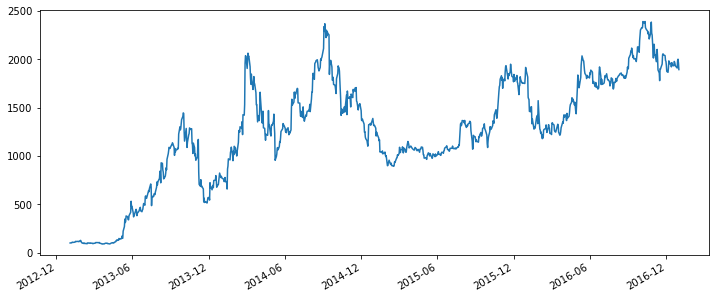

In [107]:
result.v.plot(figsize=(12,5))